**This notebook demonstrates the following:**

>     1. View full ECG records in details (indexed per beat)
>     2. Extract heart-beats from ecg records (to be used as input vectors for classification models)


In [1]:
%reset

**IMPORTS**

In [2]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

**GLOBAL SECTION**

In [3]:
########################################################################
# global variables
########################################################################
# Resampled every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

# >------ parent db directory ------------------------------------------
DB_NPY = 'db_npy'
print('DATASET DIR ::',DB_NPY)

# >------ load standard labels ------------------------------------------
std_annotations = os.path.join(DB_NPY,'annotations.txt')
print('STD ANN FILE ::',std_annotations)
std_ant = np.loadtxt(std_annotations, dtype='str',delimiter="\t")

#------------------------------------------------------------------------
# Seperate out stand beat and non-beat annotations using 'annotations.txt'
beat_ants = []
non_beat_ants = []
print('\nStandard Labels::')
for a in std_ant:
    # a[0] =  # standard label (char)
    # a[1] =  # type of label
    # a[2]  = # description (str)
    print(a[0]+'\t'+a[1]+'\t'+a[2])
    if a[1]=='b': #<<--- is a beat-annotation
        beat_ants.append(a[0])
    else:
        non_beat_ants.append(a[0])

print('')
print('beat-annotation:',len(beat_ants))
print('non-beat-annotation:',len(non_beat_ants))
#-----------------------------------------------------------------------------
gbreak = '____________________________________________________________________'
#-----------------------------------------------------------------------------
# data file identifiers 
g_BEAT = '_BEAT.npy'       #<<--- beat annotations
g_NBEAT = '_NBEAT.npy'     #<<--- non-beat annotations
g_SIG2 = '_SIG_II.npy'     #<<--- Signal Data (Removed manual gain)

Basic sampling rate(Hz): 128
DATASET DIR :: db_npy
STD ANN FILE :: db_npy\annotations.txt

Standard Labels::
N	b	Normal beat
L	b	Left bundle branch block beat
R	b	Right bundle branch block beat
B	b	Bundle branch block beat (unspecified)
A	b	Atrial premature beat
a	b	Aberrated atrial premature beat
J	b	Nodal (junctional) premature beat
S	b	Supraventricular premature or ectopic beat (atrial or nodal)
V	b	Premature ventricular contraction
r	b	R-on-T premature ventricular contraction
F	b	Fusion of ventricular and normal beat
e	b	Atrial escape beat
j	b	Nodal (junctional) escape beat
n	b	Supraventricular escape beat (atrial or nodal)
E	b	Ventricular escape beat
/	b	Paced beat
f	b	Fusion of paced and normal beat
Q	b	Unclassifiable 
?	b	Beat not classified during learning
[	n	Start of ventricular flutter/fibrillation
!	n	Ventricular flutter wave
]	n	End of ventricular flutter/fibrillation
x	n	Non-conducted P-wave (blocked APC)
(	n	Waveform onset
)	n	Waveform end
p	n	Peak of P-wave
t	n	Peak of 

**Define Custom annotation map** [Optional]

In [4]:
#<< --- define custom labels. 
_N = '_N'  # N - normal class - Non-Ectopic
_S = '_S'  # S - SupraVentricular Ectopic Beats (SVEBs)
_V = '_V'  # V - Ventricular Ectopic Beats (VEBs)
_F = '_F'  # F - Fusion Beats
_Q = '_Q'  # Q - Unrecognized
_X = '_X'  # X - Unmapped - if you don't want to use a lable, map it under this class - it should not be used in classification

custom_ants = [ _N, _S, _V, _F, _Q ]  # as recomended by AAMI

# define a mapping dictionary #----------------------------------
custom_cols = { _N:'tab:green',
                _S:'tab:red',
                _V:'tab:blue',
                _F:'tab:purple',
                _Q:'yellow',
                _X:'tab:gray'}
custom_mapping = {
                    #<--- Normal Class
                    'N': _N, 
                    'L': _N,
                    'R': _N,
                    'B': _N,
    
                    #<--- SVEB
                    'A': _S,
                    'a': _S,
                    'J': _S,
                    'S': _S,
    
                    #<--- VEB
                    'V': _V, 
                    'r': _V,
    
                    #<--- FUSION
                    'F': _F,
    
                    #<---* Supraventricular escape - aami says its normal but should be mapped to _S
                    'e': _S,
                    'j': _S,
                    'n': _S,
    
                    #<---* Ventricular escape - aami says its normal but should be mapped to _V
                    'E': _V,
    
                    #<--- Paced beats are unmapped - dont use record containing paced beats (mitdb - 102,104,107,217)
                    'f': _X,
                    '/': _X,
    
                    #<--- Unrecognised or Unclassifiable
                    'Q': _Q,
                    '?': _Q,
                }

**Use objects to represent ECG Database, Records and Beats**

In [5]:
##############################################################################################################################3
# CLASS DEFS
##############################################################################################################################3

#<-------------------------------------------------------------------------------------------------- Represent one ECG database
class ecgDatabase:
    def __init__(self, db_name, db_path):
        self.db_name = db_name
        self.db_path = db_path
        self._prepare()
        
    def _prepare(self):
        # 1. read record list
        self.record_list = np.loadtxt(os.path.join(self.db_path,'RECORDS'), dtype='str',delimiter="\n")
        if len(self.record_list.shape)==0:
            self.record_list = np.array([self.record_list])
        
        # 2. prepare a dictionary of ecgRecord objects
        self.records = {}
        for irec in self.record_list:
            self.records[irec] = ecgRecord(irec,os.path.join(self.db_path),self.db_name) 
            #<--- records are not loaded initially, will be loaded dynamically
        return
        
    def get_record(self, rec_name):
        if rec_name in self.records.keys():
            this_rec = self.records[rec_name]
            if not this_rec.isloaded:
                this_rec.loadfromdisk()  #<--- Loads records dynamically, on call to this function
            return this_rec
        else:
            return None  #<--- No record with name <rec_name>

#<------------------------------------------------------------------------------------------------- Represent one ECG Record        
class ecgRecord:
    def __init__(self, arg_recname, arg_path, db_name):
        self.dbname = db_name
        self.path = arg_path
        self.name = arg_recname
        self.isloaded = False
        
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REQUIRED
    def loadfromdisk(self, verbose=0):
        if verbose>0:
            print('\nLoading Record:', self.name)
        #<<---------------------------------------------
        # Load Signal Data
        #<<---------------------------------------------
        self.signal_file = os.path.join(self.path,self.name + g_SIG2)
        self.iSignal = np.load(self.signal_file)
        if verbose>0:
            print('Signal Length:',self.iSignal.shape)
            print('Signal Duration:',len(self.iSignal)/BASIC_SRATE, 'sec')
        
        #<<---------------------------------------------
        # Load Beat-Annotation (Labels)
        #<<---------------------------------------------
        self.beat_file = os.path.join(self.path,self.name + g_BEAT)
        self.iBeat = np.load(self.beat_file)
        if verbose>0:
            print('#Beats:',self.iBeat.shape)
        # seperate out R-peaks and Labels (note both are in string format)
        self.iRpeaks = self.iBeat[:,0].astype('int') #<<-- convert sampling locations to integer
        self.iLabels = self.iBeat[:,1]               #<<-- labels remain as string
        self.nos_beats = len(self.iRpeaks)
        
        #<<---------------------------------------------thats it, Non-Beat-Annotation not required
        self.isloaded = True
        return self.isloaded
    
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REQUIRED
    # for mapping custom labels   ** rec.mLabels = rec.map_beat_labels(custom_mapping)
    # must be called after loading record to be able to use custom mapping
    def map_beat_labels(self, c_mapping, c_colors):
        self.mLabels = np.zeros(len(self.iLabels), dtype='U2')
        self.mColors = np.zeros(len(self.iLabels), dtype='U10')
        for i in range(0,len(self.iLabels)):
            self.mLabels[i]=c_mapping[self.iLabels[i]]
            self.mColors[i]=c_colors[self.mLabels[i]]
            
        return len(self.mLabels)
    
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Fixed Duration Signal 
    # Gets Signal Data of fixed duration along with indices of r-peaks in the range
    # pf and pt are measured in samples not seconds 
    # to convert use, samples =  int(seconds / BASIC_SRATE)   ** must be integers
    # can be negative too
    
    def get_true_range(self,pf,pt):

        N = len(self.iSignal)
        if pt<pf:
            pt,pf = pf,pt # swap
            
        if pf<0:
            pf=0
        elif pf>=N:
            pf=N-1
            
        if pt<0:
            pt=0
        elif pt>N:
            pt=N
        return pf, pt
            
    def get_signal_slice_fd(self,pf, pt):
        signal_slice = self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Variable Length Representation
    # Gets Signal data of beat at 'beat_index'. (Variable Length)
    # On the left, take signal data upto R-peak of beat 'minus_i' indices before it and trim by 'signal_trim_left'
    # On the right, take signal data upto R-peak of beat 'plus_i' indices after it and trim by 'signal_trim_right'
    # trim params can be negative too
    def get_signal_slice_biV(self, beat_index, minus_i, plus_i ,signal_trim_left, signal_trim_right ):
        RpeakL = self.iRpeaks[beat_index-minus_i]+signal_trim_left
        RpeakC = self.iRpeaks[beat_index]
        RpeakR = self.iRpeaks[beat_index+plus_i]-signal_trim_right
        pf,pt = RpeakL,RpeakR
        signal_slice=self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt

    # a shorter version of above function. use when only the signal data is required
    def get_signal_slice_biV_(self, beat_index, minus_i, plus_i ,signal_trim_left, signal_trim_right ):
        return self.iSignal[self.iRpeaks[beat_index-minus_i]+signal_trim_left:self.iRpeaks[beat_index+plus_i]-signal_trim_right]

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Fixed Length Representation
    # Gets Signal data of beat at 'beat_index'. (Fixed Length)
    def get_signal_slice_biF(self, beat_index, left_samples, right_samples ):
        Rpeak = self.iRpeaks[beat_index]
        pf, pt =  Rpeak-left_samples, Rpeak+right_samples
        signal_slice = self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt
    
    # a shorter version of above function. use when only the signal data is required
    def get_signal_slice_biF_(self, beat_index, left_samples, right_samples ):
        return self.iSignal[self.iRpeaks[beat_index]-left_samples:self.iRpeaks[beat_index]+right_samples]
#-------------------------------------------------------------------------------------------------------------------
# NOTE: be careful with out of range indices - use rec.get_true_range(pf,pt)
#-------------------------------------------------------------------------------------------------------------------

# functions for plotting
yll, yul, ycl = -3, 3.5, -2.8

def plot_beat(signal_slice, signal_list, pf, pt, ph,
                show_label_ticks=False, show_custom_labels=True, show_custom_vline=False,
                w=0.012, h=4, r=0.5):
    
    plt.figure(figsize=(w*len(signal_slice),h), constrained_layout=True)
    plt.ylim(yll, yul)
    plt.xlim(pf,pt)
    
    ilen = len(signal_list)
    _range = np.arange(pf,pt,BASIC_SRATE)
    _peaks = rec.iRpeaks[signal_list]
    _labels = rec.iLabels[signal_list]
    _colorL = rec.mColors[signal_list]
    
    # plot the signal
    plt.plot(np.arange(pf,pt,1), signal_slice, color='black',linewidth=0.8)
    plt.vlines(ph,yll,yul,linewidth=0.8,color='black' )
    
    # plot ticks
    if show_label_ticks:
        plt.xticks(_peaks,_labels) #-pf*BASIC_SRATE
        plt.grid( axis='x')
    else:
        plt.xticks(_range,np.round(_range/BASIC_SRATE,2))#,rotation=60)

    # plot labels
    if show_custom_labels:
        plt.scatter(_peaks ,np.zeros(ilen)+ycl, c=_colorL)
        if show_custom_vline:
            for j in range(0,ilen):
                plt.annotate(signal_list[j],xy=(_peaks[j],ycl+0.3) )
                plt.vlines(_peaks[j],yll,yul,linewidth=0.4,color=_colorL[j])

    
    plt.show()
    return

**Find count of all beats in all records**
 
 ... and export to /kaggle/working/count.csv 

In [6]:

# all databases---------------------------------------------
db_list = ['mitdb','svdb', 'incartdb']
rf = open('count.csv','w')  # creates this csv, use it to investigate further
sep = ','  # comma seperated values

# prepare header---------------------------------------------
header = 'DATABASE'+sep+'RECORD'+sep+'#BEATS'
for sa in  beat_ants:
    header+= sep+sa
header+=sep+'SUM'
for ca in  custom_ants:
    header+= sep+ca
header+=sep+'CSUM'

header+=sep + "NN_ALL"
header+=sep + "NN_TRUE"
header+=sep + "NN_SEMI"
header+=sep + "NN_ABS"
header+=sep + "AA_ALL"
header+=sep + "SS_ALL"
header+=sep + "VV_ALL"
header+=sep + "FF_ALL"
header+=sep + "QQ_ALL"
header+=sep + "XX_ALL"

print(header)
rf.write(header+'\n')

# start loop for each db...
for sel_db_name in db_list:

    sel_db_path = os.path.join(DB_NPY, sel_db_name+'_npy')
    sel_db_files = os.listdir(sel_db_path)
    dbo = ecgDatabase(sel_db_name, sel_db_path)
    sel_recs = []
    for recn in dbo.record_list:
        res_r = sel_db_name
        _load_success=False
        try:
            rec = dbo.get_record(recn)
            _load_success = True
        except:
            _load_success = False
        if not _load_success:
            continue
        res_r += sep+rec.name+sep+ str(rec.nos_beats)
        nos_map = rec.map_beat_labels(custom_mapping, custom_cols)# <<-- custom lables
        saDict={}
        sums = 0
        for sa in  beat_ants:
            saDict[sa] = np.where(rec.iLabels==sa)[0]
            isum = len(saDict[sa])
            sums+=isum
            res_r+=sep+ str(isum)
            #print(sa,'\t\t',isum)
        res_r+=sep+ str(sums)
        caDict={}
        sums = 0
        for ca in  custom_ants:
            caDict[ca] = np.where(rec.mLabels==ca)[0]
            isum = len(caDict[ca])
            sums+=isum
            res_r+=sep+ str(isum)
        res_r+=sep+ str(sums)
        # RR-intervals  **NOTE:: SKIPPING FIRST AND LAST BEAT OF THE RECORD
        rp_p, rp_c, rp_n = rec.iRpeaks[0:-2], rec.iRpeaks[1:-1], rec.iRpeaks[2:]
        mLabels_p, mLabels_c, mLabels_n = rec.mLabels[0:-2],rec.mLabels[1:-1],rec.mLabels[2:]

        rri_prev = (rp_c-rp_p)                 #<-- previous rr-interval
        rri_next = (rp_n-rp_c)                 #<-- next rr-interval
        rri_mean = (rri_prev + rri_next)/2       #<-- mean of prev and next
        rri_delta = rri_next - rri_prev        #<-- delta b/w prev and next
        rri_delta_abs = np.abs(rri_delta)       #...... for a normal rhythm, rri_abs_delta should be very small

        ABS_DELTA_LIM = int(0.04*BASIC_SRATE)  #-- define a limit on rri_delta_abs for a beat to be considered Normal rhythm = 0.04 sec

        # Any Normal: All Normal beats
        NN_all = np.where((mLabels_c==_N))[0]+1

        # True Normal: a Normal beat surronded by normal beats on both sides
        NN_true = np.where((mLabels_p==_N) & (mLabels_c==_N) & (mLabels_n==_N))[0]+1

        # Semi Normal: Normal beat surronded by atleast one abnormal beat on any side
        NN_semi = np.where((mLabels_c==_N) & ((mLabels_p!=_N) | (mLabels_n!=_N)))[0]+1

        # Absolute Normal: True Normal and delta_abs_rri < ABS_DELTA_DUR
        NN_abs = np.where((mLabels_p==_N) & (mLabels_c==_N) & (mLabels_n==_N)
                          & (rri_delta_abs<=ABS_DELTA_LIM))[0] + 1

        # Abnormal beats
        AA_all =np.where((mLabels_c!=_N))[0] + 1
        SS_all = np.where((mLabels_c==_S))[0] + 1
        VV_all = np.where((mLabels_c==_V))[0] + 1
        FF_all = np.where((mLabels_c==_F))[0] + 1
        QQ_all = np.where((mLabels_c==_Q))[0] + 1
        
        # Unmapped beats
        XX_all = np.where((mLabels_c==_X))[0] + 1
    
        res_r+= (
            sep + str(len(NN_all)) + sep + str(len(NN_true)) + 
            sep + str(len(NN_semi)) + sep + str(len(NN_abs)) + sep + str(len(AA_all)) 
            + sep + str(len(SS_all))+ sep + str(len(VV_all)) + sep + str(len(FF_all))+ sep + str(len(QQ_all))+ sep + str(len(XX_all)))
        #if (len(NN_true>=min_N) and len(AA_all)>=min_A):
        #    sel_recs.append(rec.name)
        print(res_r)
        rf.write(res_r+'\n')
        
    #sel_rec_dict[sel_db_name] = sel_recs
    
rf.close()


DATABASE,RECORD,#BEATS,N,L,R,B,A,a,J,S,V,r,F,e,j,n,E,/,f,Q,?,SUM,_N,_S,_V,_F,_Q,CSUM,NN_ALL,NN_TRUE,NN_SEMI,NN_ABS,AA_ALL,SS_ALL,VV_ALL,FF_ALL,QQ_ALL,XX_ALL
mitdb,100,2273,2239,0,0,0,33,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2273,2239,33,1,0,0,2273,2237,2169,68,1914,34,33,1,0,0,0
mitdb,101,1865,1860,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1865,1860,3,0,0,2,1865,1858,1848,10,1327,5,3,0,0,2,0
mitdb,103,2084,2082,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2084,2082,2,0,0,0,2084,2080,2076,4,1694,2,2,0,0,0,0
mitdb,105,2572,2526,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,5,0,2572,2526,0,41,0,5,2572,2524,2432,92,2338,46,0,41,0,5,0
mitdb,106,2027,1507,0,0,0,0,0,0,0,520,0,0,0,0,0,0,0,0,0,0,2027,1507,0,520,0,0,2027,1505,987,518,569,520,0,520,0,0,0
mitdb,107,2137,0,0,0,0,0,0,0,0,59,0,0,0,0,0,0,2078,0,0,0,2137,0,0,59,0,0,59,0,0,0,0,2135,0,59,0,0,2076
mitdb,108,1763,1739,0,0,0,4,0,0,0,17,0,2,0,1,0,0,0,0,0,0,1763,1739,5,17,2,0,1763,1737,1694,43,885,24,5,17,2,0,0
mitdb,109,2532,0,2492,0,0,0,0,0,0,38,0,2,0,0,0,0,0,0,0,0,2532,2492,0,

**TODO:**

**Download count.csv and inspect the count of labels in each record.**

**Then proceed to view an ecg record in detail...**



**..... select mitdb's record 207 - its a unique record because it contains flutter waves**

**Select a Database**

In [7]:
sel_db_name = 'mitdb' # [ select from - 'mitdb', 'svdb', 'incartdb']
sel_db_path = os.path.join(DB_NPY, sel_db_name+'_npy')
sel_db_files = os.listdir(sel_db_path)
print(sel_db_path,',', len(sel_db_files) , 'files')

dbo = ecgDatabase(sel_db_name, sel_db_path)
print(dbo.record_list.shape,dbo.record_list)

db_npy\mitdb_npy , 143 files
(48,) ['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '121' '122' '123' '124' '200'
 '201' '202' '203' '205' '207' '208' '209' '210' '212' '213' '214' '215'
 '217' '219' '220' '221' '222' '223' '228' '230' '231' '232' '233' '234']


**Select a Record**

In [8]:
recn = '207'
rec = dbo.get_record(recn)
print(rec.name, '\t'+str(rec.nos_beats)+ ' beats')
nos_map = rec.map_beat_labels(custom_mapping, custom_cols)# <<-- custom lables
print('Mapped Labels:', nos_map)

207 	1860 beats
Mapped Labels: 1860


**Investigate Beat Labels and RRIs**

Recod: mitdb/207 	1860 beats
____________________________________________________________________
Standard Label Count
N 		 0
L 		 1457
R 		 86
B 		 0
A 		 107
a 		 0
J 		 0
S 		 0
V 		 105
r 		 0
F 		 0
e 		 0
j 		 0
n 		 0
E 		 105
/ 		 0
f 		 0
Q 		 0
? 		 0
__ 		 1860
____________________________________________________________________

Custom Label Count
_N 		 1543
_S 		 107
_V 		 210
_F 		 0
_Q 		 0
__ 		 1860
____________________________________________________________________

Normals		 1542
 True-type	 1430
 Semi-type	 112
 Abs-type	 1186

Abnormals	 316
 S-type		 106
 V-type		 210
 F-type		 0
 Q-type		 0

Unmapped	 0
____________________________________________________________________


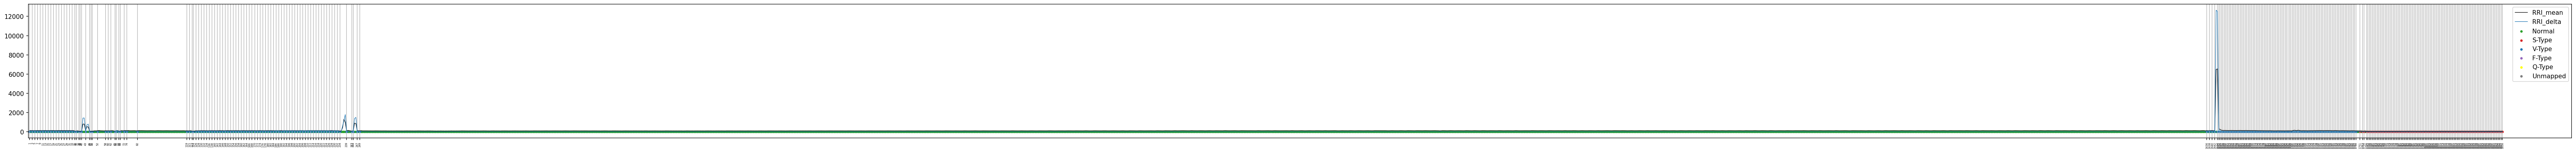

In [9]:
# Find Count of all beats
print('Recod:',rec.dbname+'/'+rec.name, '\t'+str(rec.nos_beats)+ ' beats')
print(gbreak)
print('Standard Label Count')
saDict={}
sum = 0
for sa in  beat_ants:
    saDict[sa] = np.where(rec.iLabels==sa)[0]
    isum = len(saDict[sa])
    sum+=isum
    print(sa,'\t\t',isum)
print('__','\t\t',sum)
print(gbreak)
print('\nCustom Label Count')
caDict={}
sum = 0
for ca in  custom_ants:
    caDict[ca] = np.where(rec.mLabels==ca)[0]
    isum = len(caDict[ca])
    sum+=isum
    print(ca,'\t\t',isum)
print('__','\t\t',sum)
print(gbreak)
# RR-intervals  **NOTE:: SKIPPING FIRST AND LAST BEAT OF THE RECORD
rp_p, rp_c, rp_n = rec.iRpeaks[0:-2], rec.iRpeaks[1:-1], rec.iRpeaks[2:]
mLabels_p, mLabels_c, mLabels_n = rec.mLabels[0:-2],rec.mLabels[1:-1],rec.mLabels[2:]

rri_prev = (rp_c-rp_p)                 #<-- previous rr-interval
rri_next = (rp_n-rp_c)                 #<-- next rr-interval
rri_mean = (rri_prev + rri_next)/2       #<-- mean of prev and next
rri_delta = rri_next - rri_prev        #<-- delta b/w prev and next
rri_delta_abs = np.abs(rri_delta)       #...... for a normal rhythm, rri_abs_delta should be very small

ABS_DELTA_LIM = int(0.04*BASIC_SRATE)  #-- define a limit on rri_delta_abs for a beat to be considered Normal rhythm = 0.04 sec


# Any Normal: All Normal beats
NN_all = np.where((mLabels_c==_N))[0]+1

# True Normal: a Normal beat surronded by normal beats on both sides
NN_true = np.where((mLabels_p==_N) & (mLabels_c==_N) & (mLabels_n==_N))[0]+1

# Semi Normal: Normal beat surronded by atleast one abnormal beat on any side
NN_semi = np.where((mLabels_c==_N) & ((mLabels_p!=_N) | (mLabels_n!=_N)))[0]+1

# Absolute Normal: True Normal and delta_abs_rri < ABS_DELTA_DUR
NN_abs = np.where((mLabels_p==_N) & (mLabels_c==_N) & (mLabels_n==_N)
                  & (rri_delta_abs<=ABS_DELTA_LIM))[0] + 1

# Abnormal beats
AA_all =np.where((mLabels_c!=_N))[0] + 1 
SS_all =np.where((mLabels_c==_S))[0] + 1
VV_all =np.where((mLabels_c==_V))[0] + 1
FF_all =np.where((mLabels_c==_F))[0] + 1
QQ_all =np.where((mLabels_c==_Q))[0] + 1


# Unmapped beats
XX_all = np.where((mLabels_c==_X))[0] + 1


print("\nNormals\t\t", len(NN_all))
print(" True-type\t", len(NN_true))
print(" Semi-type\t", len(NN_semi))
print(" Abs-type\t", len(NN_abs))
print("\nAbnormals\t", len(AA_all))
print(" S-type\t\t", len(SS_all))
print(" V-type\t\t", len(VV_all))
print(" F-type\t\t", len(FF_all))
print(" Q-type\t\t", len(QQ_all))
print("\nUnmapped\t", len(XX_all))
print(gbreak)

plt.figure('RRIs', figsize=(int(0.04*rec.nos_beats),4), dpi=150)
plt.xlim(0,rec.nos_beats+50)
#plt.xticks(np.arange(0,rec.nos_beats+1,10))
plt.xticks(AA_all, fontsize=4, rotation=90)
plt.grid(axis='x')
xrng = np.arange(1,rec.nos_beats-1,1)
assert (len(xrng) == len(rri_mean))
plt.plot(xrng, rri_mean, linewidth=0.8, color='black', label='RRI_mean')
plt.plot(xrng, rri_delta_abs, linewidth=0.8, color='tab:blue', label='RRI_delta')
plt.scatter(NN_all, np.zeros(len(NN_all)), color=custom_cols[_N], marker='.', label='Normal' )
plt.scatter(SS_all, np.zeros(len(SS_all))+5, color=custom_cols[_S], marker='.', label='S-Type' )
plt.scatter(VV_all, np.zeros(len(VV_all))+5, color=custom_cols[_V], marker='.', label='V-Type' )
plt.scatter(FF_all, np.zeros(len(FF_all))+5, color=custom_cols[_F], marker='.', label='F-Type' )
plt.scatter(QQ_all, np.zeros(len(QQ_all))+5, color=custom_cols[_Q], marker='.', label='Q-Type' )
plt.scatter(XX_all, np.zeros(len(XX_all))-5, color=custom_cols[_X], marker='.', label='Unmapped' )
plt.legend()
plt.show()

the above graphs:

    1. show the mean and the delta rri for each beat of the record ( expect for the first and the last beat that were skipped )
    
    2. shows indices of abnormal beats (marked on x-axis)

**Plot Full Record ECG**

**NOTE: This will create around 100 figures each containing 20 sec of ecg signal. 
These consicutive 'strips' of ecg segments will overlap on an interval of 2 seconds**


RECORD: mitdb/207
Signal Length: 231111 samples
Signal Duration: 1805.5546875 sec
____________________________________________________________________

[1] Interval: 0.0 : 20.0 = 20.0 sec  Samples:[ 0 : 2560 ] 	Nos Beats: (20,) [0 : 19]


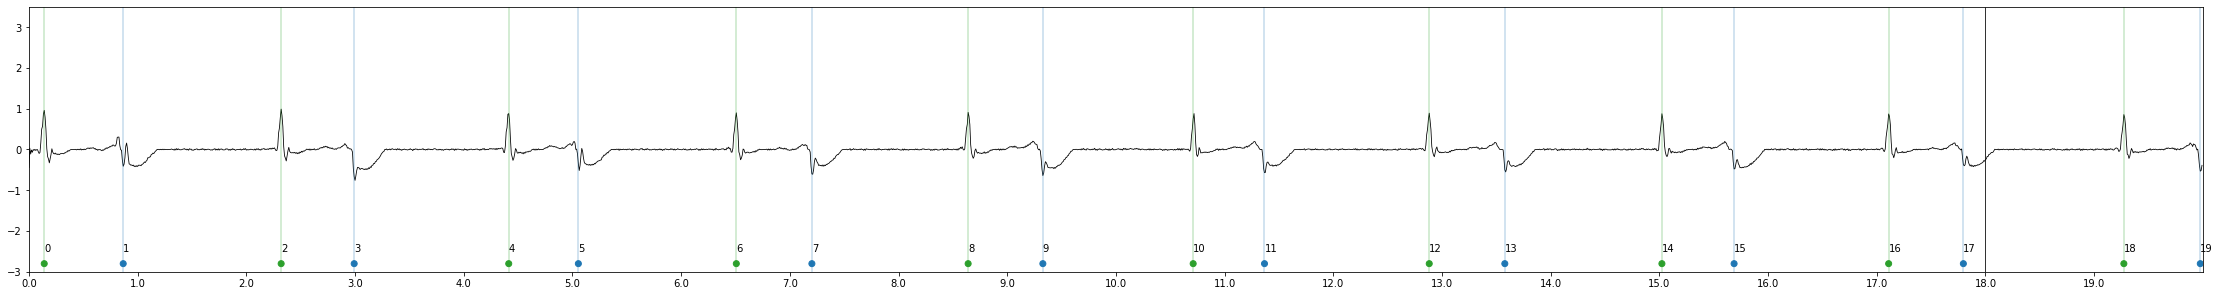

[2] Interval: 18.0 : 38.0 = 20.0 sec  Samples:[ 2304 : 4864 ] 	Nos Beats: (19,) [18 : 36]


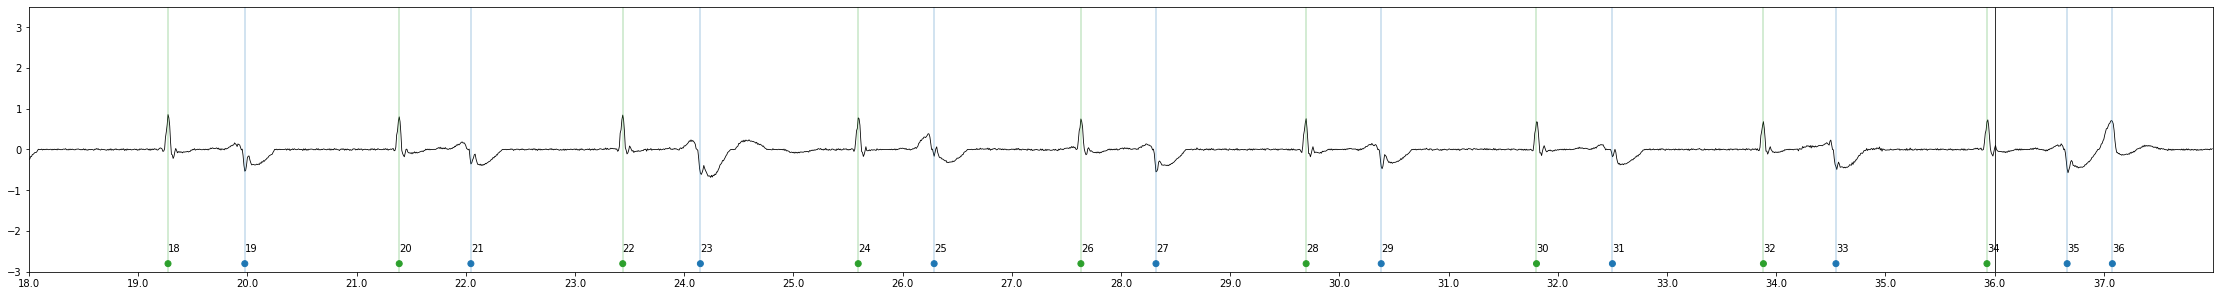

[3] Interval: 36.0 : 56.0 = 20.0 sec  Samples:[ 4608 : 7168 ] 	Nos Beats: (10,) [35 : 44]


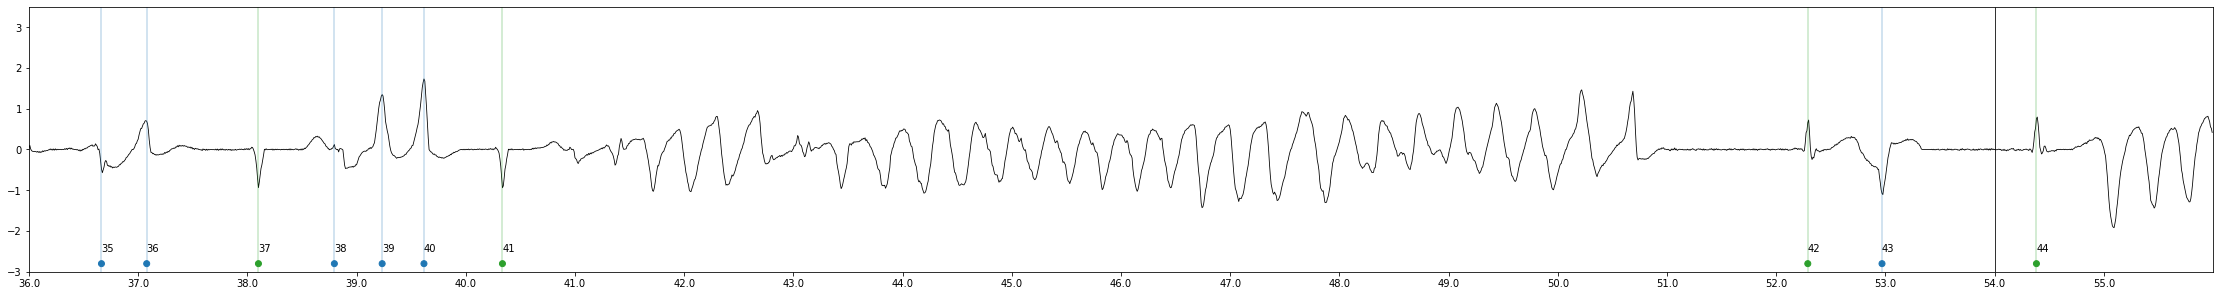

[4] Interval: 54.0 : 74.0 = 20.0 sec  Samples:[ 6912 : 9472 ] 	Nos Beats: (17,) [44 : 60]


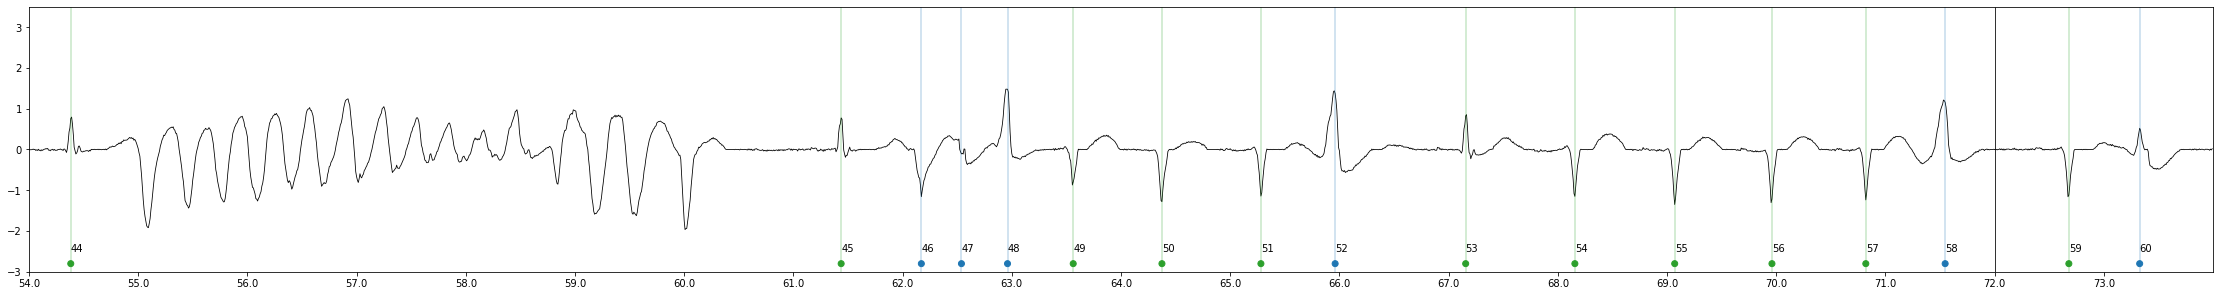

[5] Interval: 72.0 : 92.0 = 20.0 sec  Samples:[ 9216 : 11776 ] 	Nos Beats: (22,) [59 : 80]


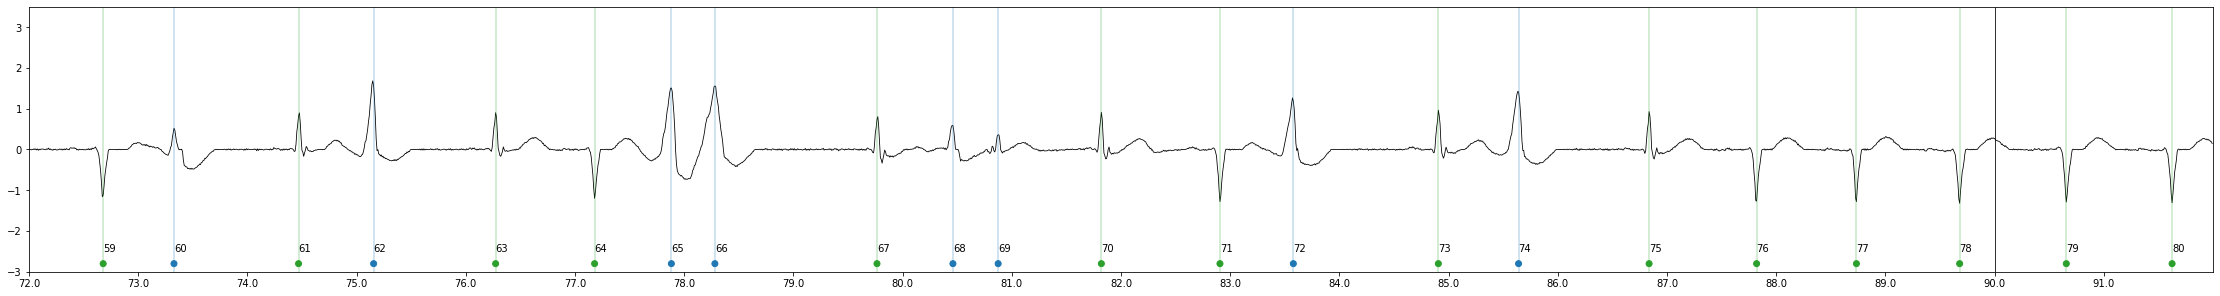

[6] Interval: 90.0 : 110.0 = 20.0 sec  Samples:[ 11520 : 14080 ] 	Nos Beats: (21,) [79 : 99]


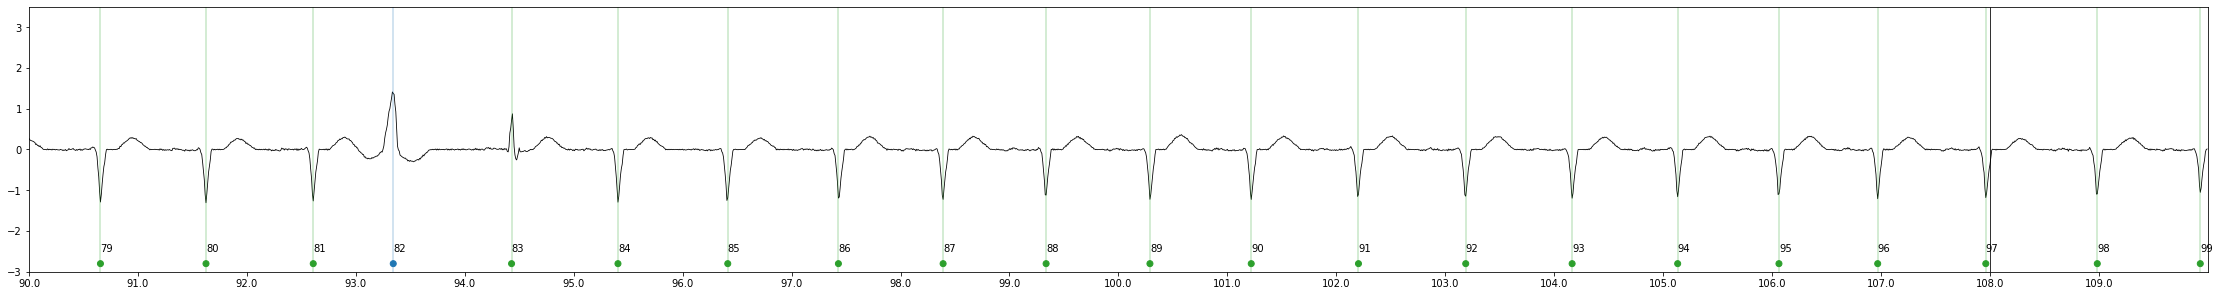

[7] Interval: 108.0 : 128.0 = 20.0 sec  Samples:[ 13824 : 16384 ] 	Nos Beats: (21,) [98 : 118]


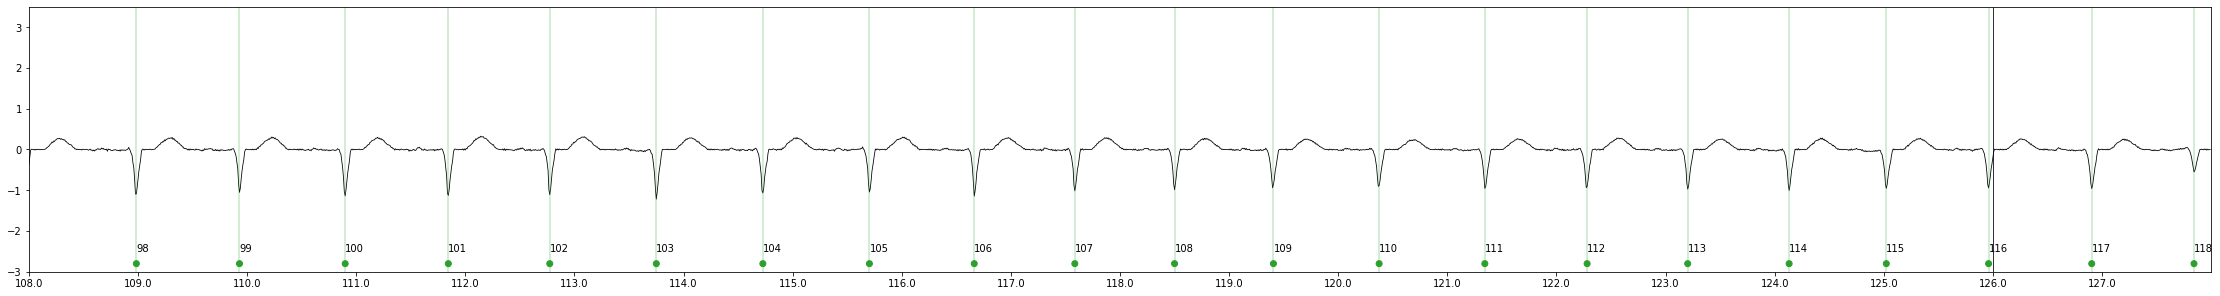

[8] Interval: 126.0 : 146.0 = 20.0 sec  Samples:[ 16128 : 18688 ] 	Nos Beats: (22,) [117 : 138]


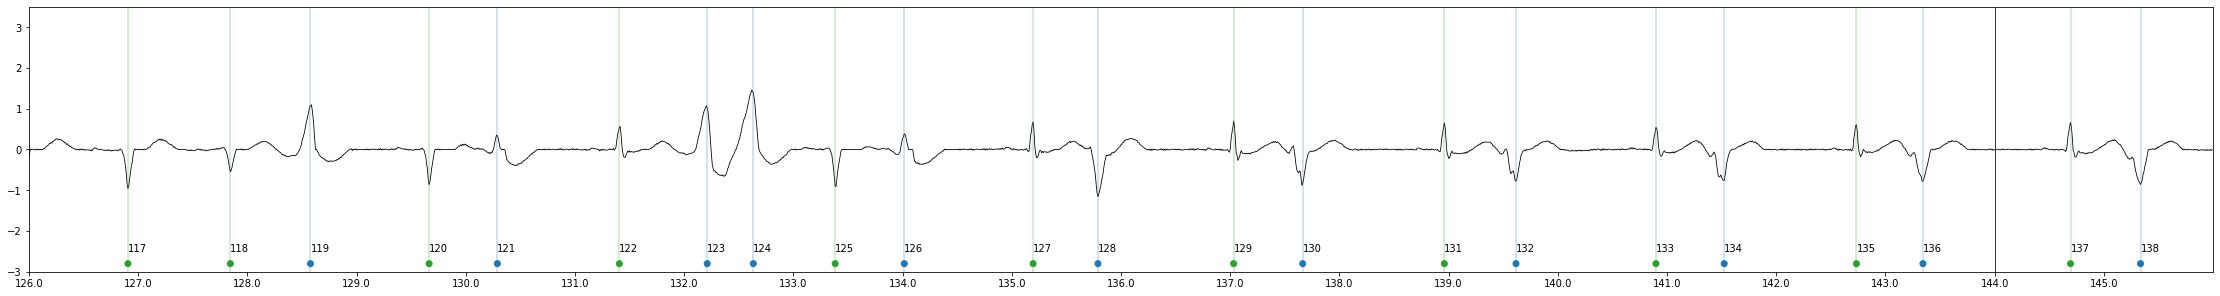

[9] Interval: 144.0 : 164.0 = 20.0 sec  Samples:[ 18432 : 20992 ] 	Nos Beats: (20,) [137 : 156]


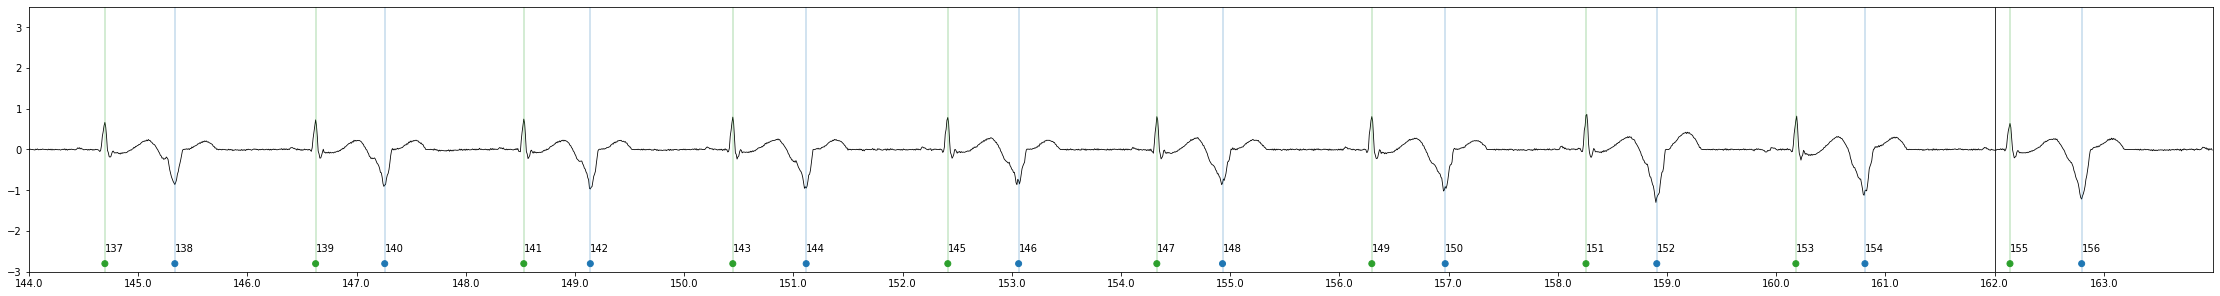

[10] Interval: 162.0 : 182.0 = 20.0 sec  Samples:[ 20736 : 23296 ] 	Nos Beats: (21,) [155 : 175]


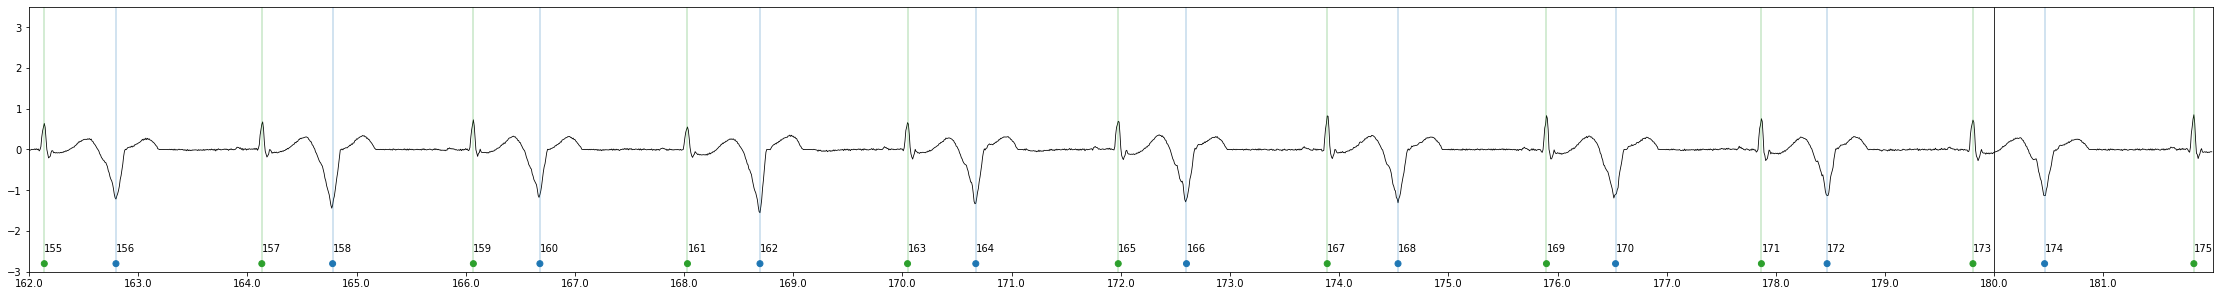

[11] Interval: 180.0 : 200.0 = 20.0 sec  Samples:[ 23040 : 25600 ] 	Nos Beats: (20,) [174 : 193]


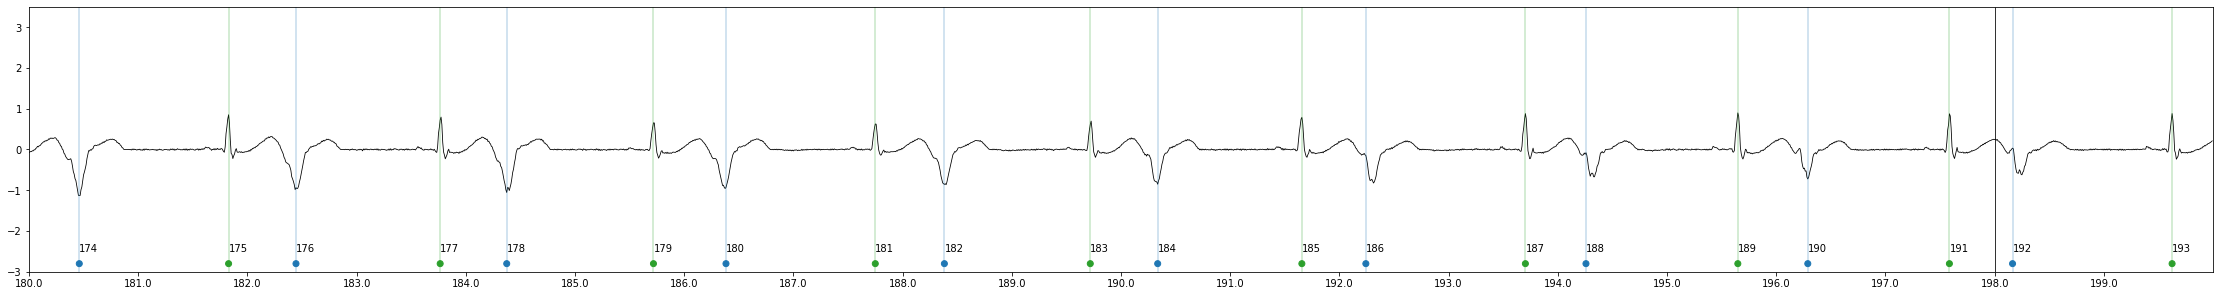

[12] Interval: 198.0 : 218.0 = 20.0 sec  Samples:[ 25344 : 27904 ] 	Nos Beats: (20,) [192 : 211]


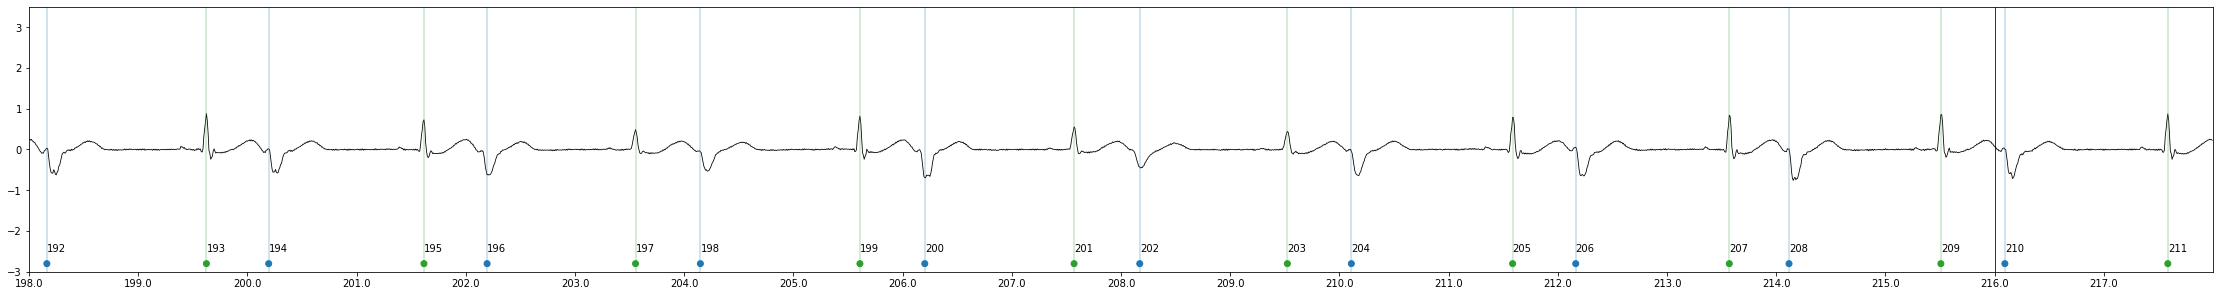

[13] Interval: 216.0 : 236.0 = 20.0 sec  Samples:[ 27648 : 30208 ] 	Nos Beats: (20,) [210 : 229]


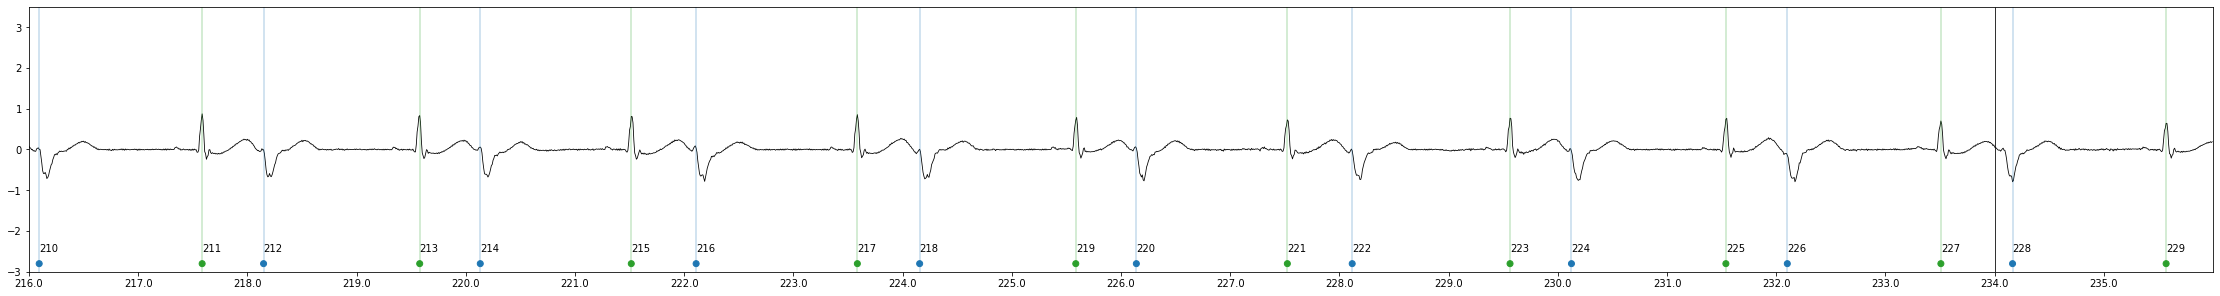

[14] Interval: 234.0 : 254.0 = 20.0 sec  Samples:[ 29952 : 32512 ] 	Nos Beats: (10,) [228 : 237]


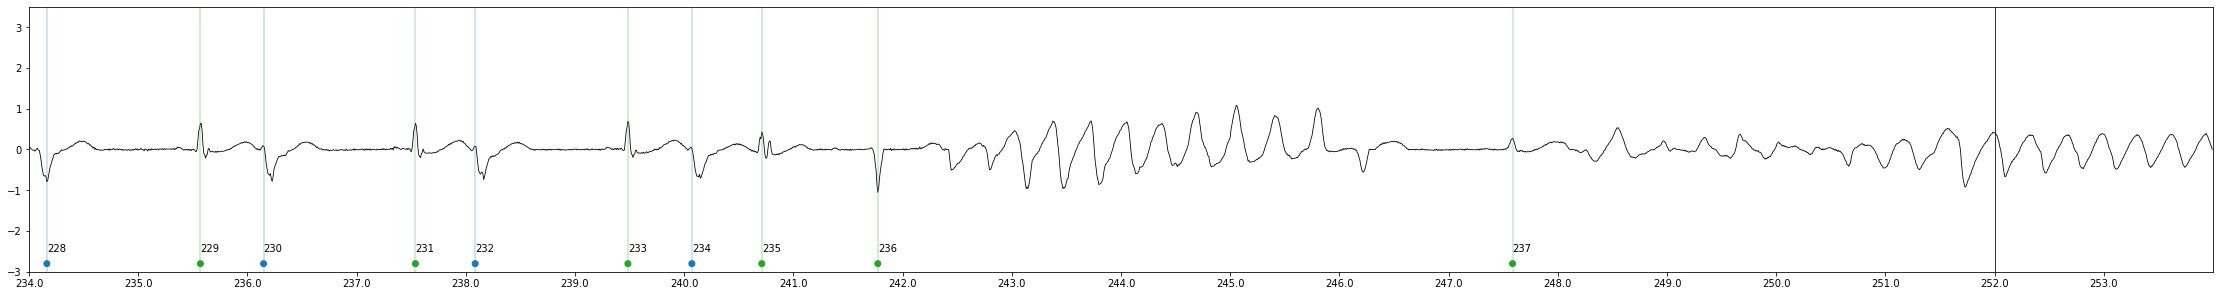

[15] Interval: 252.0 : 272.0 = 20.0 sec  Samples:[ 32256 : 34816 ] 	Nos Beats: (8,) [238 : 245]


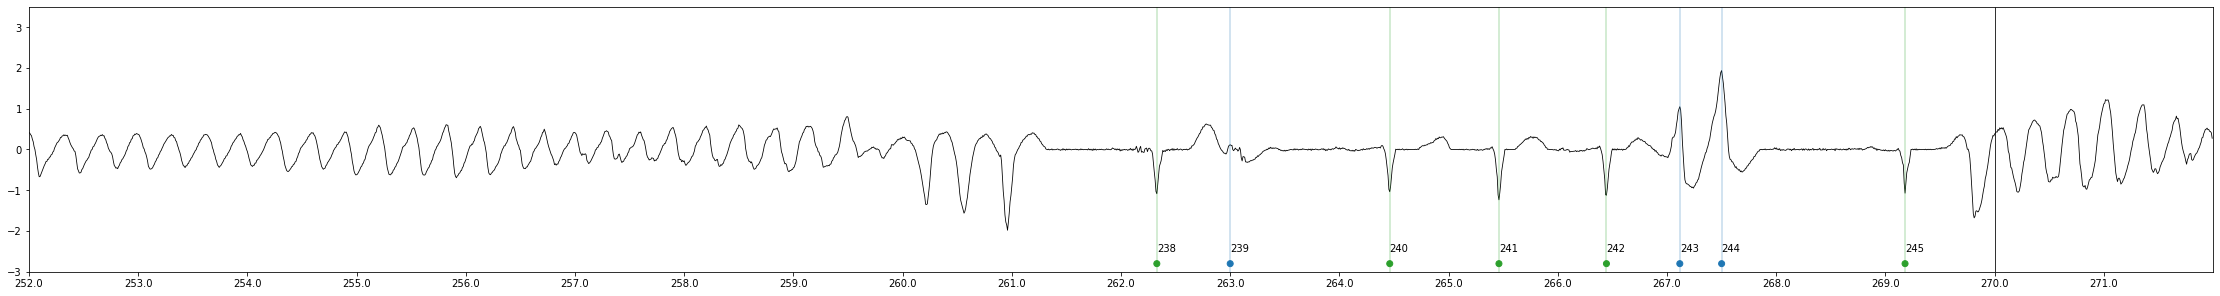

[16] Interval: 270.0 : 290.0 = 20.0 sec  Samples:[ 34560 : 37120 ] 	Nos Beats: (10,) [246 : 255]


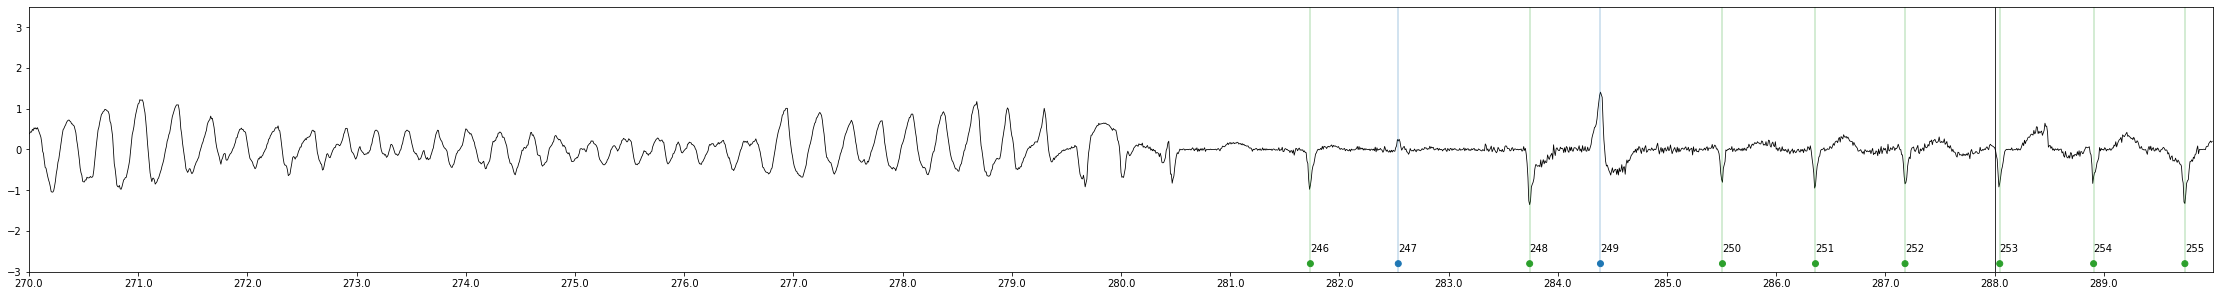

[17] Interval: 288.0 : 308.0 = 20.0 sec  Samples:[ 36864 : 39424 ] 	Nos Beats: (26,) [253 : 278]


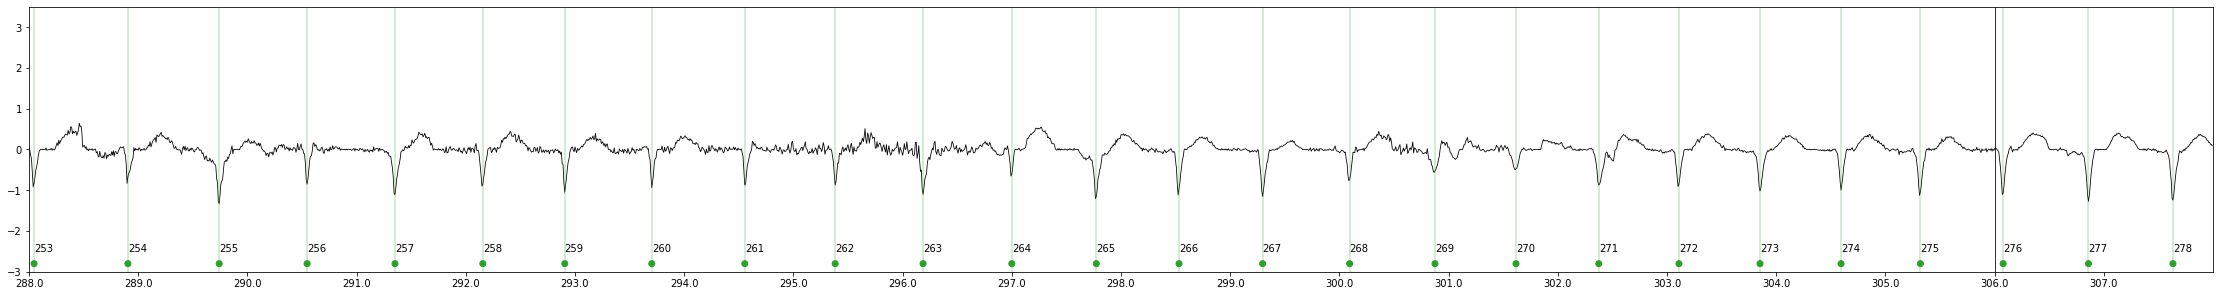

[18] Interval: 306.0 : 326.0 = 20.0 sec  Samples:[ 39168 : 41728 ] 	Nos Beats: (27,) [276 : 302]


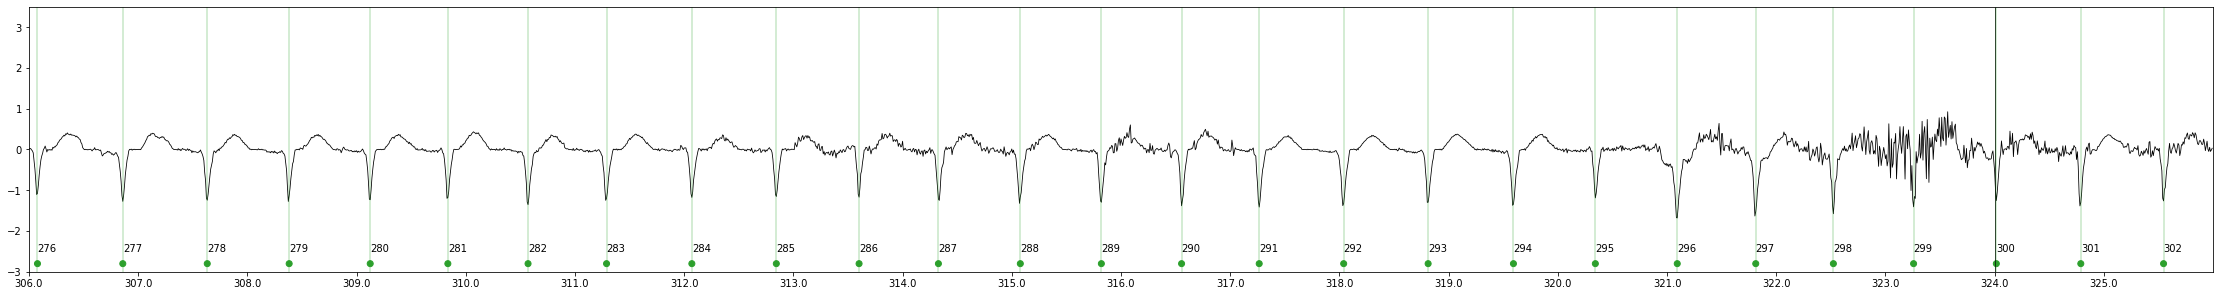

[19] Interval: 324.0 : 344.0 = 20.0 sec  Samples:[ 41472 : 44032 ] 	Nos Beats: (28,) [300 : 327]


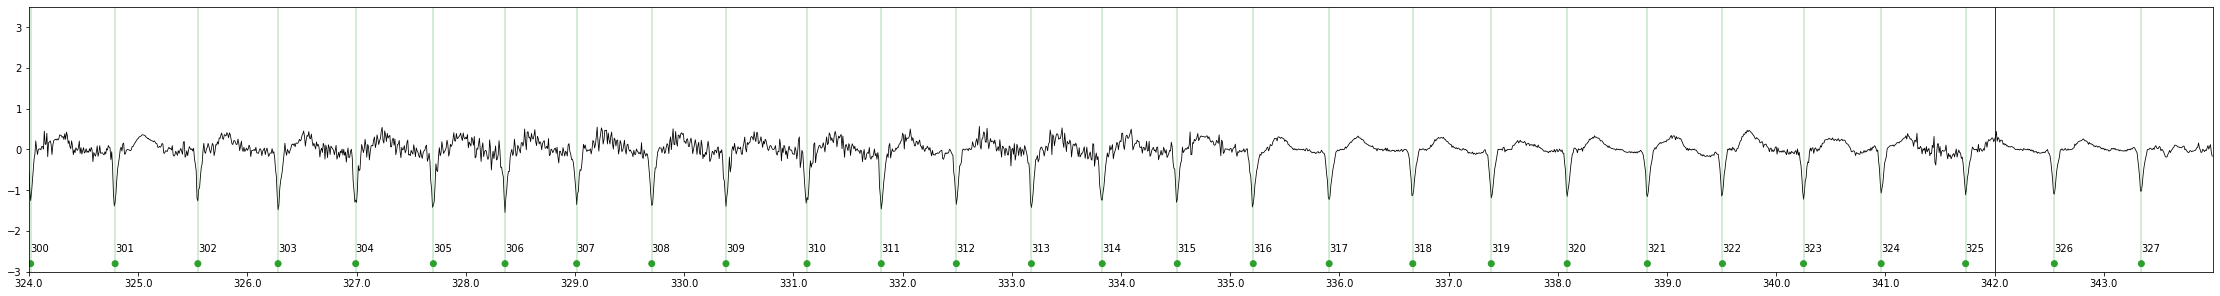

[20] Interval: 342.0 : 362.0 = 20.0 sec  Samples:[ 43776 : 46336 ] 	Nos Beats: (26,) [326 : 351]


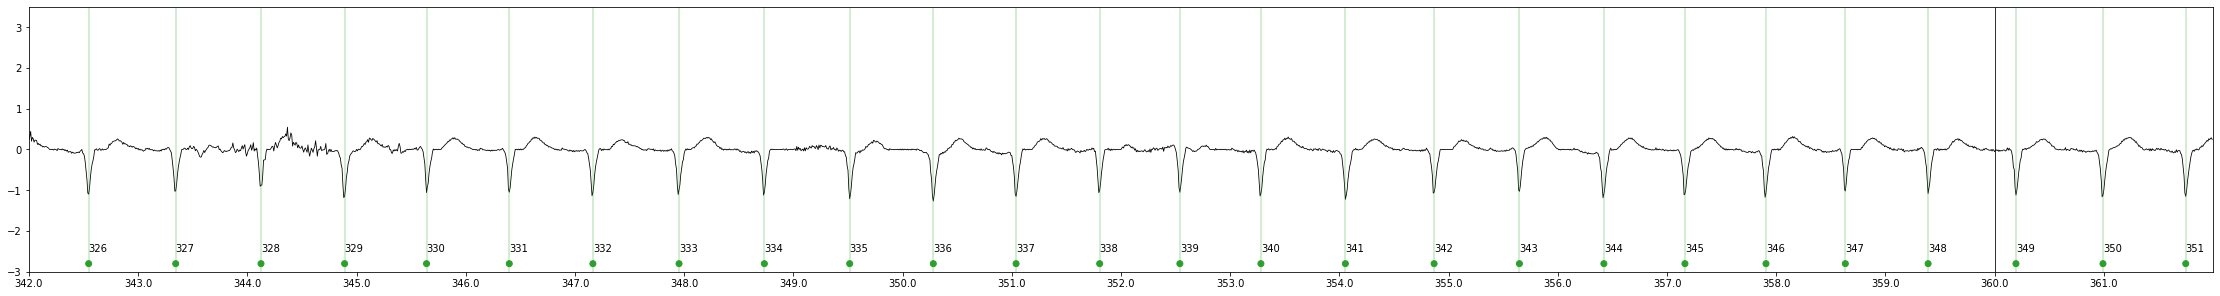

[21] Interval: 360.0 : 380.0 = 20.0 sec  Samples:[ 46080 : 48640 ] 	Nos Beats: (26,) [349 : 374]


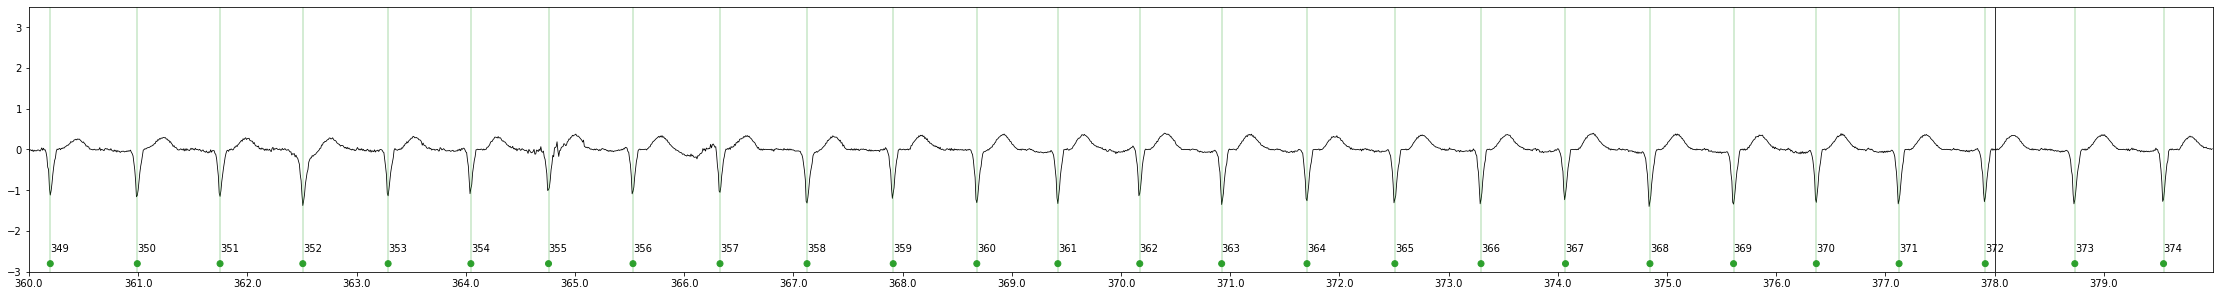

[22] Interval: 378.0 : 398.0 = 20.0 sec  Samples:[ 48384 : 50944 ] 	Nos Beats: (25,) [373 : 397]


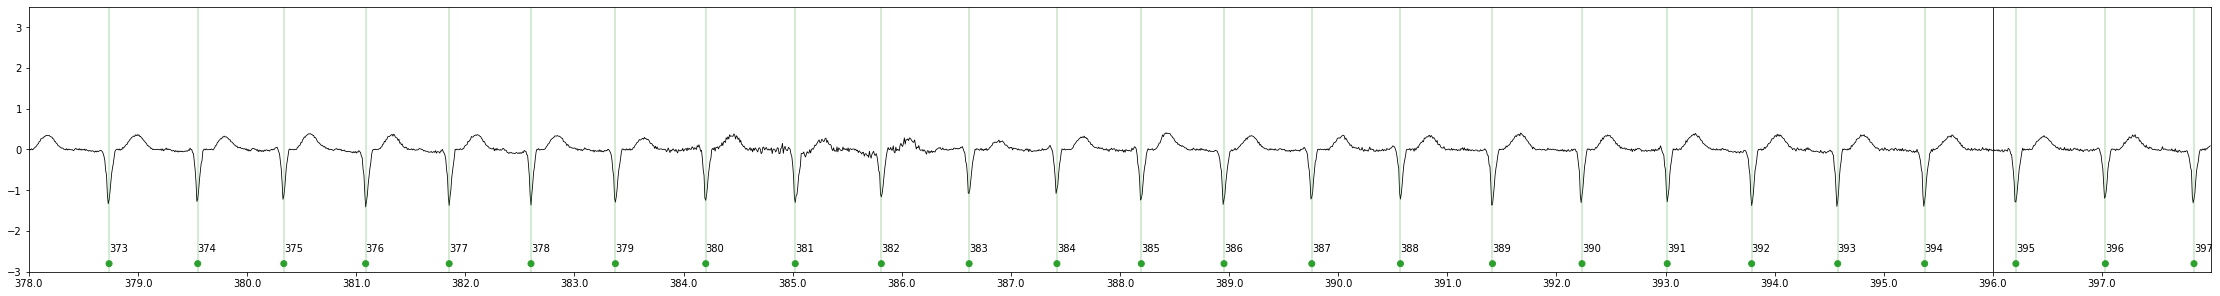

[23] Interval: 396.0 : 416.0 = 20.0 sec  Samples:[ 50688 : 53248 ] 	Nos Beats: (25,) [395 : 419]


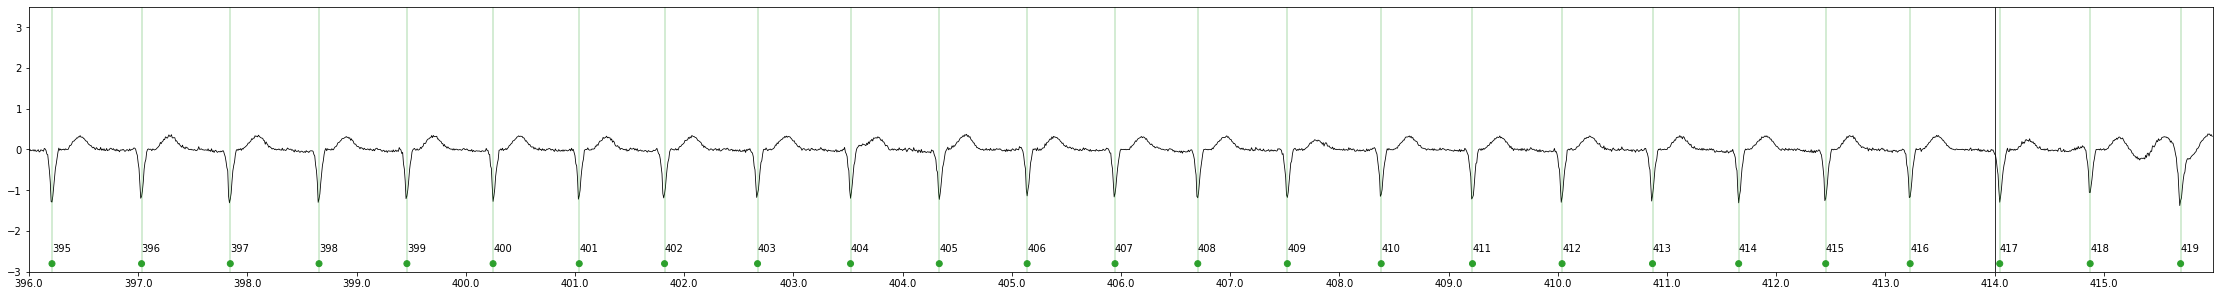

[24] Interval: 414.0 : 434.0 = 20.0 sec  Samples:[ 52992 : 55552 ] 	Nos Beats: (26,) [417 : 442]


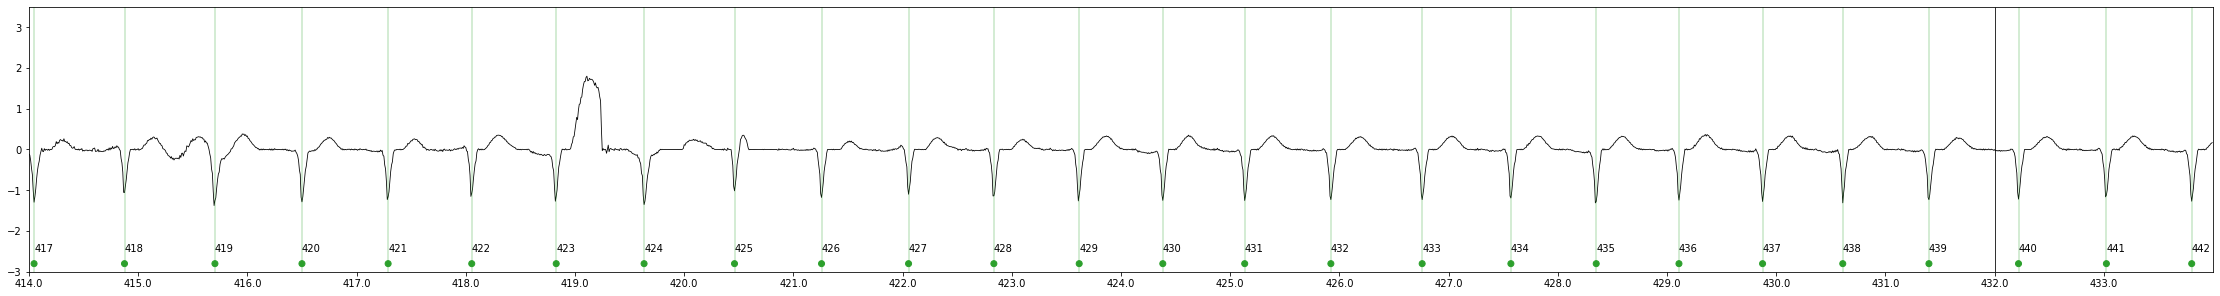

[25] Interval: 432.0 : 452.0 = 20.0 sec  Samples:[ 55296 : 57856 ] 	Nos Beats: (26,) [440 : 465]


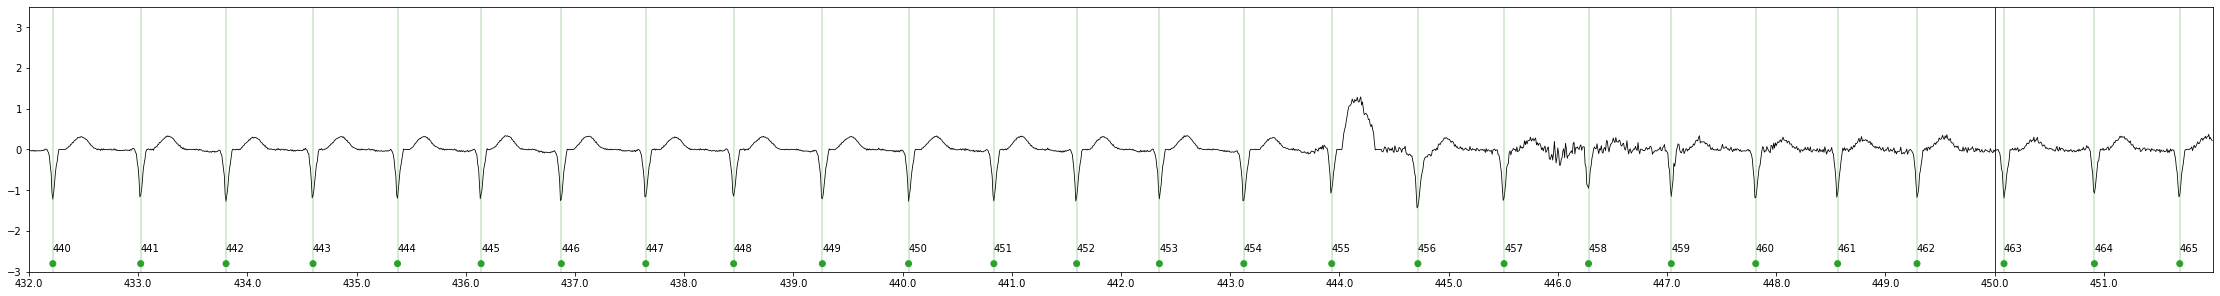

[26] Interval: 450.0 : 470.0 = 20.0 sec  Samples:[ 57600 : 60160 ] 	Nos Beats: (26,) [463 : 488]


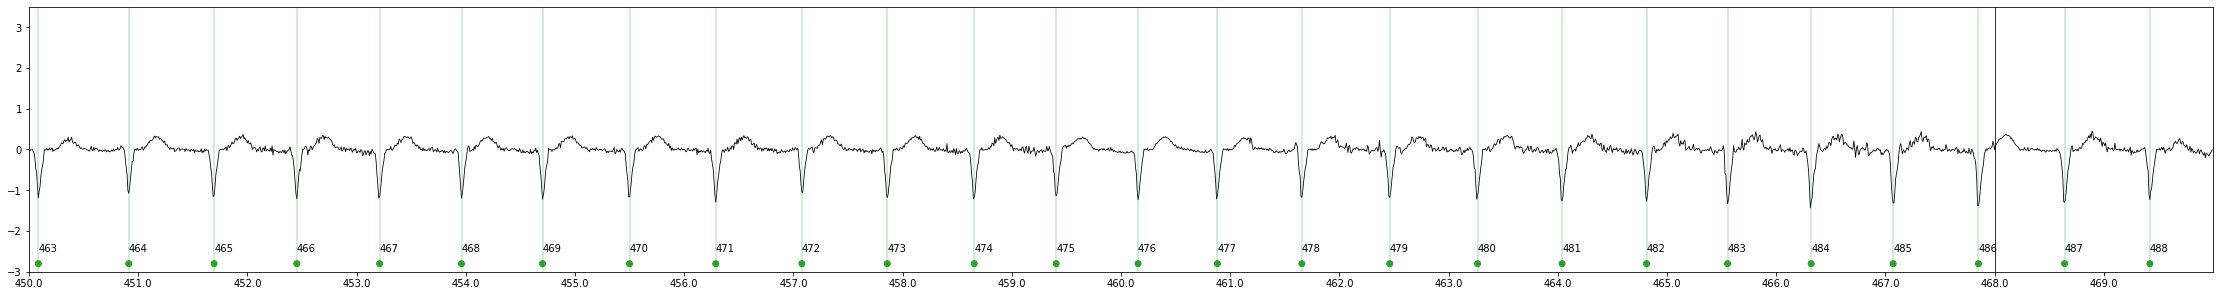

[27] Interval: 468.0 : 488.0 = 20.0 sec  Samples:[ 59904 : 62464 ] 	Nos Beats: (26,) [487 : 512]


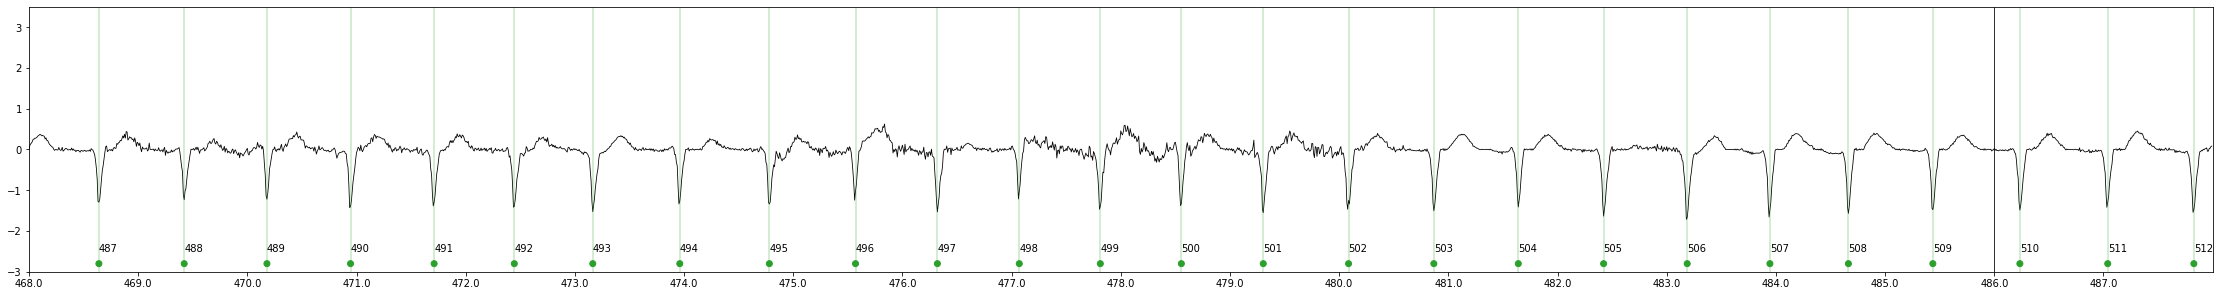

[28] Interval: 486.0 : 506.0 = 20.0 sec  Samples:[ 62208 : 64768 ] 	Nos Beats: (26,) [510 : 535]


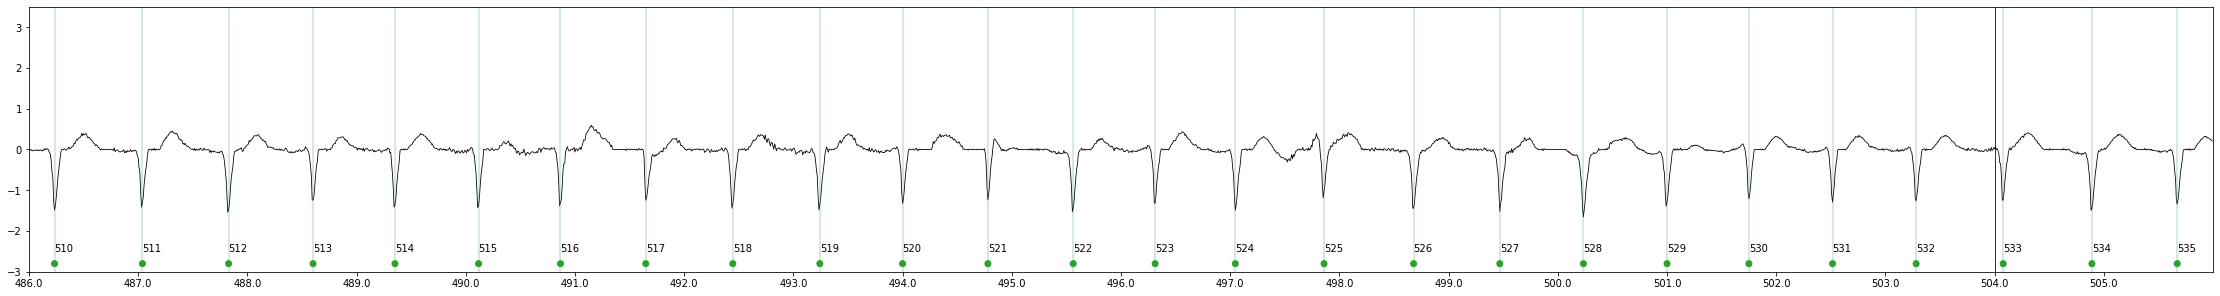

[29] Interval: 504.0 : 524.0 = 20.0 sec  Samples:[ 64512 : 67072 ] 	Nos Beats: (26,) [533 : 558]


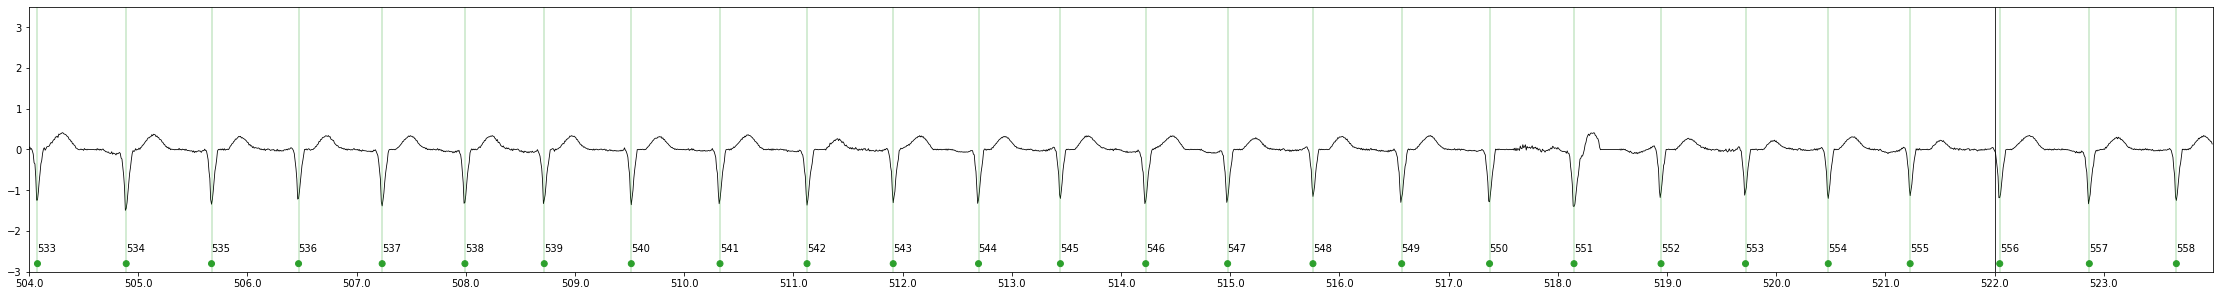

[30] Interval: 522.0 : 542.0 = 20.0 sec  Samples:[ 66816 : 69376 ] 	Nos Beats: (26,) [556 : 581]


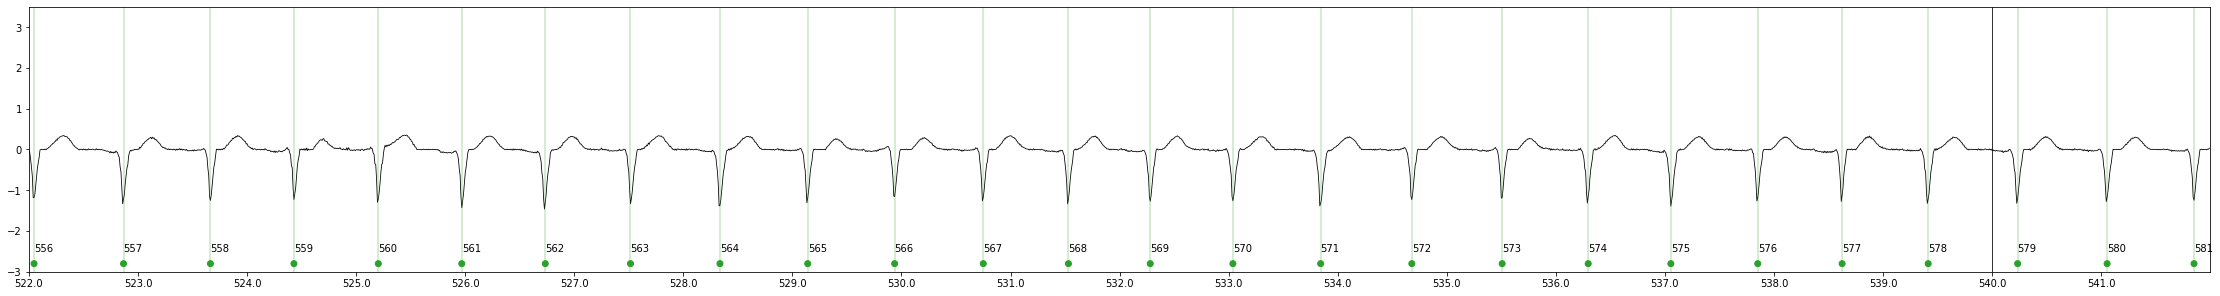

[31] Interval: 540.0 : 560.0 = 20.0 sec  Samples:[ 69120 : 71680 ] 	Nos Beats: (25,) [579 : 603]


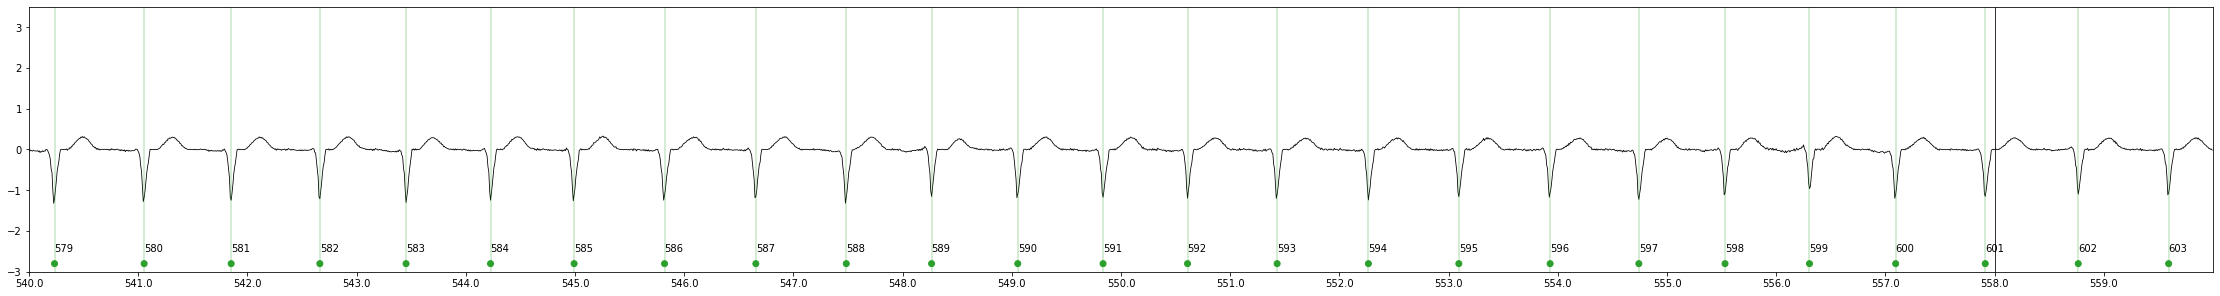

[32] Interval: 558.0 : 578.0 = 20.0 sec  Samples:[ 71424 : 73984 ] 	Nos Beats: (24,) [602 : 625]


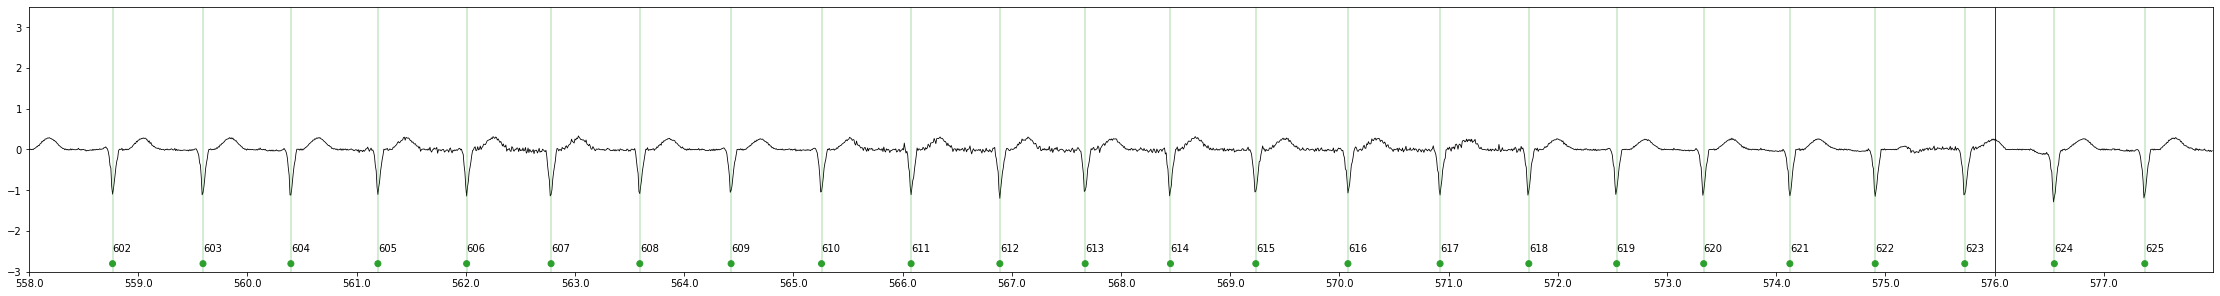

[33] Interval: 576.0 : 596.0 = 20.0 sec  Samples:[ 73728 : 76288 ] 	Nos Beats: (24,) [624 : 647]


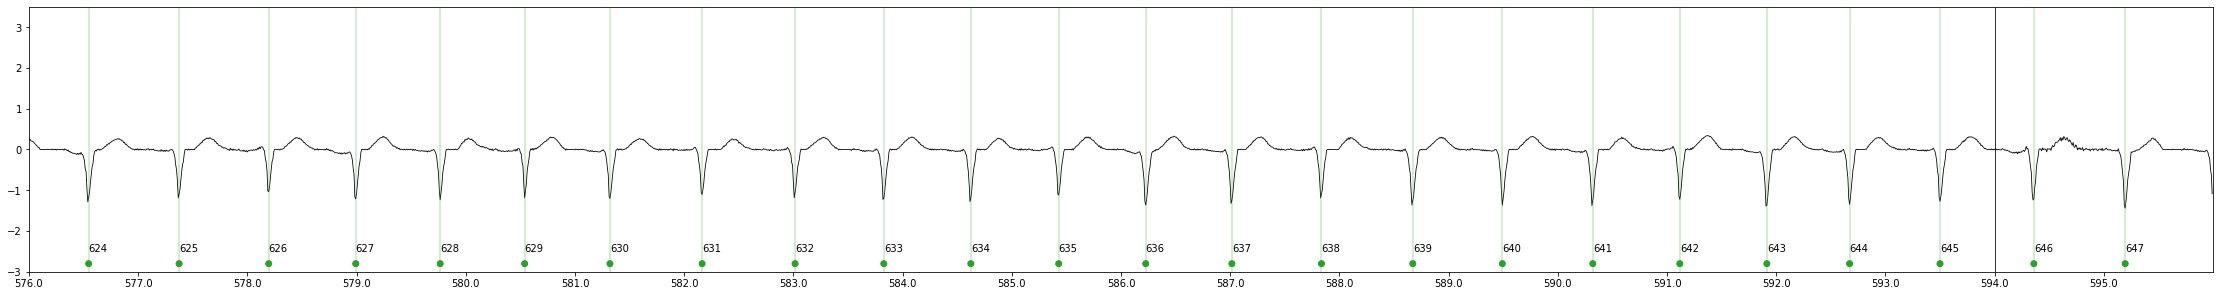

[34] Interval: 594.0 : 614.0 = 20.0 sec  Samples:[ 76032 : 78592 ] 	Nos Beats: (24,) [646 : 669]


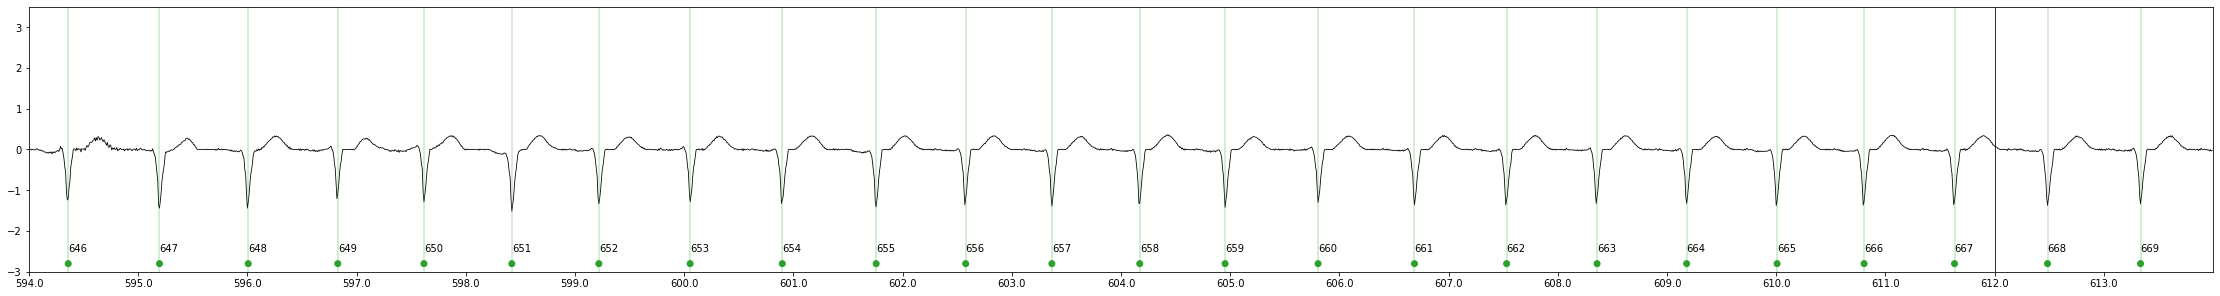

[35] Interval: 612.0 : 632.0 = 20.0 sec  Samples:[ 78336 : 80896 ] 	Nos Beats: (24,) [668 : 691]


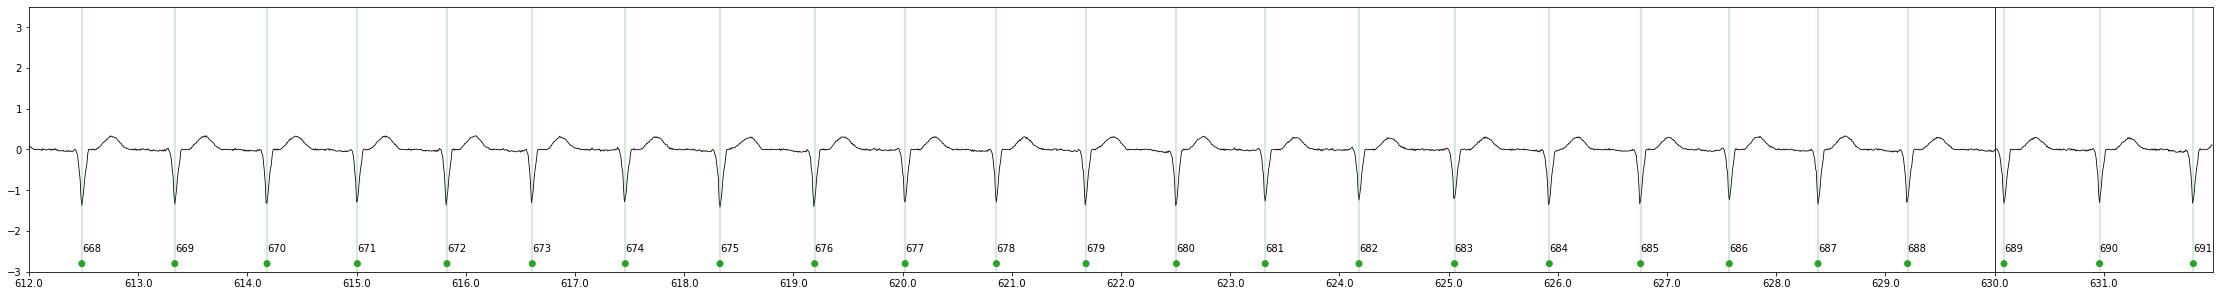

[36] Interval: 630.0 : 650.0 = 20.0 sec  Samples:[ 80640 : 83200 ] 	Nos Beats: (24,) [689 : 712]


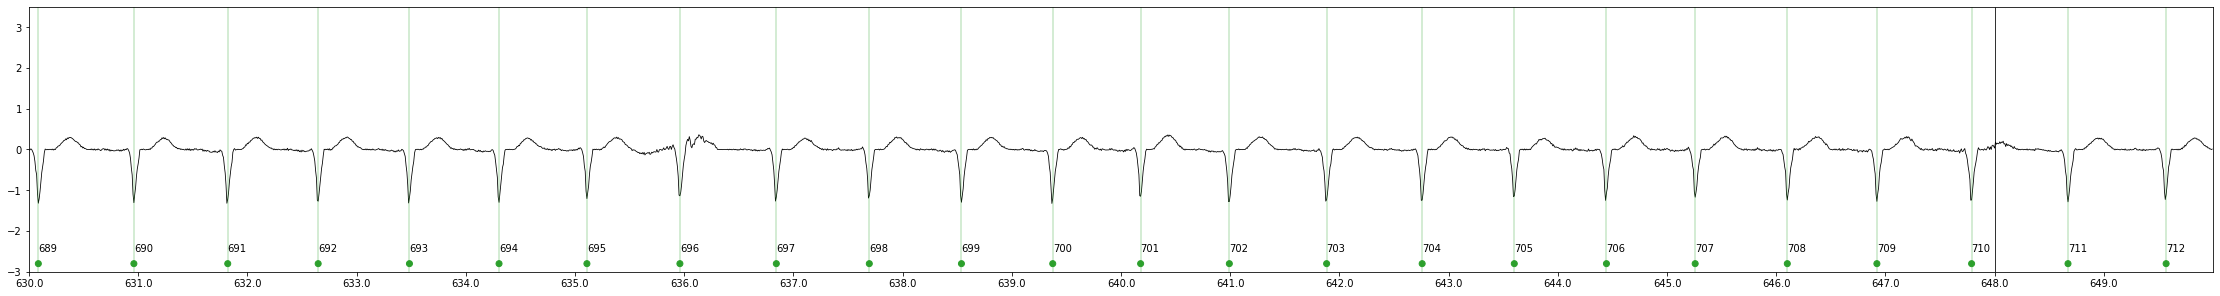

[37] Interval: 648.0 : 668.0 = 20.0 sec  Samples:[ 82944 : 85504 ] 	Nos Beats: (23,) [711 : 733]


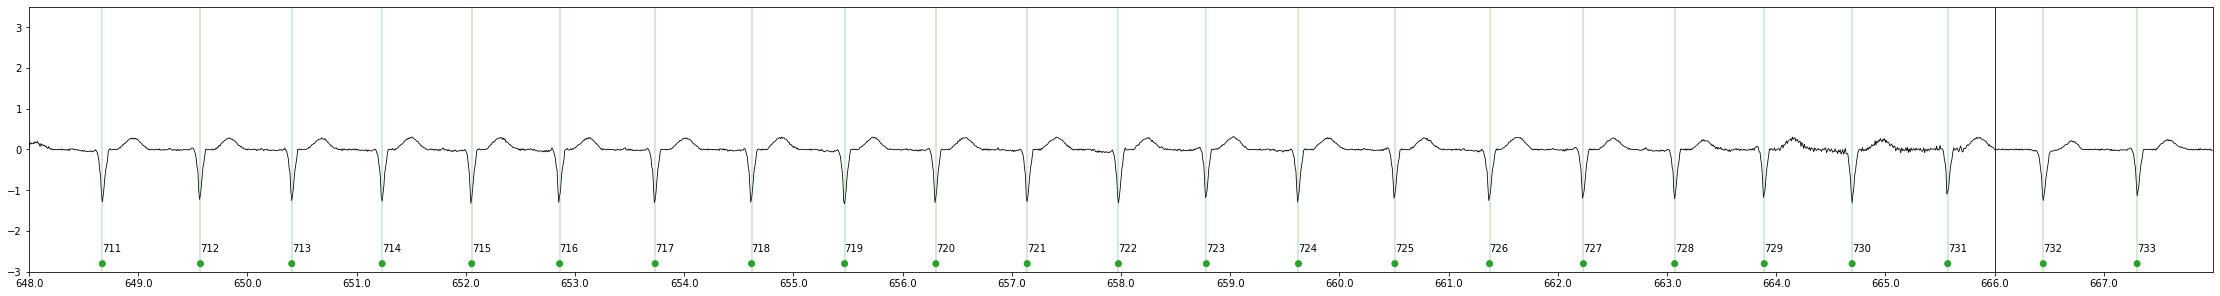

[38] Interval: 666.0 : 686.0 = 20.0 sec  Samples:[ 85248 : 87808 ] 	Nos Beats: (23,) [732 : 754]


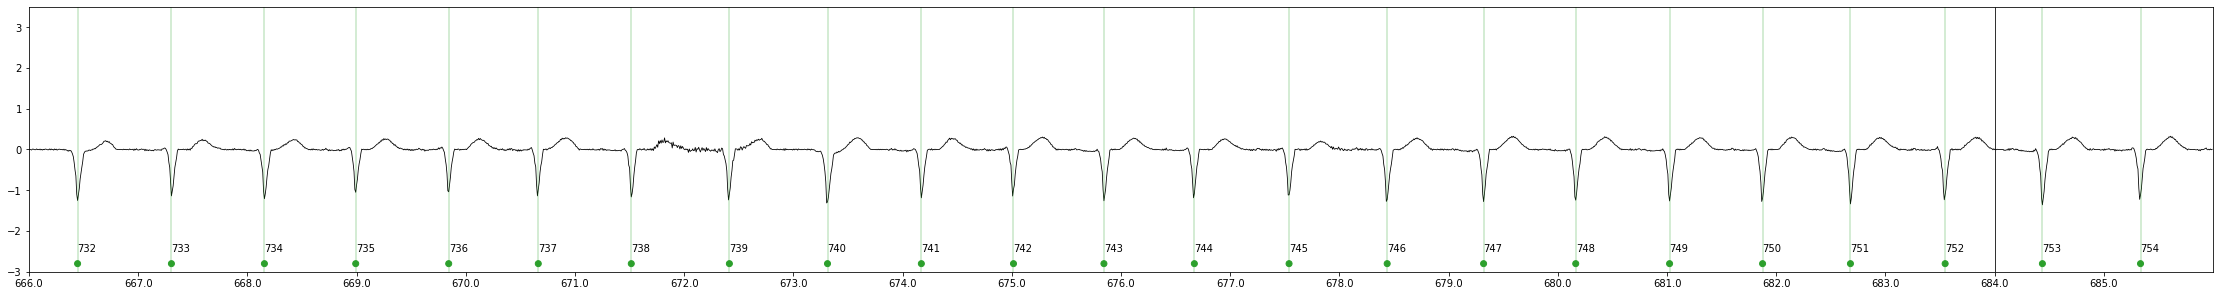

[39] Interval: 684.0 : 704.0 = 20.0 sec  Samples:[ 87552 : 90112 ] 	Nos Beats: (23,) [753 : 775]


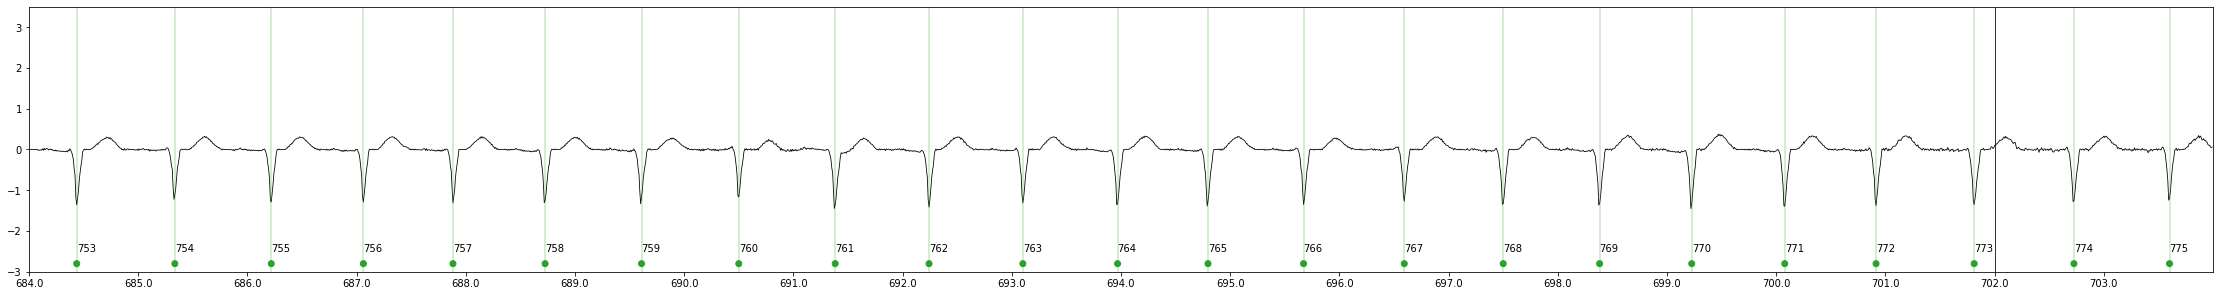

[40] Interval: 702.0 : 722.0 = 20.0 sec  Samples:[ 89856 : 92416 ] 	Nos Beats: (22,) [774 : 795]


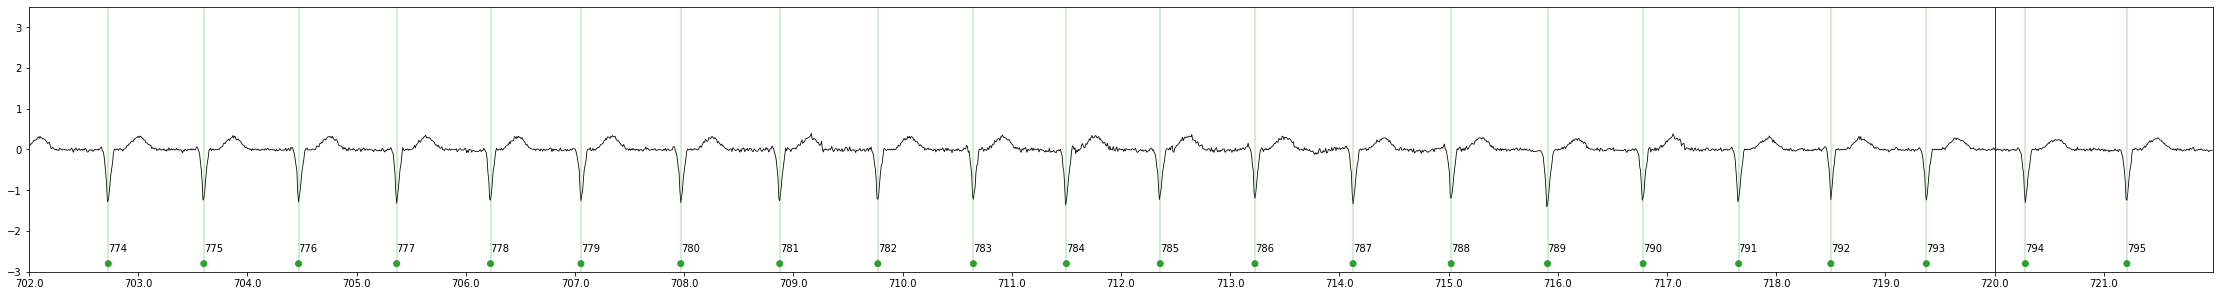

[41] Interval: 720.0 : 740.0 = 20.0 sec  Samples:[ 92160 : 94720 ] 	Nos Beats: (23,) [794 : 816]


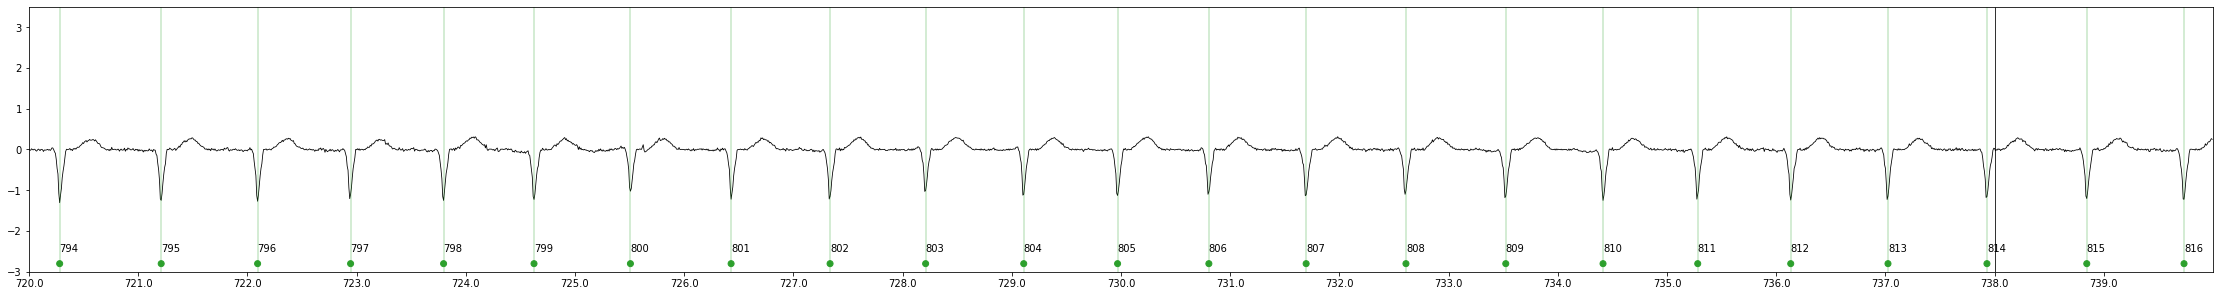

[42] Interval: 738.0 : 758.0 = 20.0 sec  Samples:[ 94464 : 97024 ] 	Nos Beats: (22,) [815 : 836]


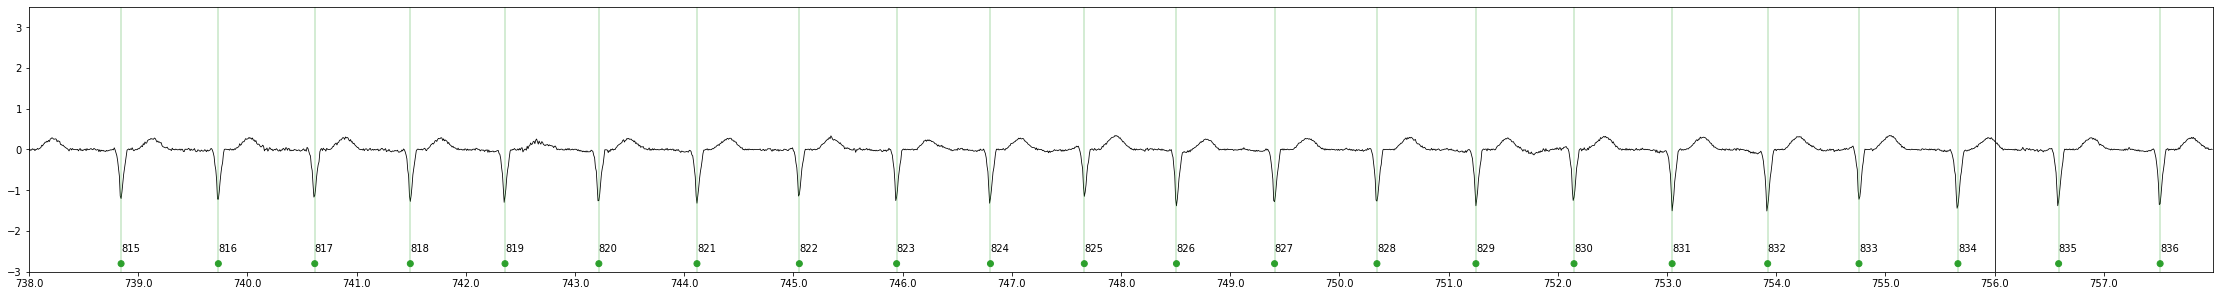

[43] Interval: 756.0 : 776.0 = 20.0 sec  Samples:[ 96768 : 99328 ] 	Nos Beats: (22,) [835 : 856]


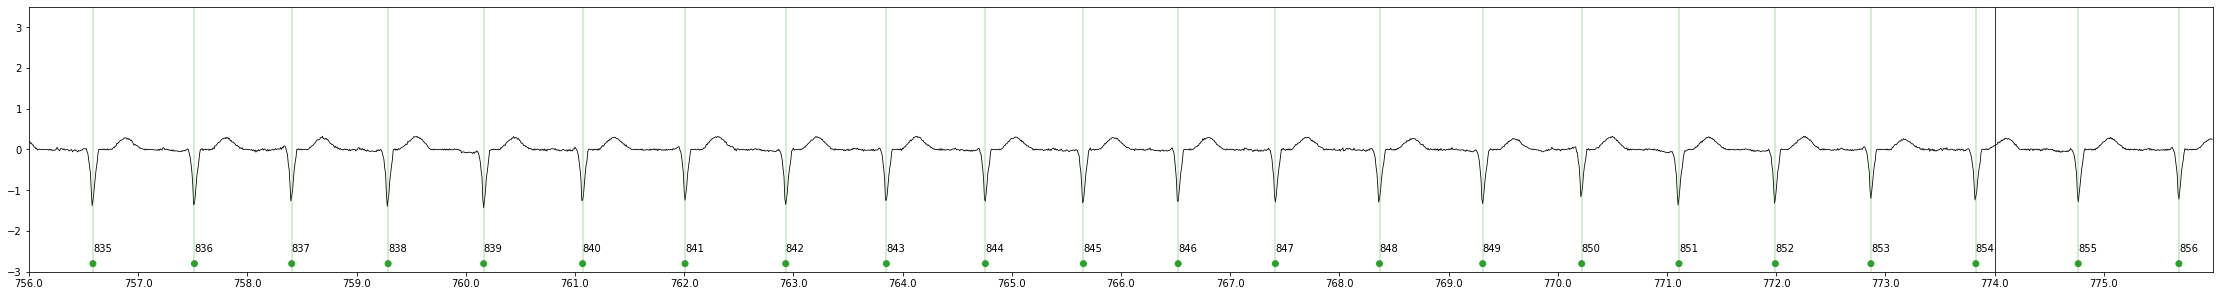

[44] Interval: 774.0 : 794.0 = 20.0 sec  Samples:[ 99072 : 101632 ] 	Nos Beats: (21,) [855 : 875]


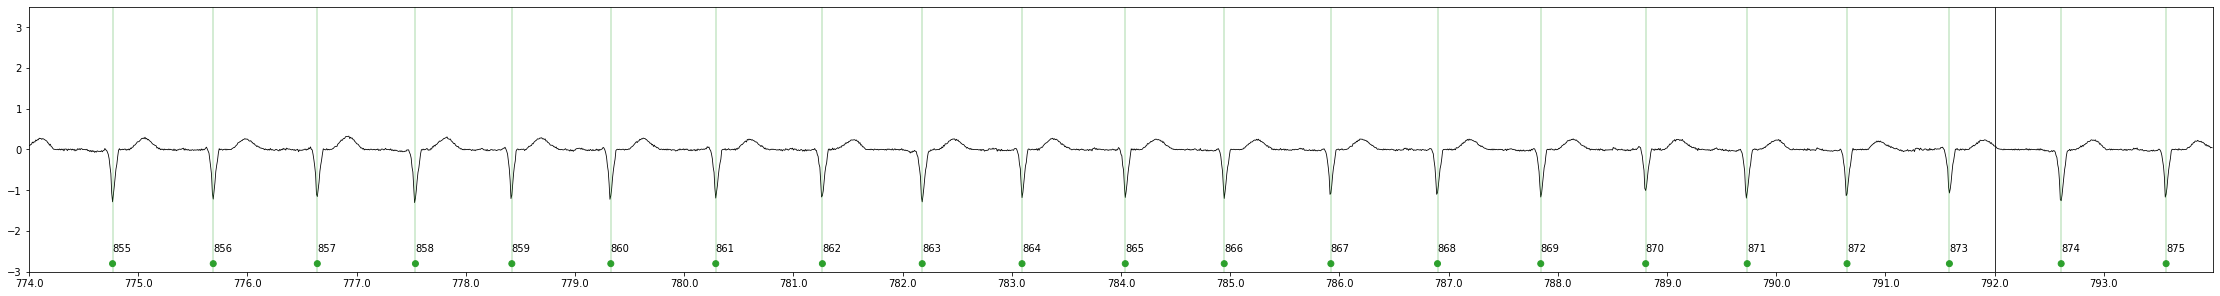

[45] Interval: 792.0 : 812.0 = 20.0 sec  Samples:[ 101376 : 103936 ] 	Nos Beats: (21,) [874 : 894]


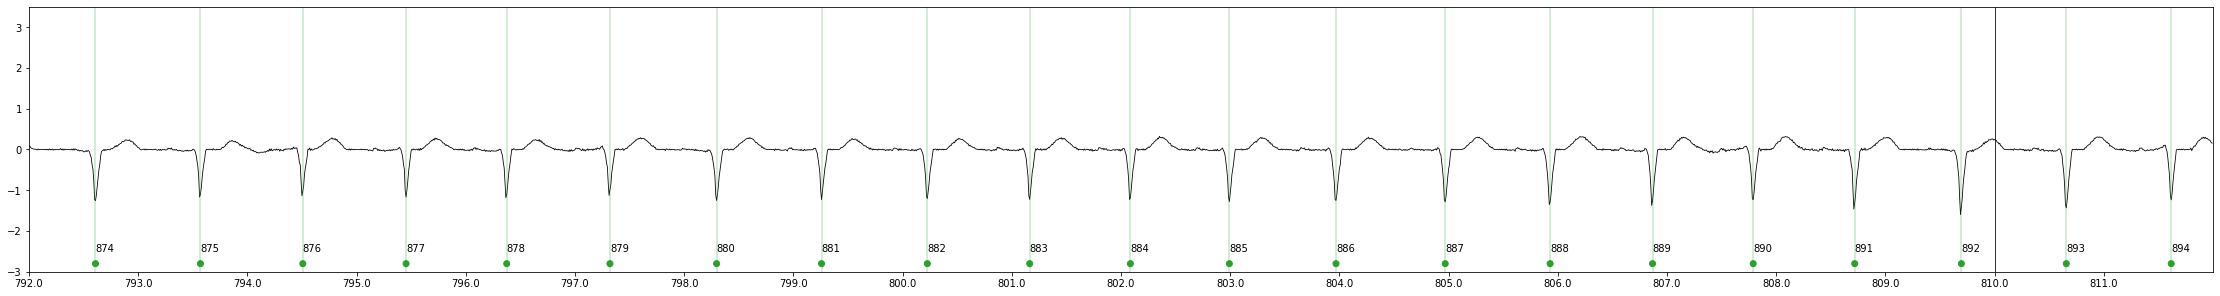

[46] Interval: 810.0 : 830.0 = 20.0 sec  Samples:[ 103680 : 106240 ] 	Nos Beats: (21,) [893 : 913]


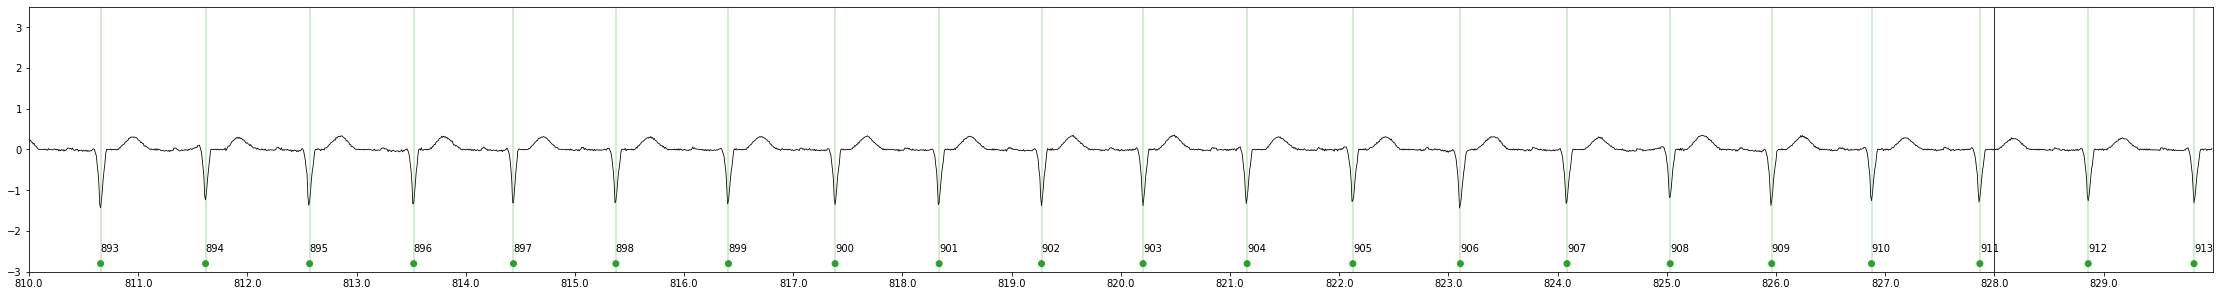

[47] Interval: 828.0 : 848.0 = 20.0 sec  Samples:[ 105984 : 108544 ] 	Nos Beats: (20,) [912 : 931]


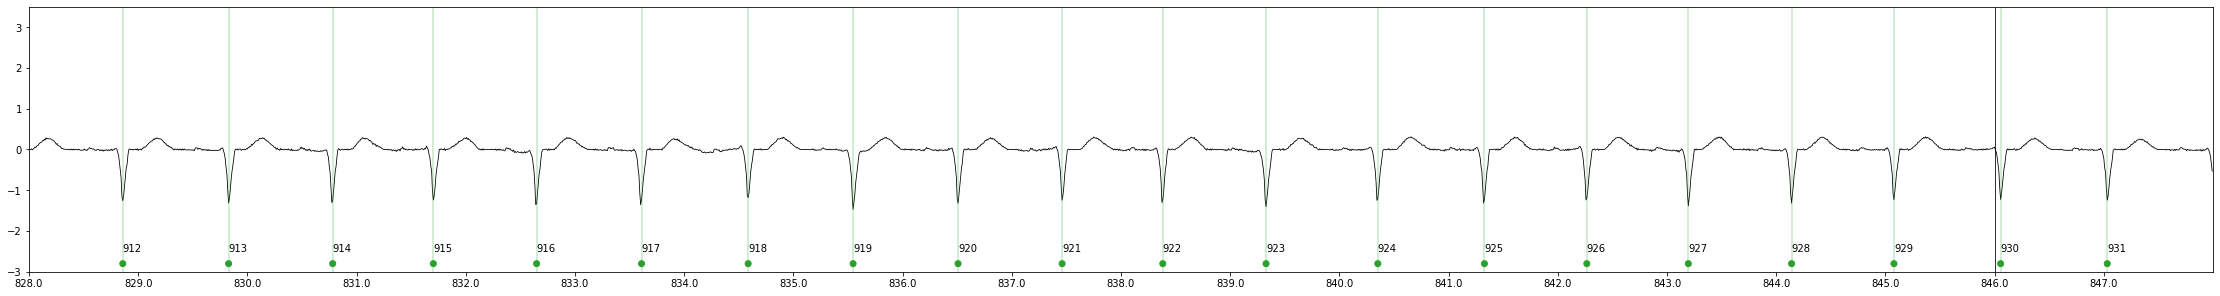

[48] Interval: 846.0 : 866.0 = 20.0 sec  Samples:[ 108288 : 110848 ] 	Nos Beats: (21,) [930 : 950]


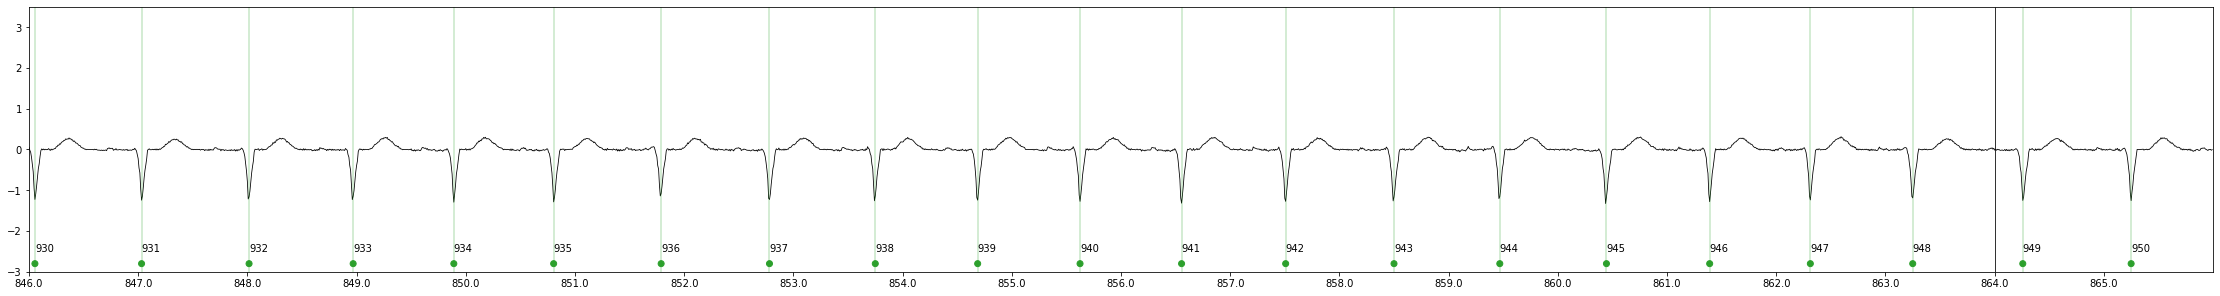

[49] Interval: 864.0 : 884.0 = 20.0 sec  Samples:[ 110592 : 113152 ] 	Nos Beats: (21,) [949 : 969]


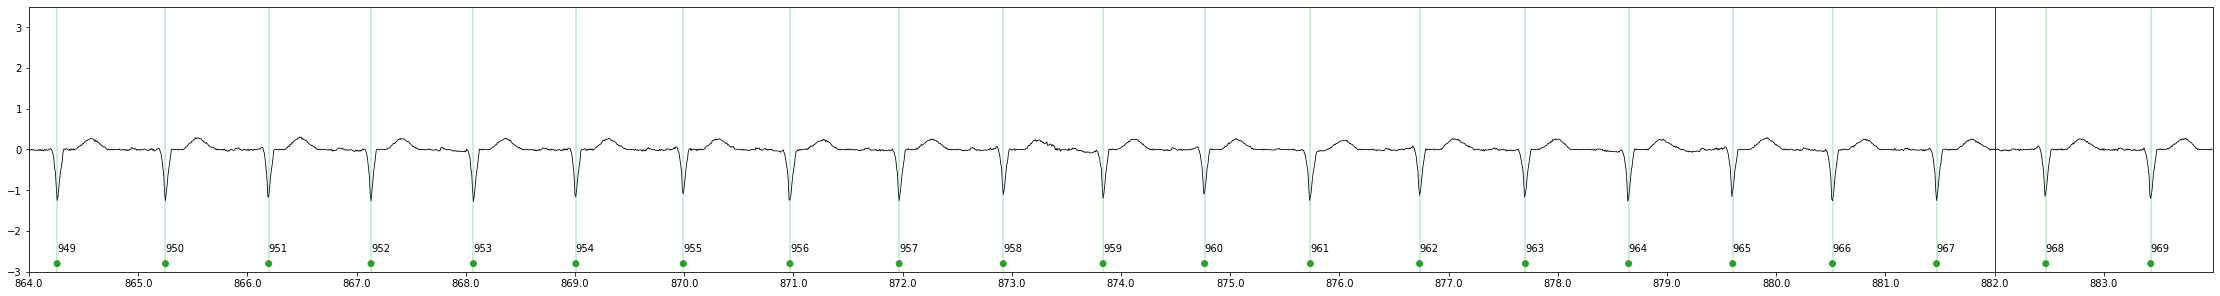

[50] Interval: 882.0 : 902.0 = 20.0 sec  Samples:[ 112896 : 115456 ] 	Nos Beats: (21,) [968 : 988]


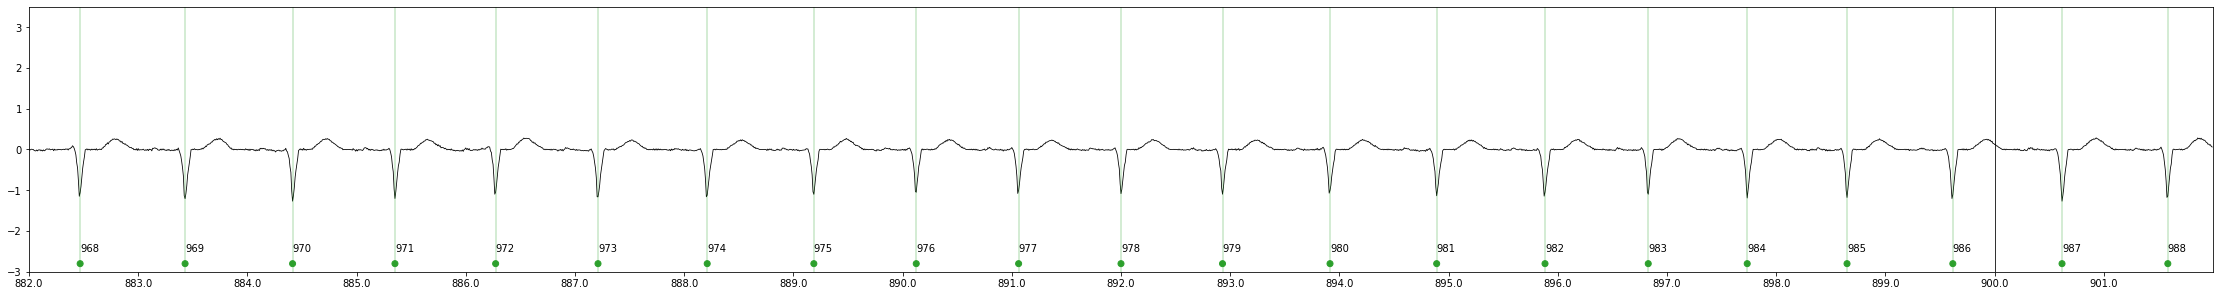

[51] Interval: 900.0 : 920.0 = 20.0 sec  Samples:[ 115200 : 117760 ] 	Nos Beats: (21,) [987 : 1007]


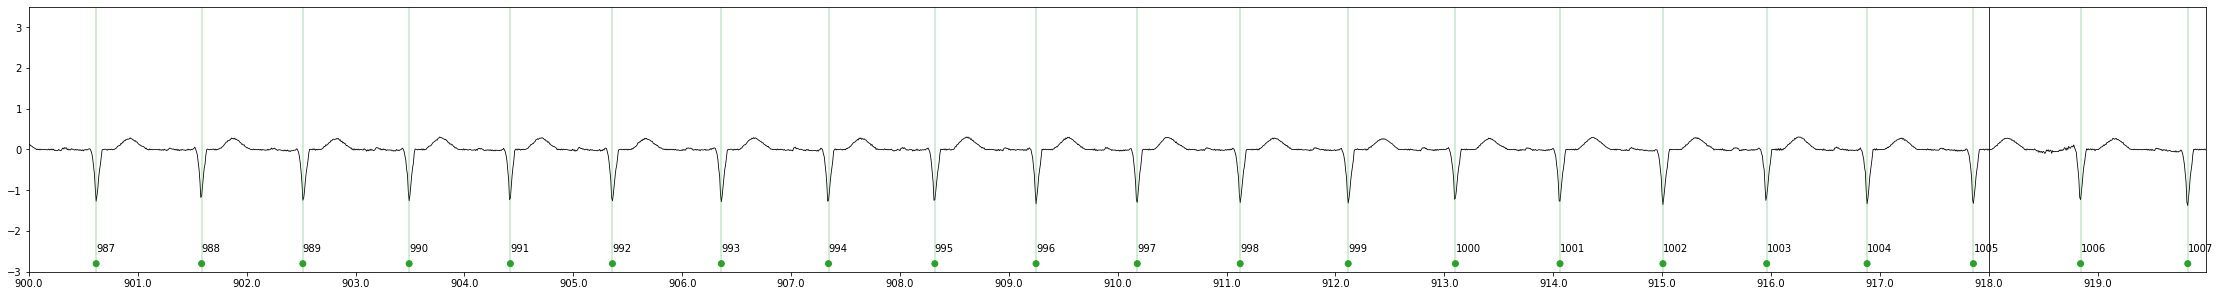

[52] Interval: 918.0 : 938.0 = 20.0 sec  Samples:[ 117504 : 120064 ] 	Nos Beats: (21,) [1006 : 1026]


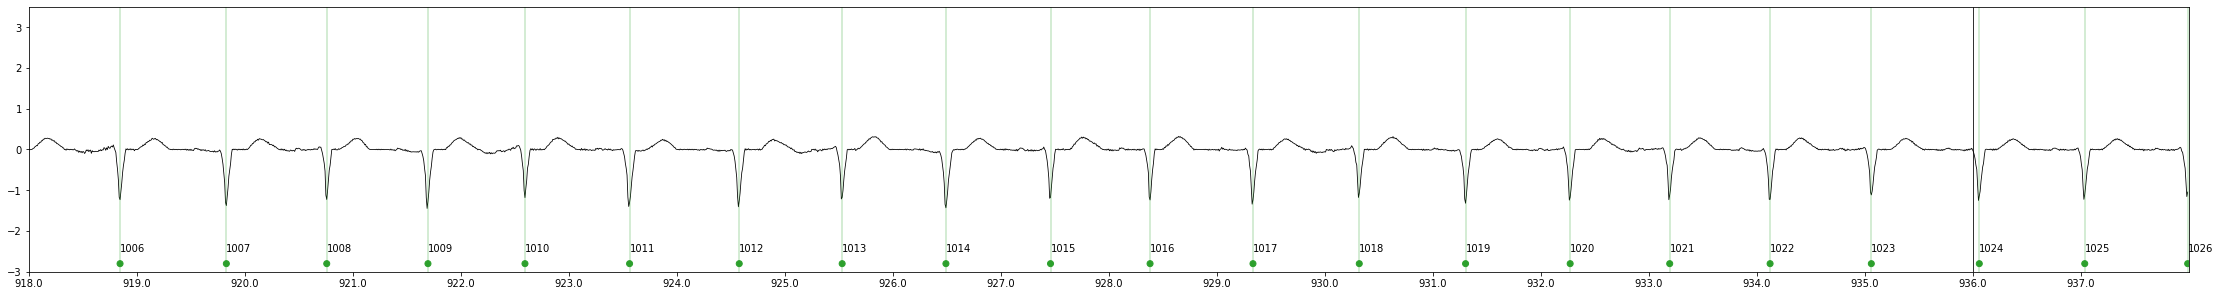

[53] Interval: 936.0 : 956.0 = 20.0 sec  Samples:[ 119808 : 122368 ] 	Nos Beats: (21,) [1024 : 1044]


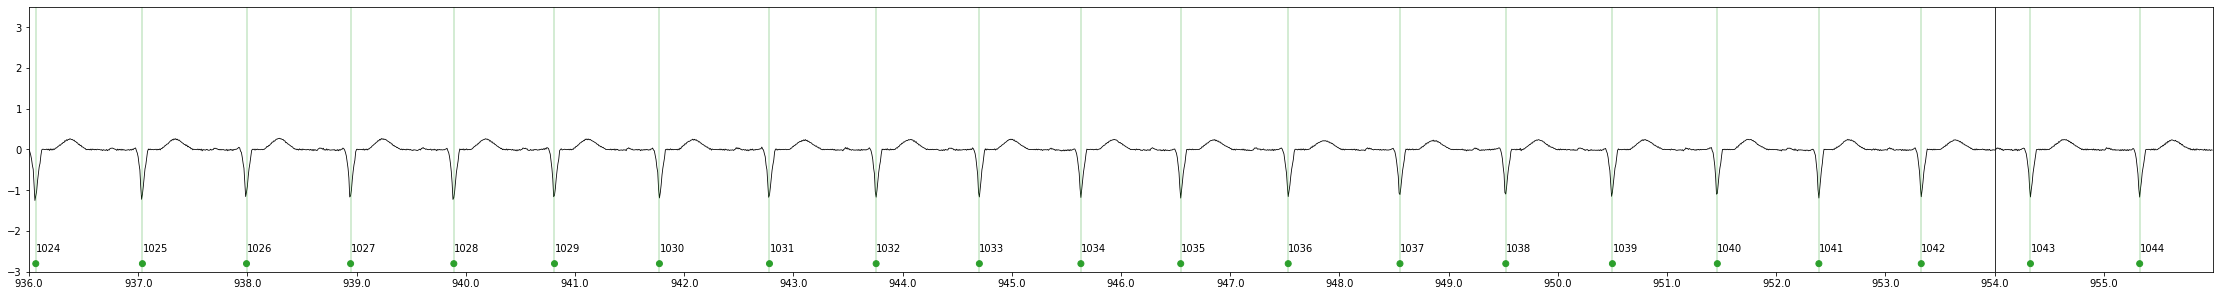

[54] Interval: 954.0 : 974.0 = 20.0 sec  Samples:[ 122112 : 124672 ] 	Nos Beats: (21,) [1043 : 1063]


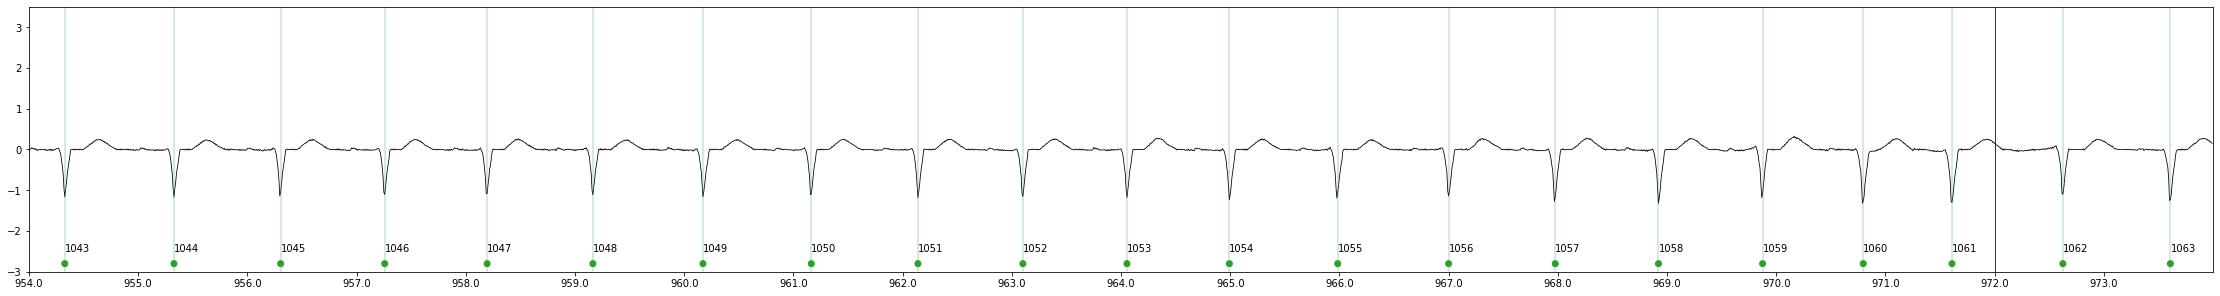

[55] Interval: 972.0 : 992.0 = 20.0 sec  Samples:[ 124416 : 126976 ] 	Nos Beats: (20,) [1062 : 1081]


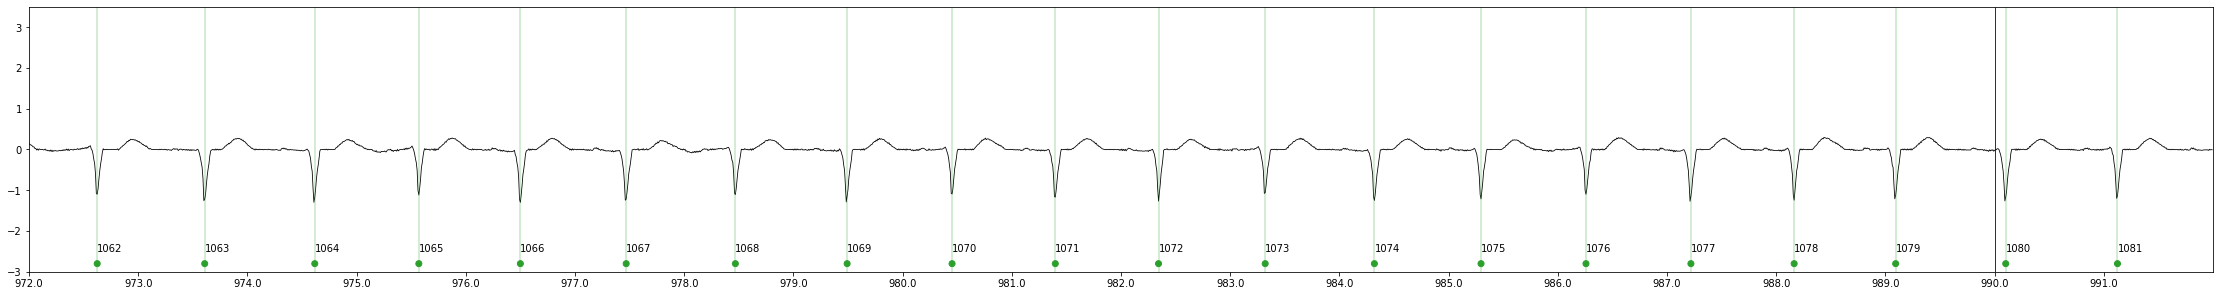

[56] Interval: 990.0 : 1010.0 = 20.0 sec  Samples:[ 126720 : 129280 ] 	Nos Beats: (21,) [1080 : 1100]


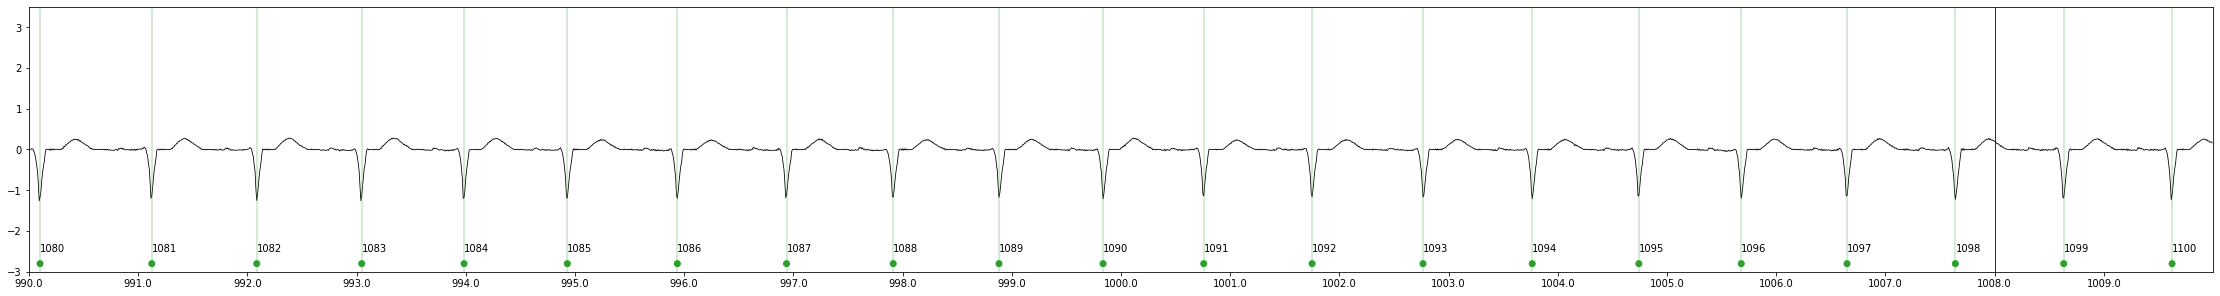

[57] Interval: 1008.0 : 1028.0 = 20.0 sec  Samples:[ 129024 : 131584 ] 	Nos Beats: (20,) [1099 : 1118]


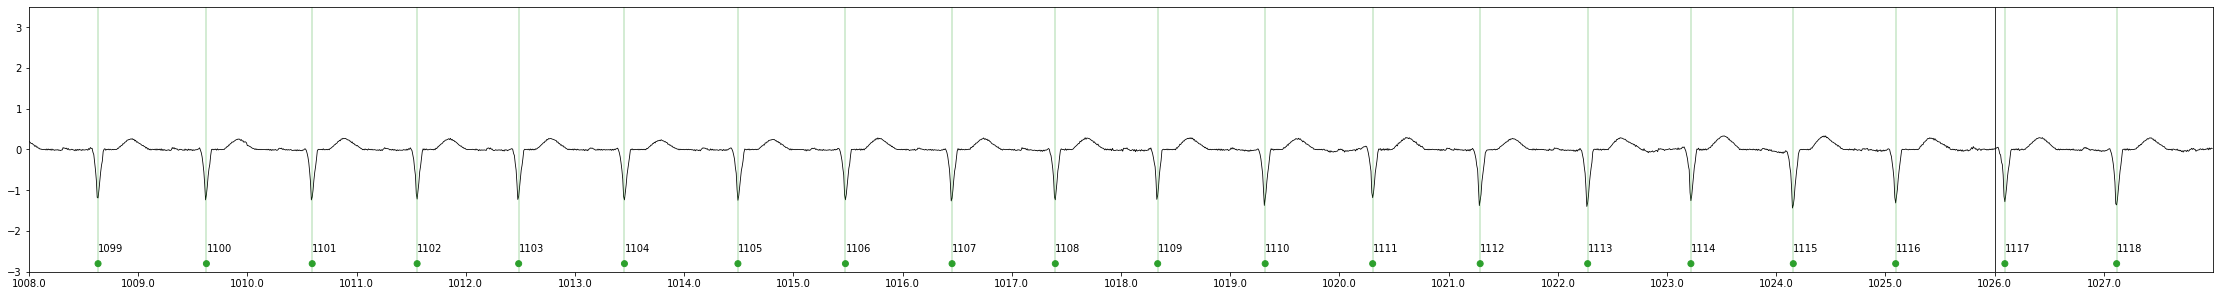

[58] Interval: 1026.0 : 1046.0 = 20.0 sec  Samples:[ 131328 : 133888 ] 	Nos Beats: (21,) [1117 : 1137]


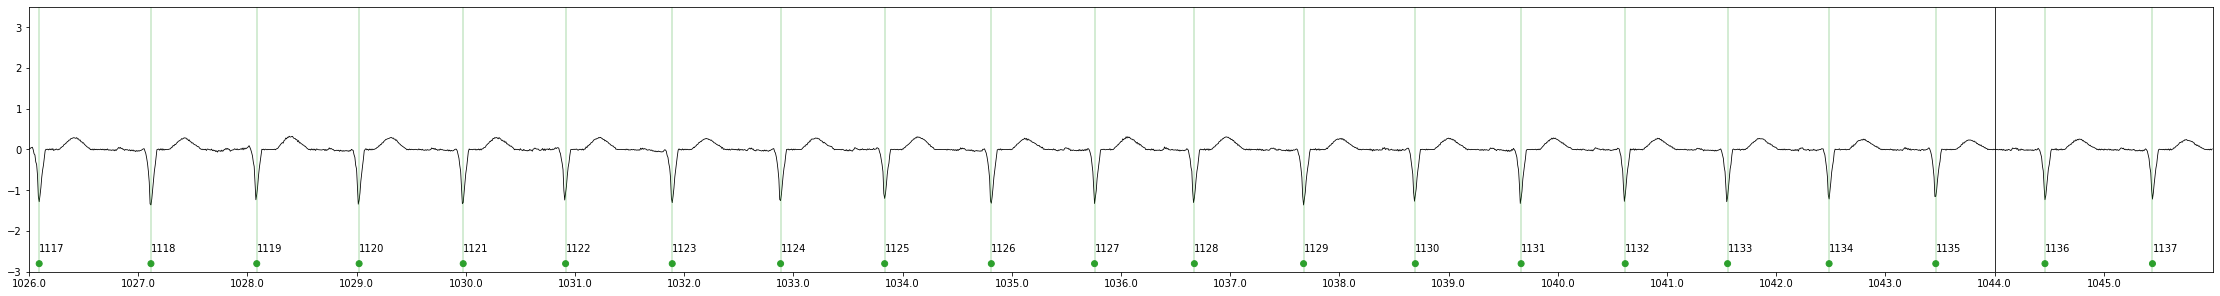

[59] Interval: 1044.0 : 1064.0 = 20.0 sec  Samples:[ 133632 : 136192 ] 	Nos Beats: (21,) [1136 : 1156]


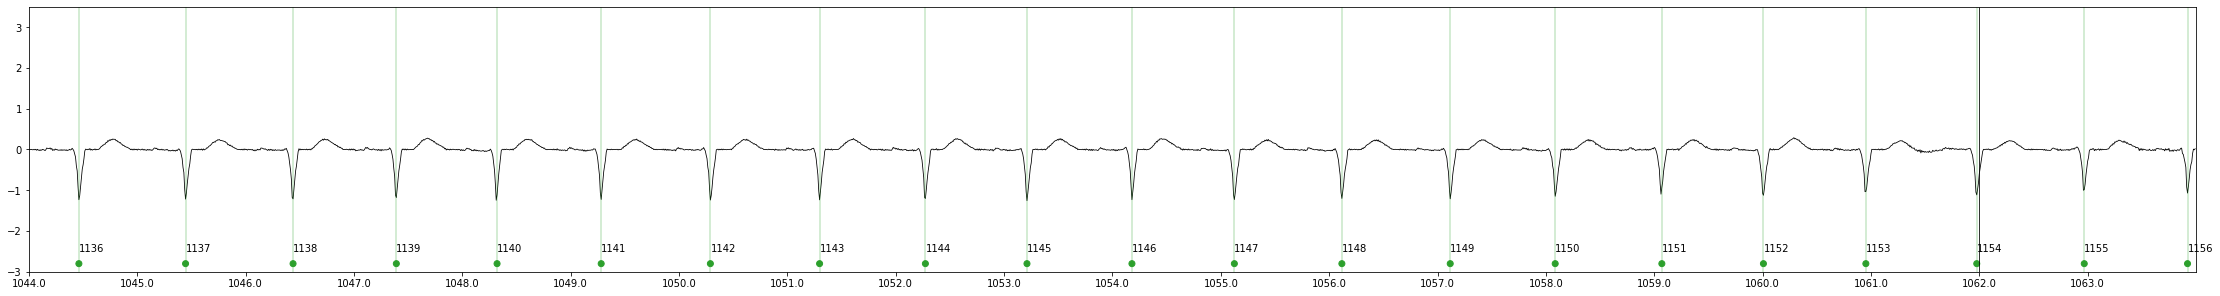

[60] Interval: 1062.0 : 1082.0 = 20.0 sec  Samples:[ 135936 : 138496 ] 	Nos Beats: (20,) [1155 : 1174]


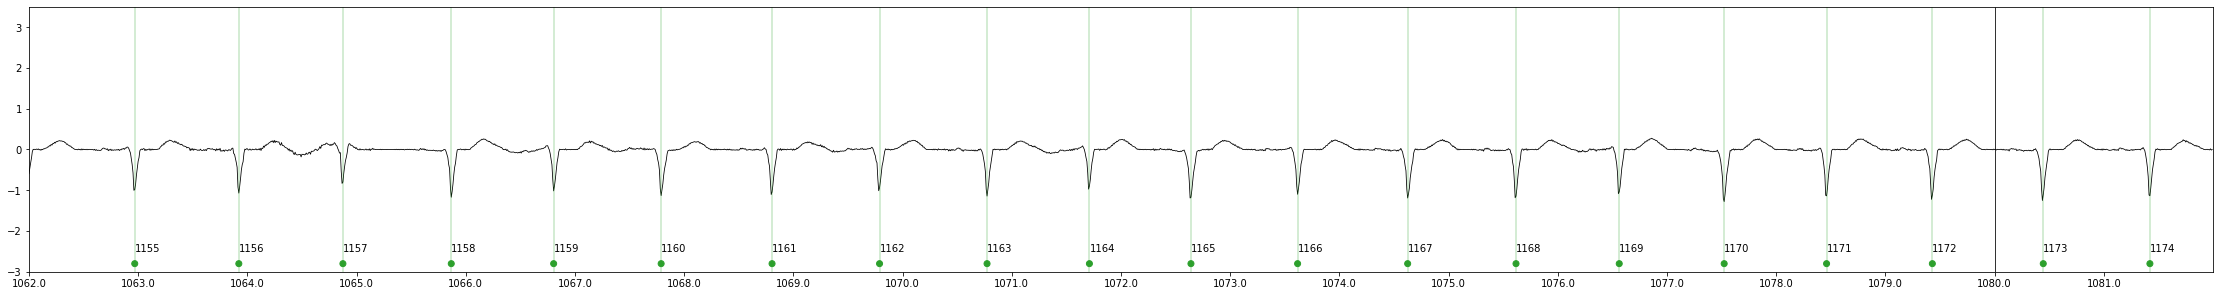

[61] Interval: 1080.0 : 1100.0 = 20.0 sec  Samples:[ 138240 : 140800 ] 	Nos Beats: (21,) [1173 : 1193]


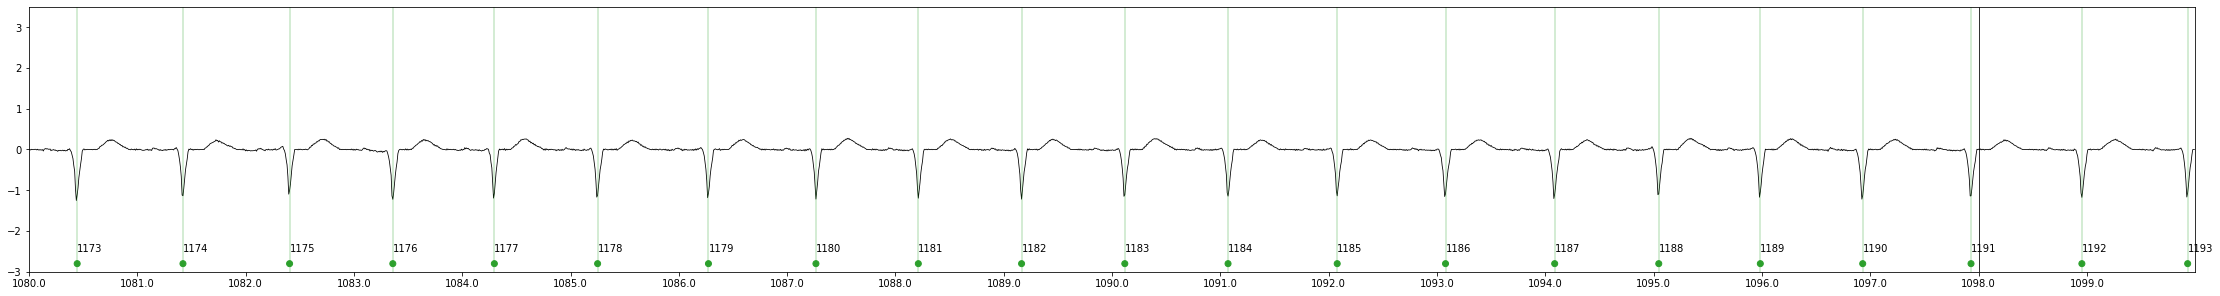

[62] Interval: 1098.0 : 1118.0 = 20.0 sec  Samples:[ 140544 : 143104 ] 	Nos Beats: (20,) [1192 : 1211]


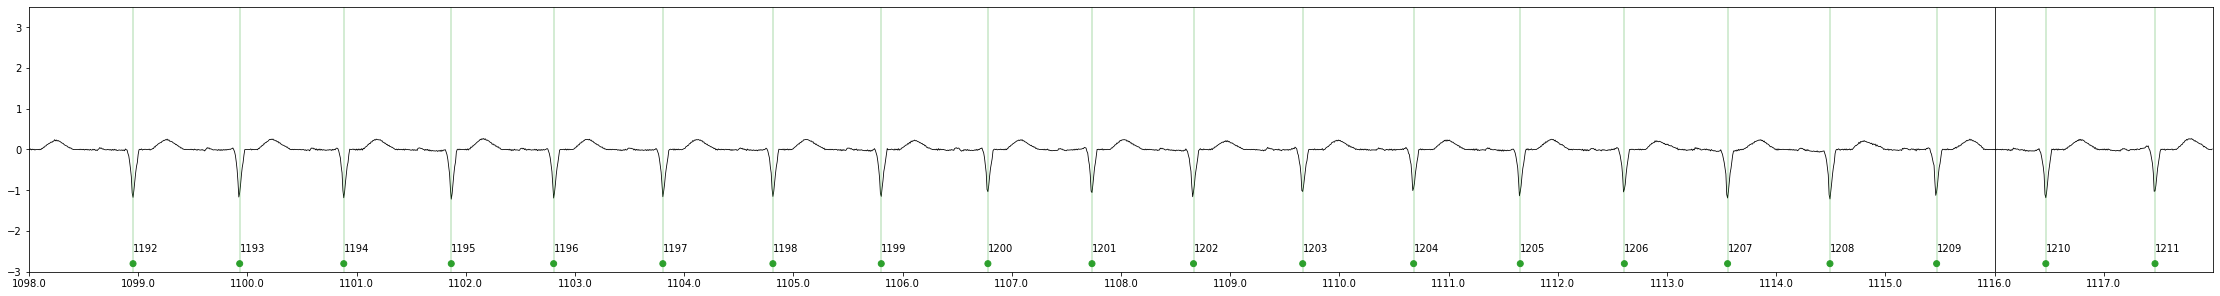

[63] Interval: 1116.0 : 1136.0 = 20.0 sec  Samples:[ 142848 : 145408 ] 	Nos Beats: (21,) [1210 : 1230]


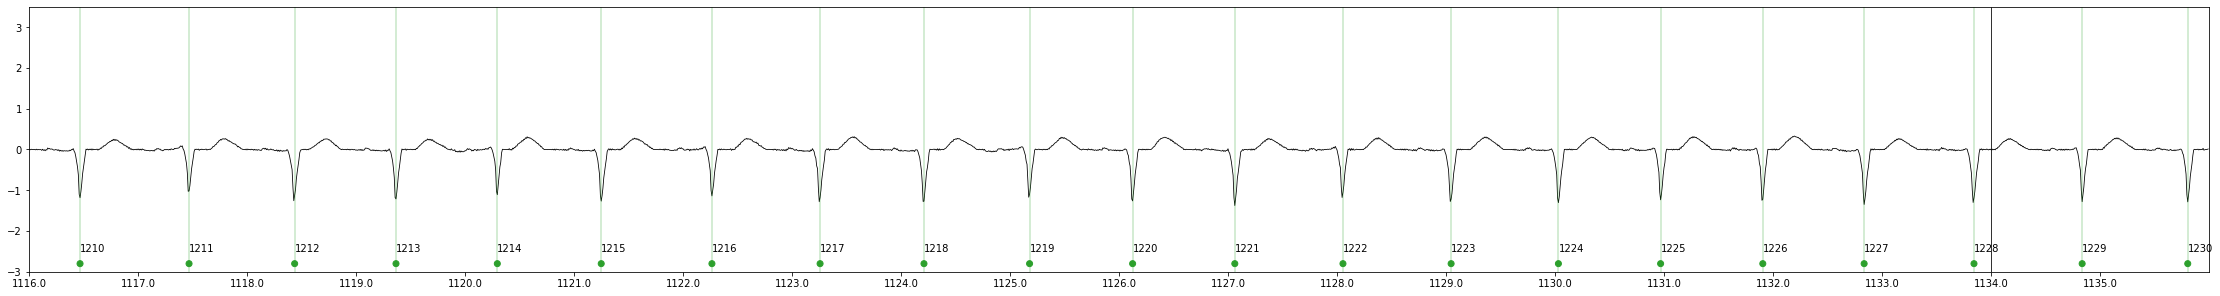

[64] Interval: 1134.0 : 1154.0 = 20.0 sec  Samples:[ 145152 : 147712 ] 	Nos Beats: (20,) [1229 : 1248]


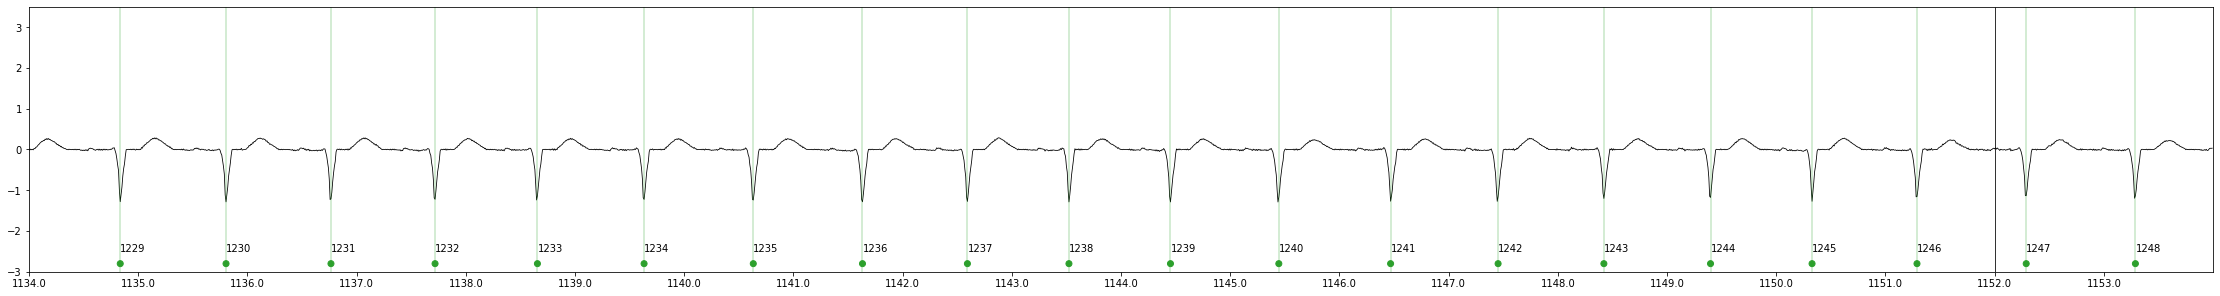

[65] Interval: 1152.0 : 1172.0 = 20.0 sec  Samples:[ 147456 : 150016 ] 	Nos Beats: (21,) [1247 : 1267]


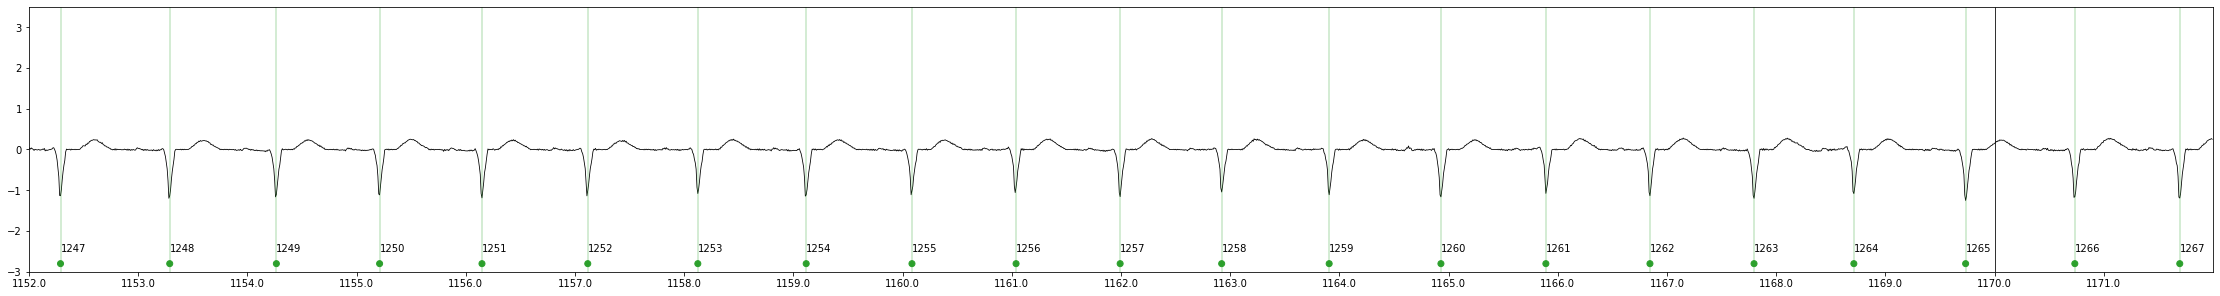

[66] Interval: 1170.0 : 1190.0 = 20.0 sec  Samples:[ 149760 : 152320 ] 	Nos Beats: (20,) [1266 : 1285]


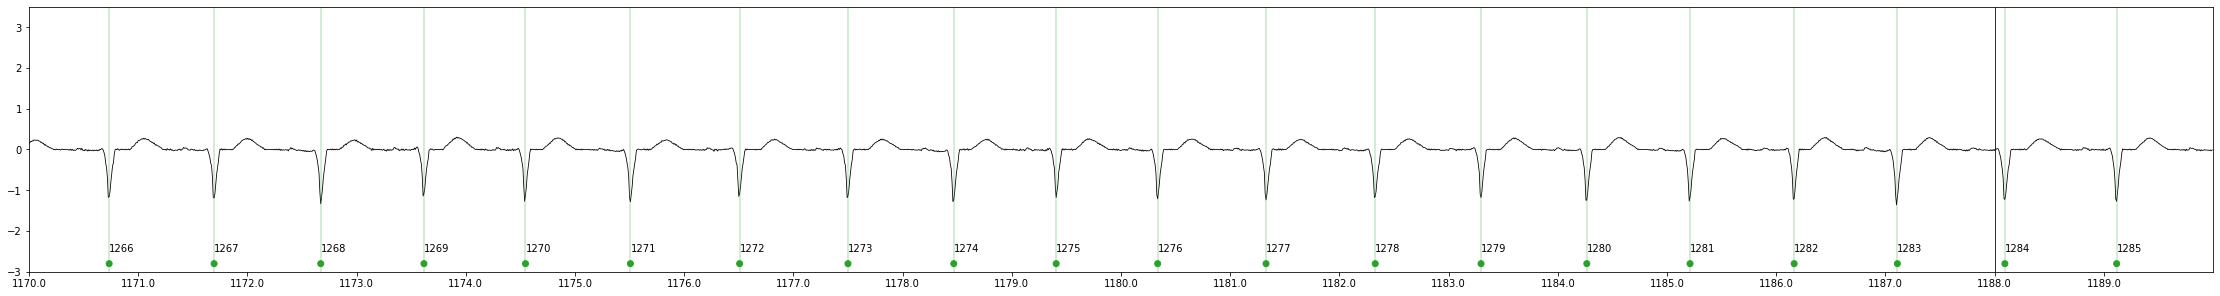

[67] Interval: 1188.0 : 1208.0 = 20.0 sec  Samples:[ 152064 : 154624 ] 	Nos Beats: (21,) [1284 : 1304]


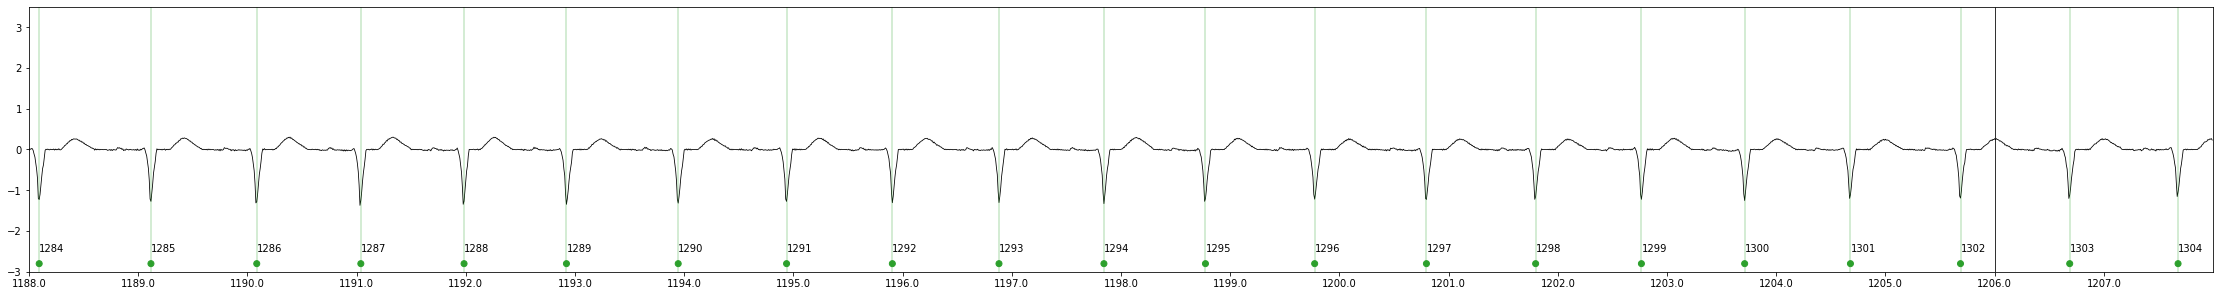

[68] Interval: 1206.0 : 1226.0 = 20.0 sec  Samples:[ 154368 : 156928 ] 	Nos Beats: (20,) [1303 : 1322]


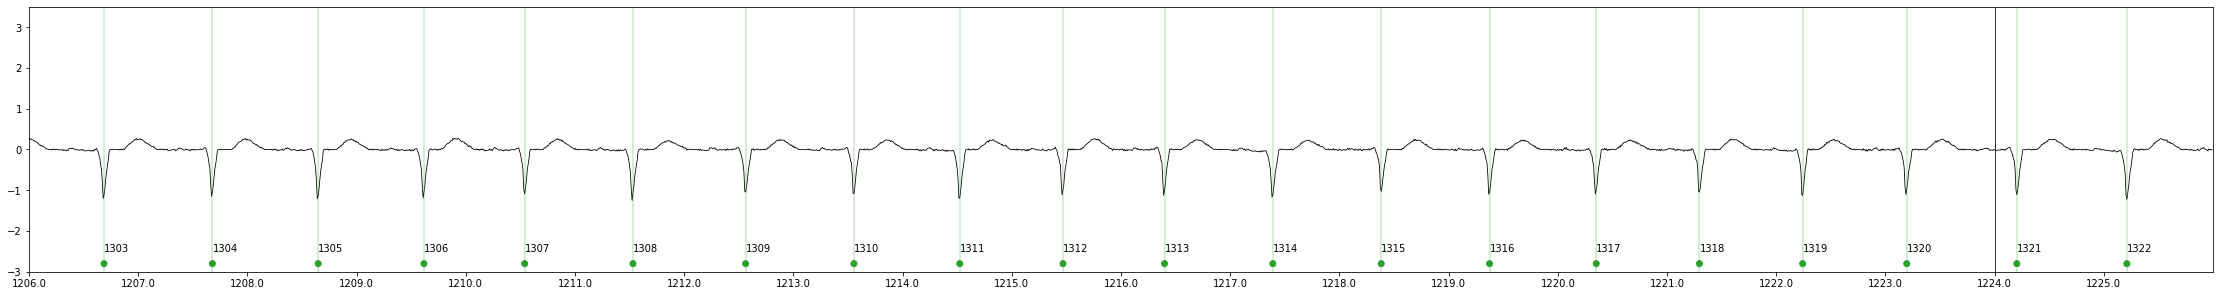

[69] Interval: 1224.0 : 1244.0 = 20.0 sec  Samples:[ 156672 : 159232 ] 	Nos Beats: (21,) [1321 : 1341]


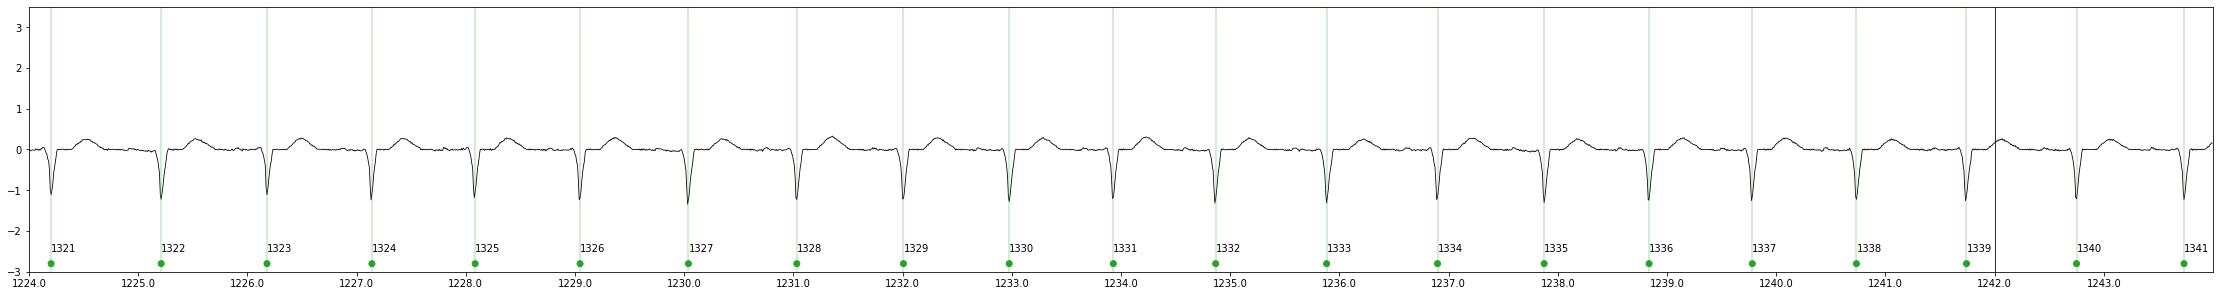

[70] Interval: 1242.0 : 1262.0 = 20.0 sec  Samples:[ 158976 : 161536 ] 	Nos Beats: (20,) [1340 : 1359]


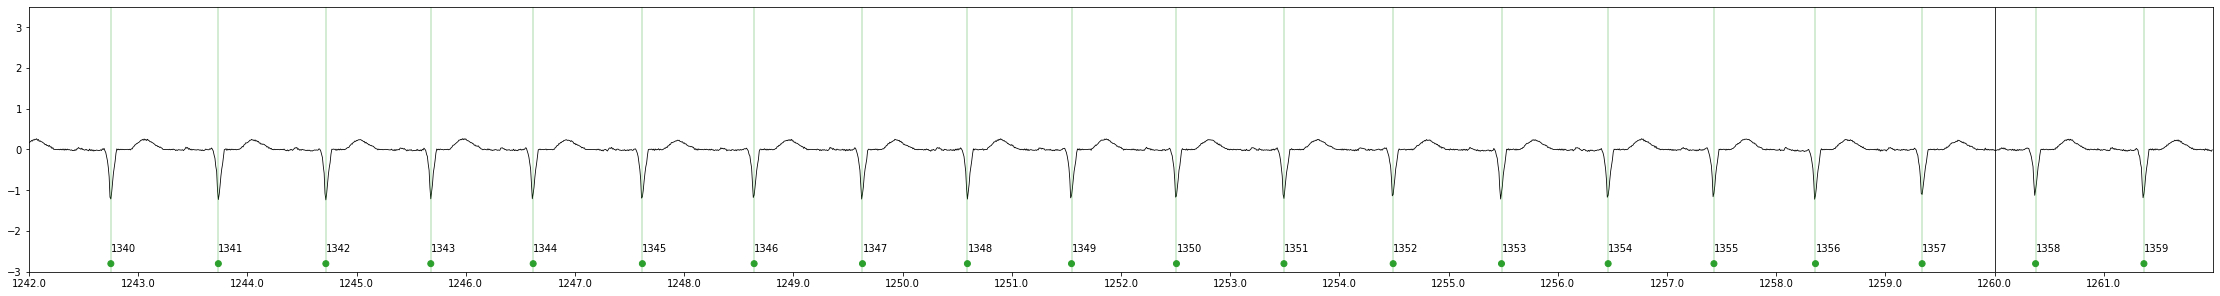

[71] Interval: 1260.0 : 1280.0 = 20.0 sec  Samples:[ 161280 : 163840 ] 	Nos Beats: (21,) [1358 : 1378]


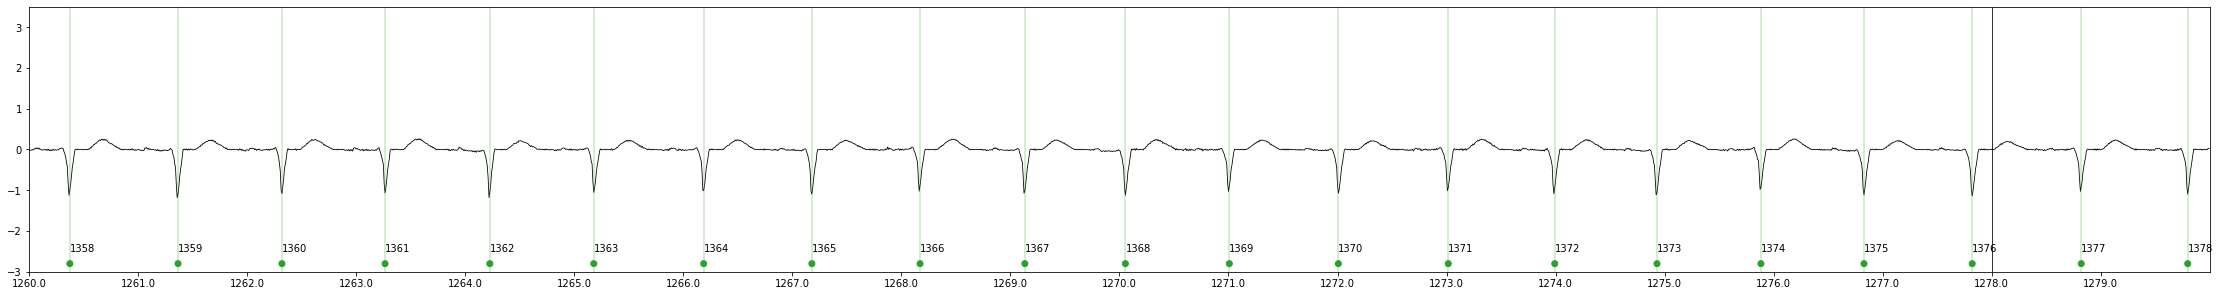

[72] Interval: 1278.0 : 1298.0 = 20.0 sec  Samples:[ 163584 : 166144 ] 	Nos Beats: (20,) [1377 : 1396]


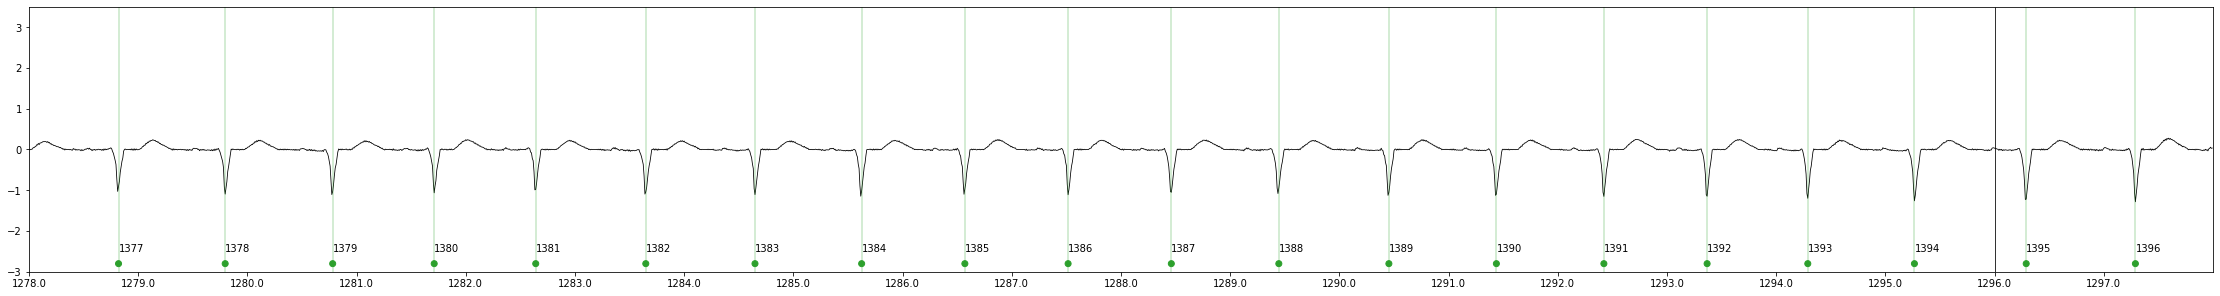

[73] Interval: 1296.0 : 1316.0 = 20.0 sec  Samples:[ 165888 : 168448 ] 	Nos Beats: (21,) [1395 : 1415]


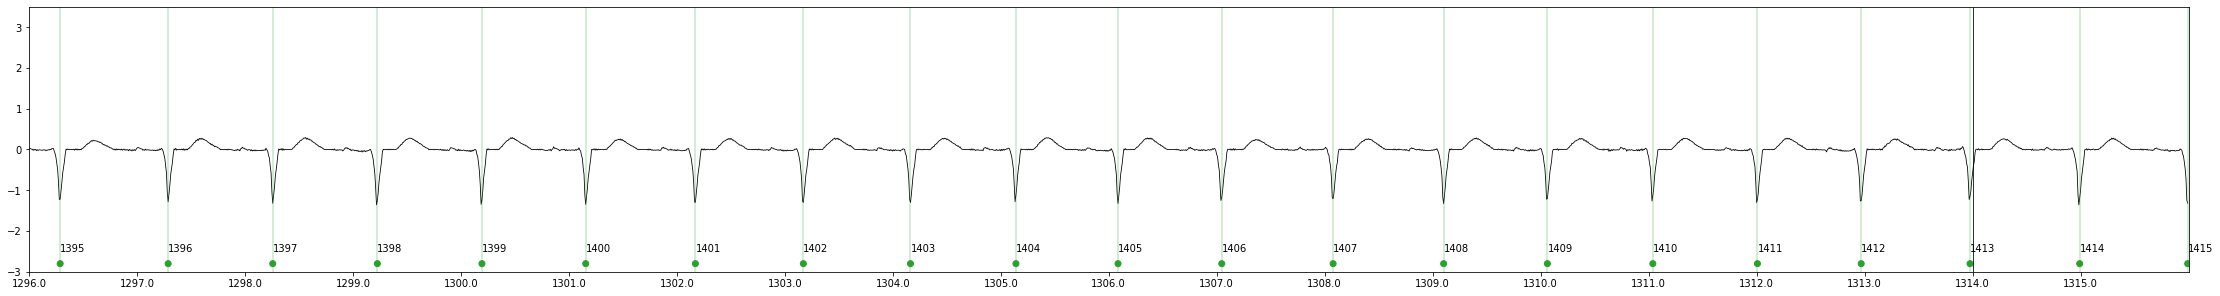

[74] Interval: 1314.0 : 1334.0 = 20.0 sec  Samples:[ 168192 : 170752 ] 	Nos Beats: (20,) [1414 : 1433]


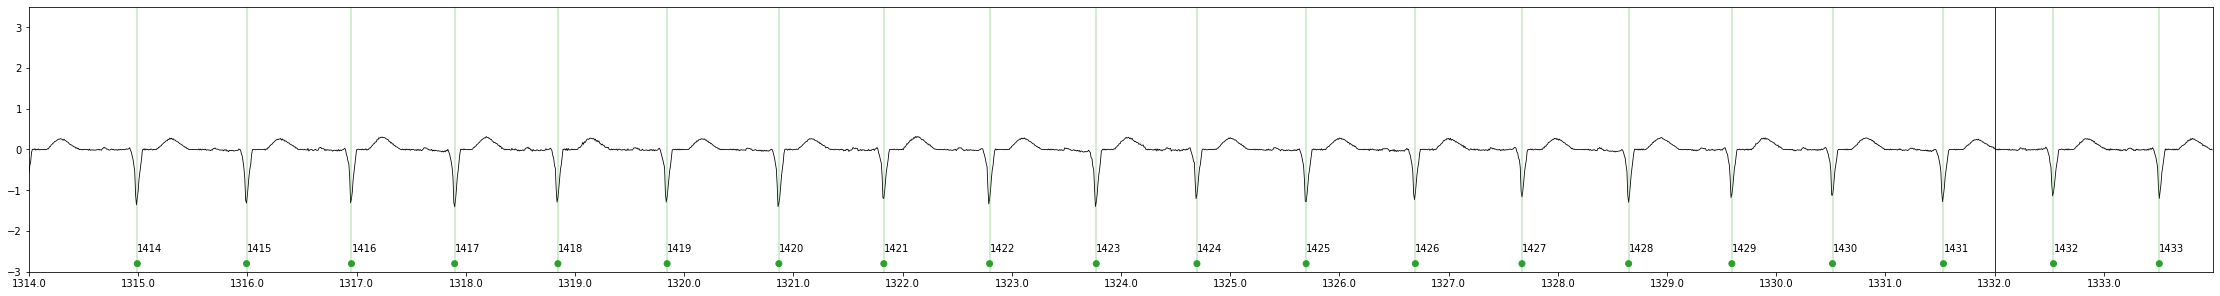

[75] Interval: 1332.0 : 1352.0 = 20.0 sec  Samples:[ 170496 : 173056 ] 	Nos Beats: (20,) [1432 : 1451]


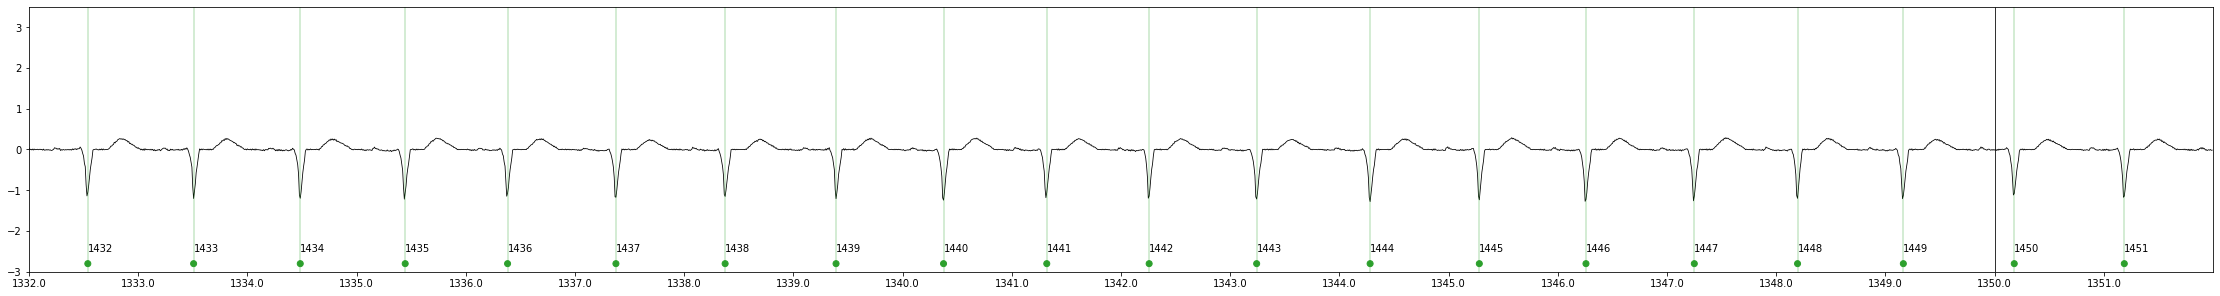

[76] Interval: 1350.0 : 1370.0 = 20.0 sec  Samples:[ 172800 : 175360 ] 	Nos Beats: (21,) [1450 : 1470]


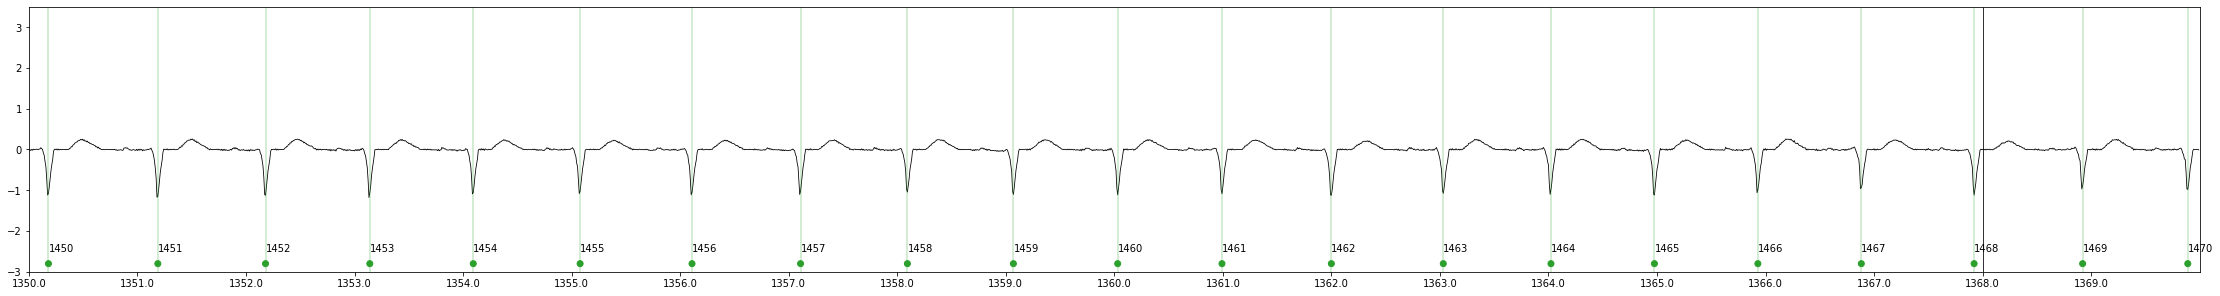

[77] Interval: 1368.0 : 1388.0 = 20.0 sec  Samples:[ 175104 : 177664 ] 	Nos Beats: (20,) [1469 : 1488]


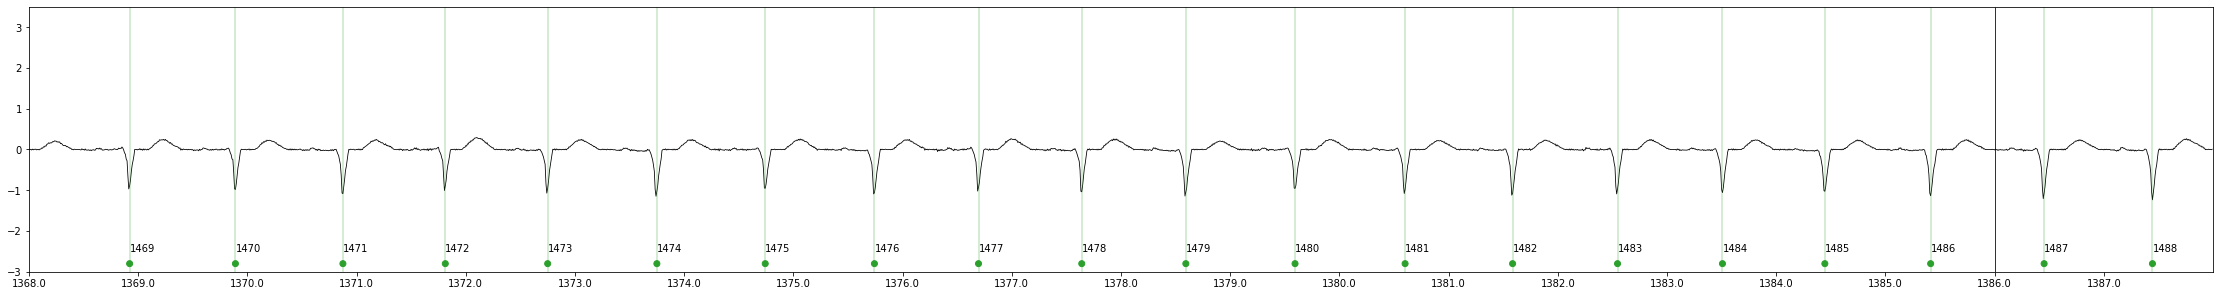

[78] Interval: 1386.0 : 1406.0 = 20.0 sec  Samples:[ 177408 : 179968 ] 	Nos Beats: (20,) [1487 : 1506]


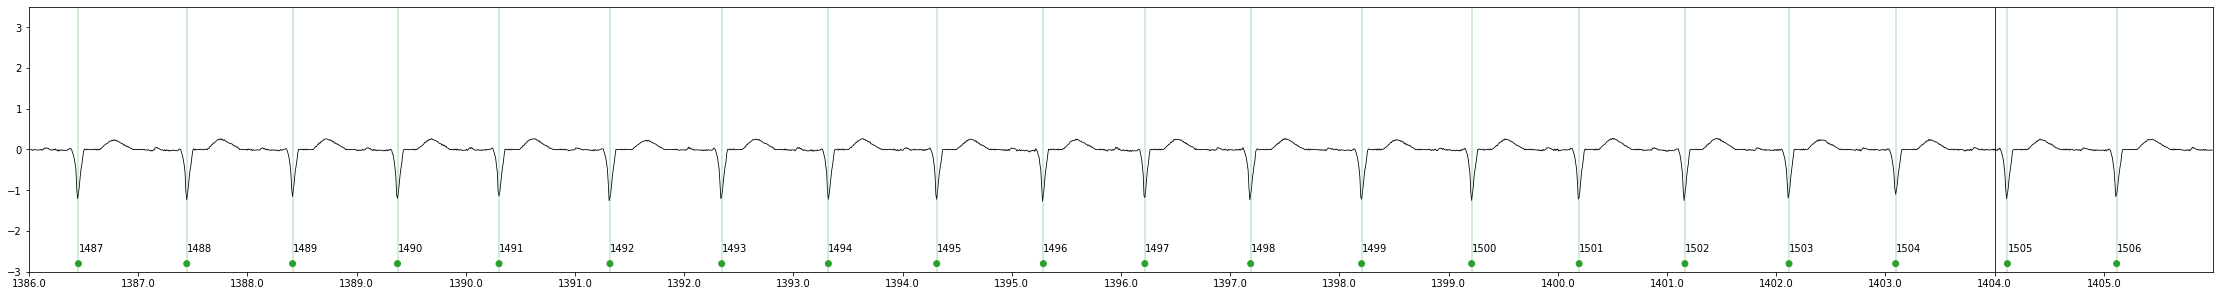

[79] Interval: 1404.0 : 1424.0 = 20.0 sec  Samples:[ 179712 : 182272 ] 	Nos Beats: (21,) [1505 : 1525]


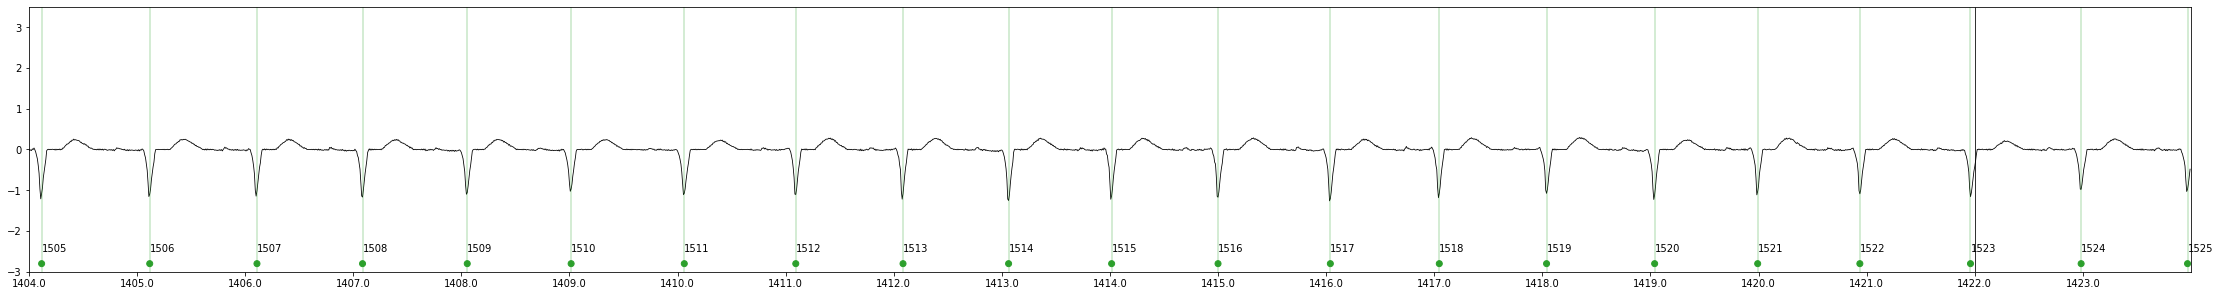

[80] Interval: 1422.0 : 1442.0 = 20.0 sec  Samples:[ 182016 : 184576 ] 	Nos Beats: (20,) [1524 : 1543]


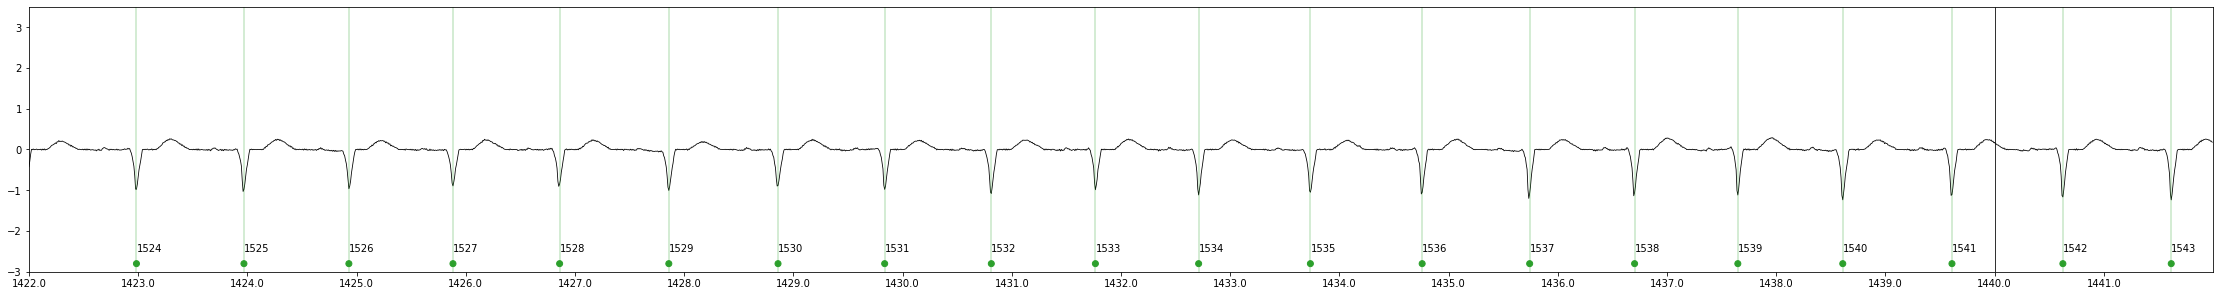

[81] Interval: 1440.0 : 1460.0 = 20.0 sec  Samples:[ 184320 : 186880 ] 	Nos Beats: (20,) [1542 : 1561]


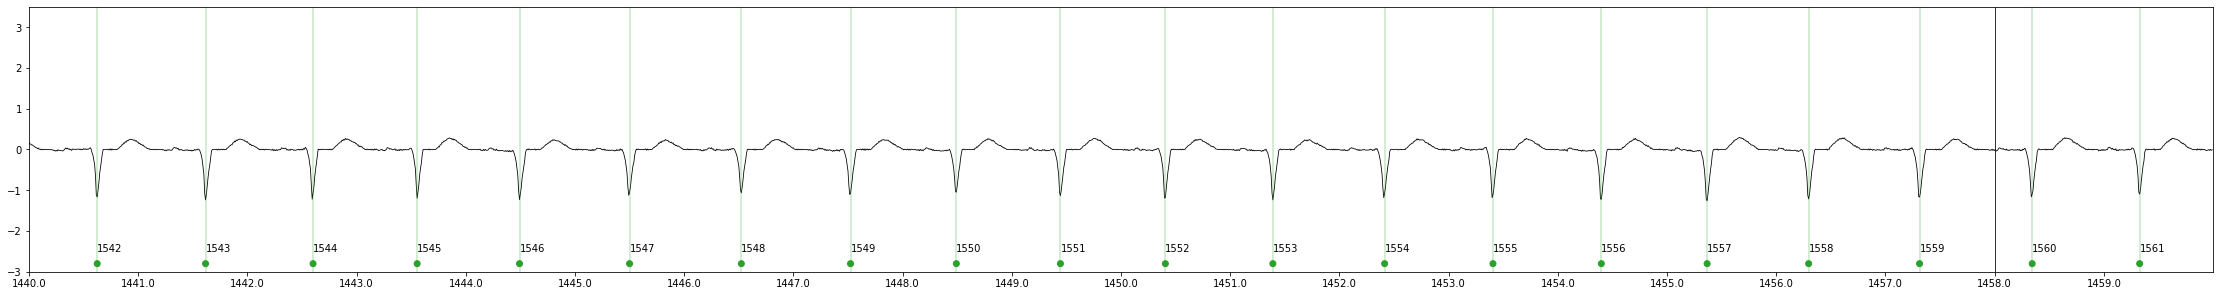

[82] Interval: 1458.0 : 1478.0 = 20.0 sec  Samples:[ 186624 : 189184 ] 	Nos Beats: (20,) [1560 : 1579]


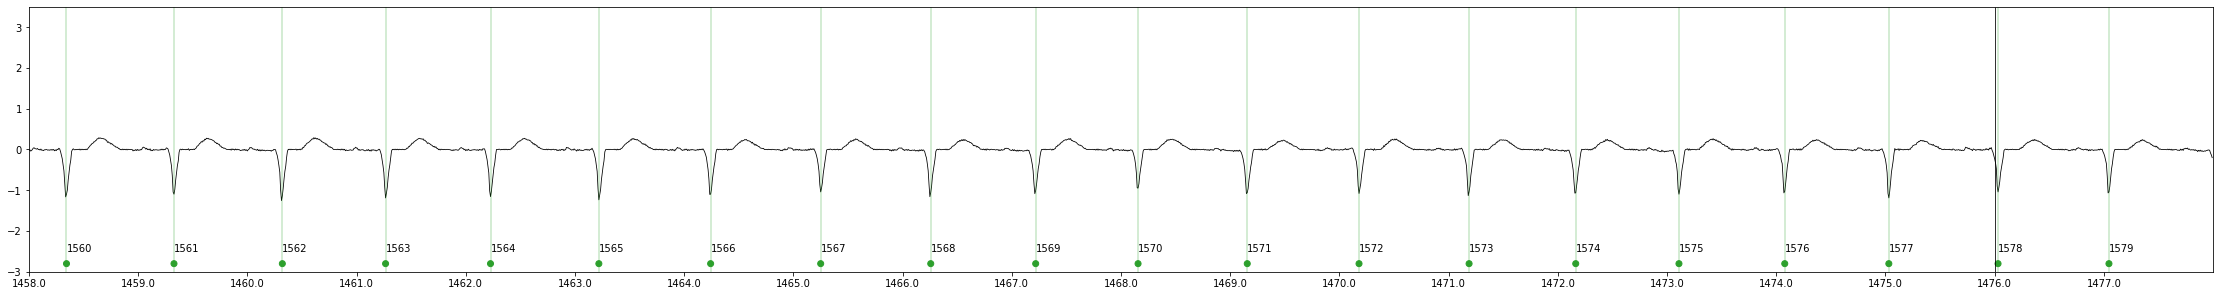

[83] Interval: 1476.0 : 1496.0 = 20.0 sec  Samples:[ 188928 : 191488 ] 	Nos Beats: (21,) [1578 : 1598]


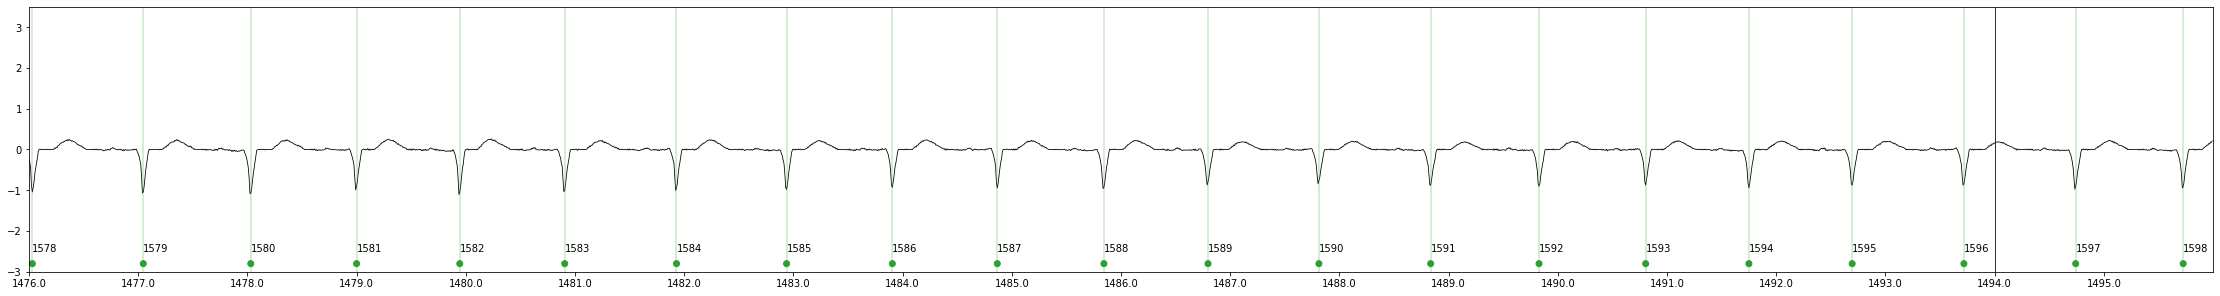

[84] Interval: 1494.0 : 1514.0 = 20.0 sec  Samples:[ 191232 : 193792 ] 	Nos Beats: (20,) [1597 : 1616]


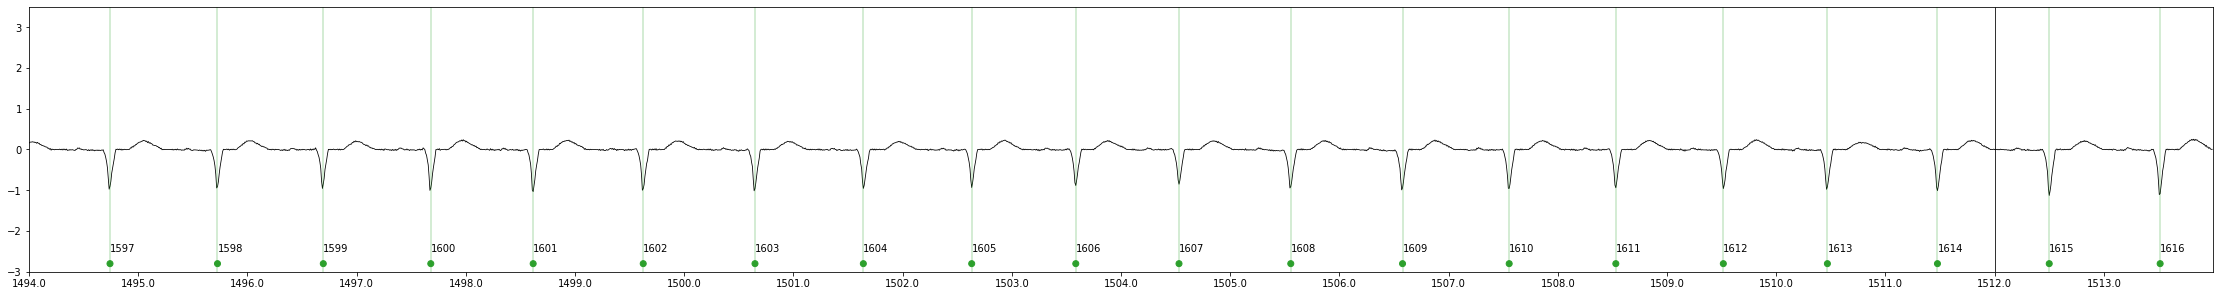

[85] Interval: 1512.0 : 1532.0 = 20.0 sec  Samples:[ 193536 : 196096 ] 	Nos Beats: (20,) [1615 : 1634]


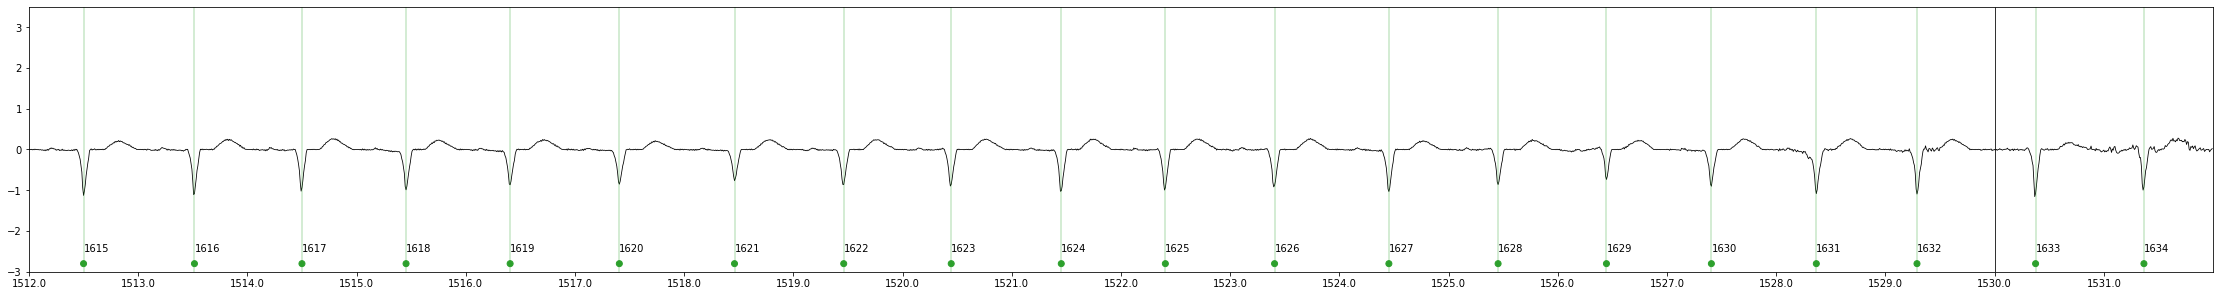

[86] Interval: 1530.0 : 1550.0 = 20.0 sec  Samples:[ 195840 : 198400 ] 	Nos Beats: (11,) [1633 : 1643]


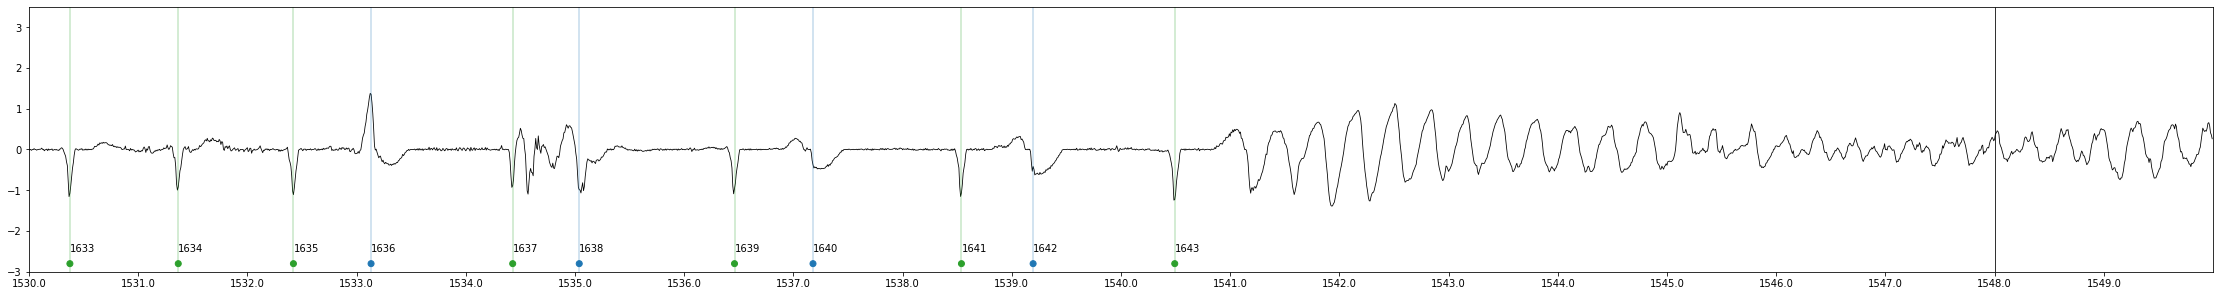

[87] Interval: 1548.0 : 1568.0 = 20.0 sec  Samples:[ 198144 : 200704 ] 	Nos Beats: (0,)  ~ no beats found in this interval


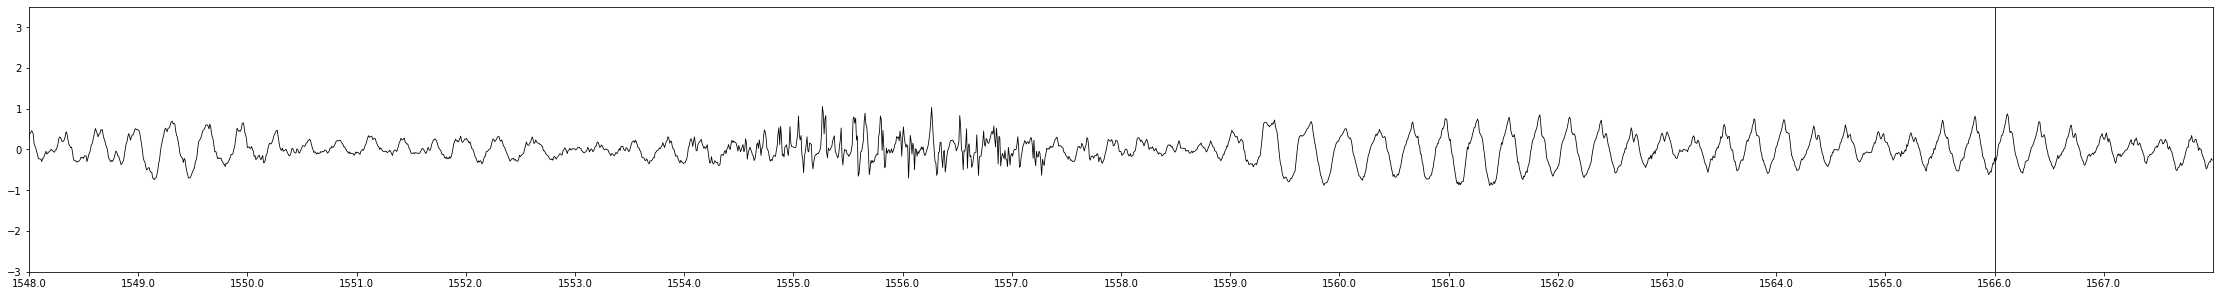

[88] Interval: 1566.0 : 1586.0 = 20.0 sec  Samples:[ 200448 : 203008 ] 	Nos Beats: (0,)  ~ no beats found in this interval


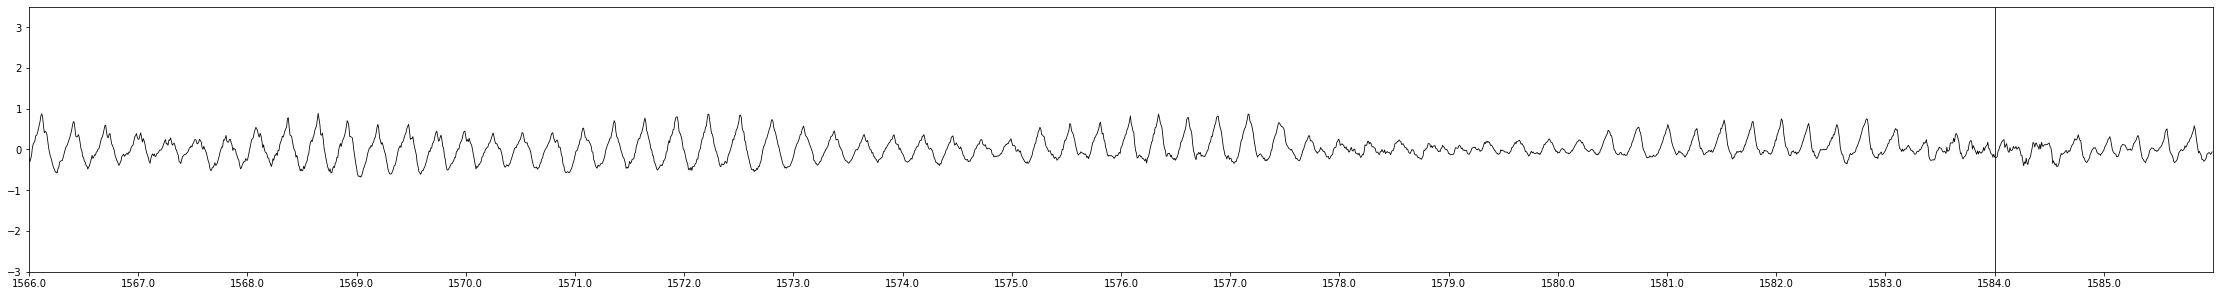

[89] Interval: 1584.0 : 1604.0 = 20.0 sec  Samples:[ 202752 : 205312 ] 	Nos Beats: (0,)  ~ no beats found in this interval


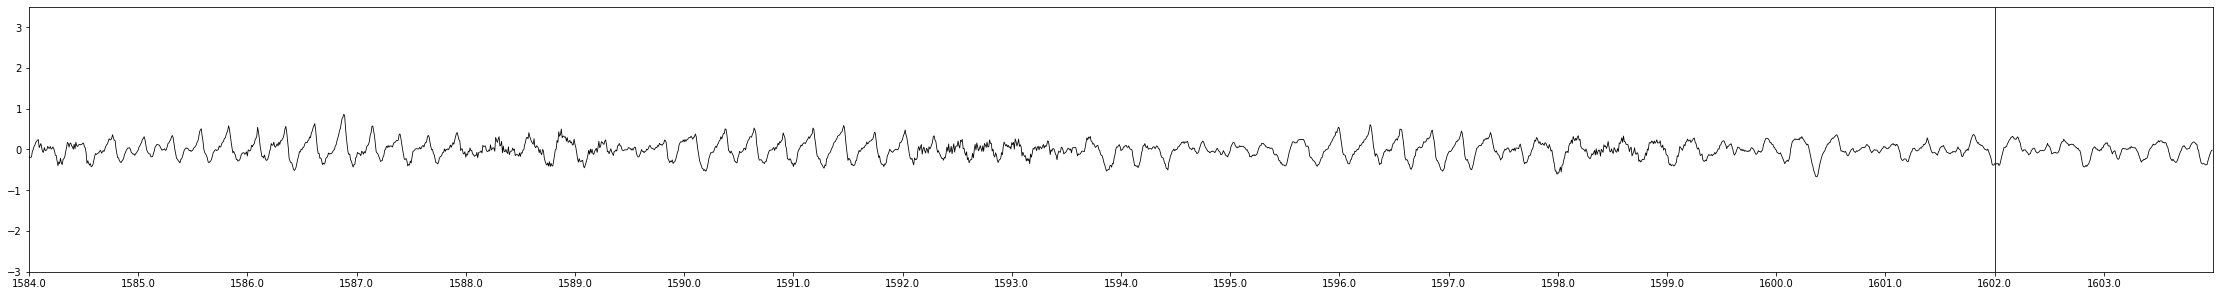

[90] Interval: 1602.0 : 1622.0 = 20.0 sec  Samples:[ 205056 : 207616 ] 	Nos Beats: (0,)  ~ no beats found in this interval


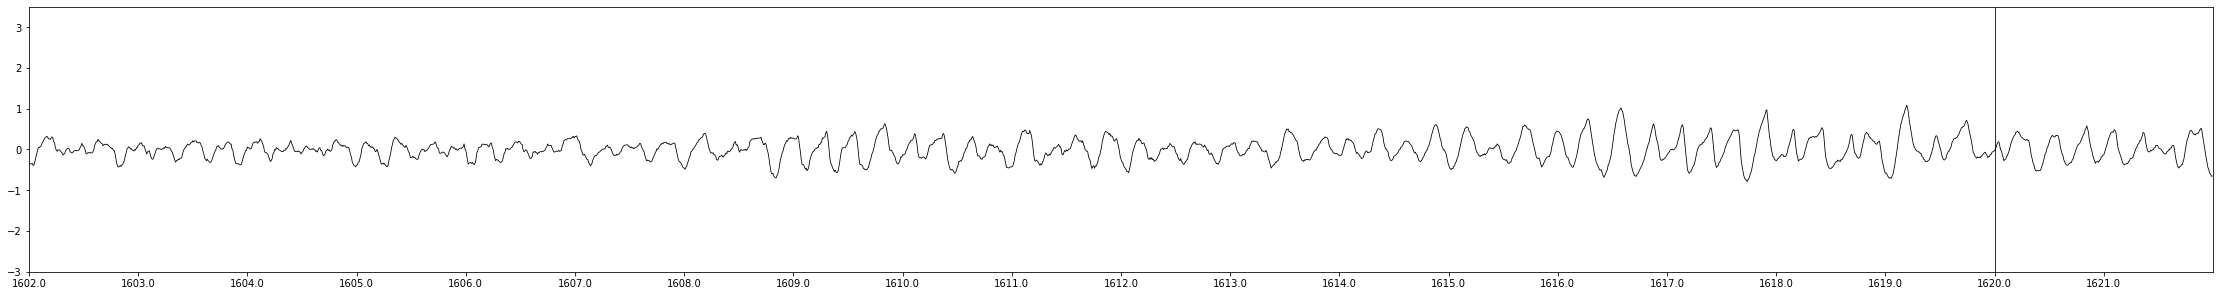

[91] Interval: 1620.0 : 1640.0 = 20.0 sec  Samples:[ 207360 : 209920 ] 	Nos Beats: (0,)  ~ no beats found in this interval


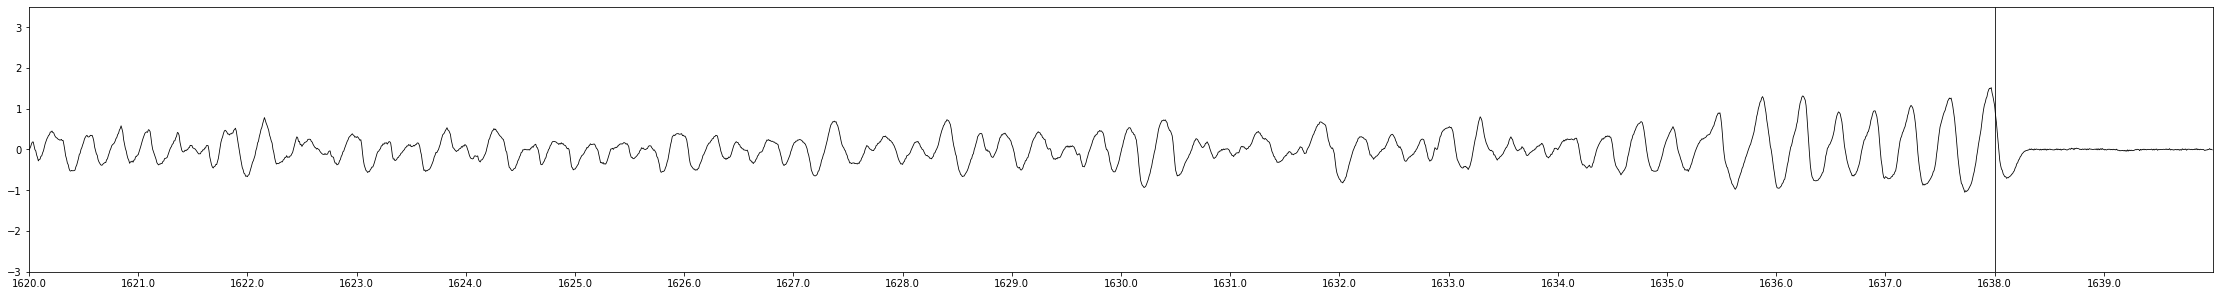

[92] Interval: 1638.0 : 1658.0 = 20.0 sec  Samples:[ 209664 : 212224 ] 	Nos Beats: (13,) [1644 : 1656]


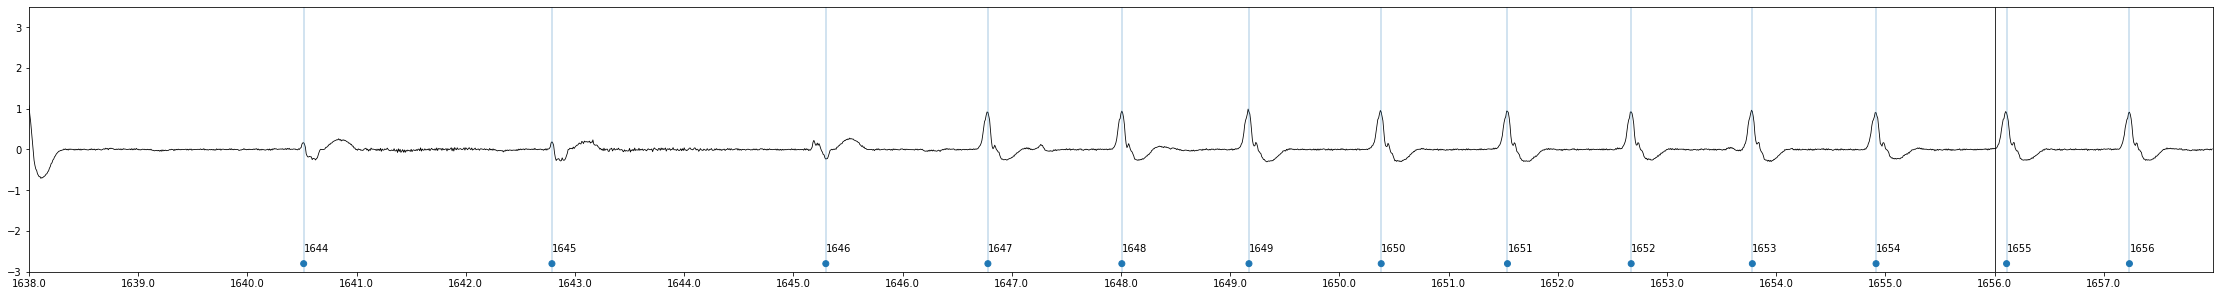

[93] Interval: 1656.0 : 1676.0 = 20.0 sec  Samples:[ 211968 : 214528 ] 	Nos Beats: (19,) [1655 : 1673]


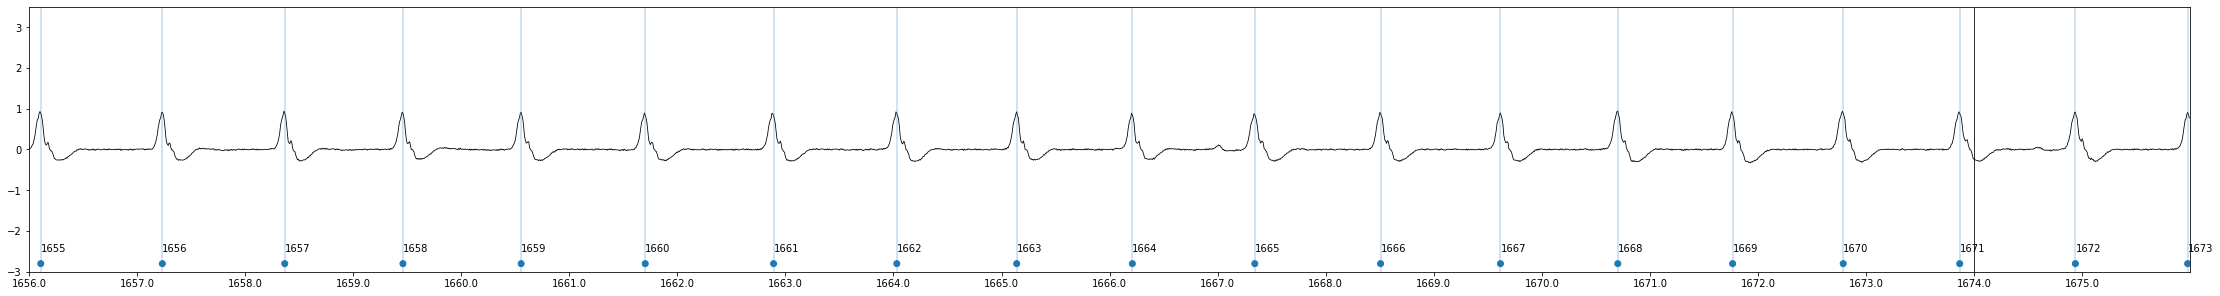

[94] Interval: 1674.0 : 1694.0 = 20.0 sec  Samples:[ 214272 : 216832 ] 	Nos Beats: (21,) [1672 : 1692]


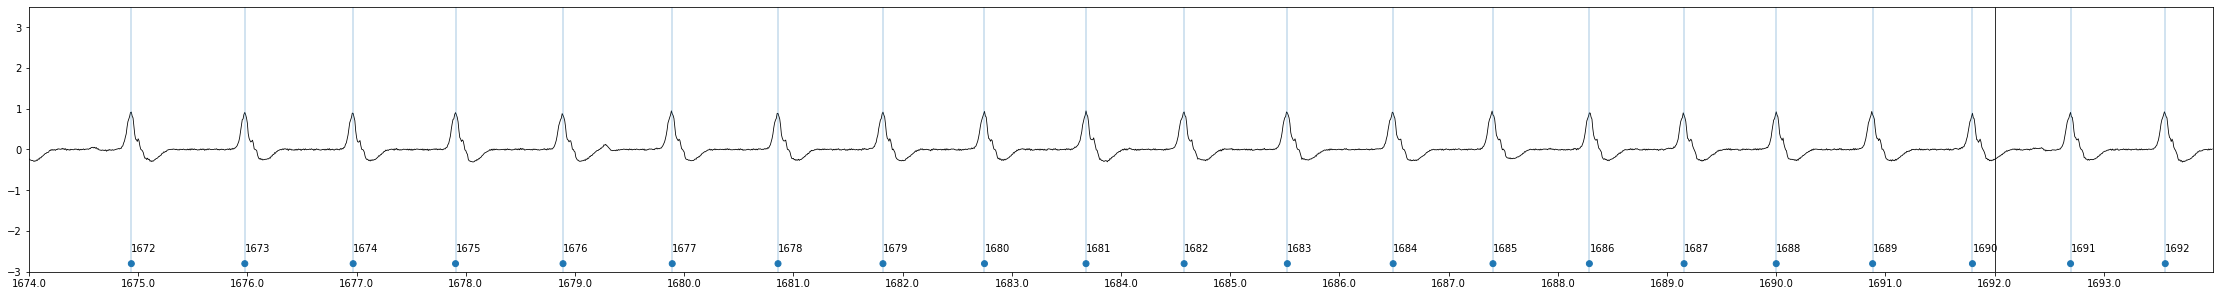

[95] Interval: 1692.0 : 1712.0 = 20.0 sec  Samples:[ 216576 : 219136 ] 	Nos Beats: (20,) [1691 : 1710]


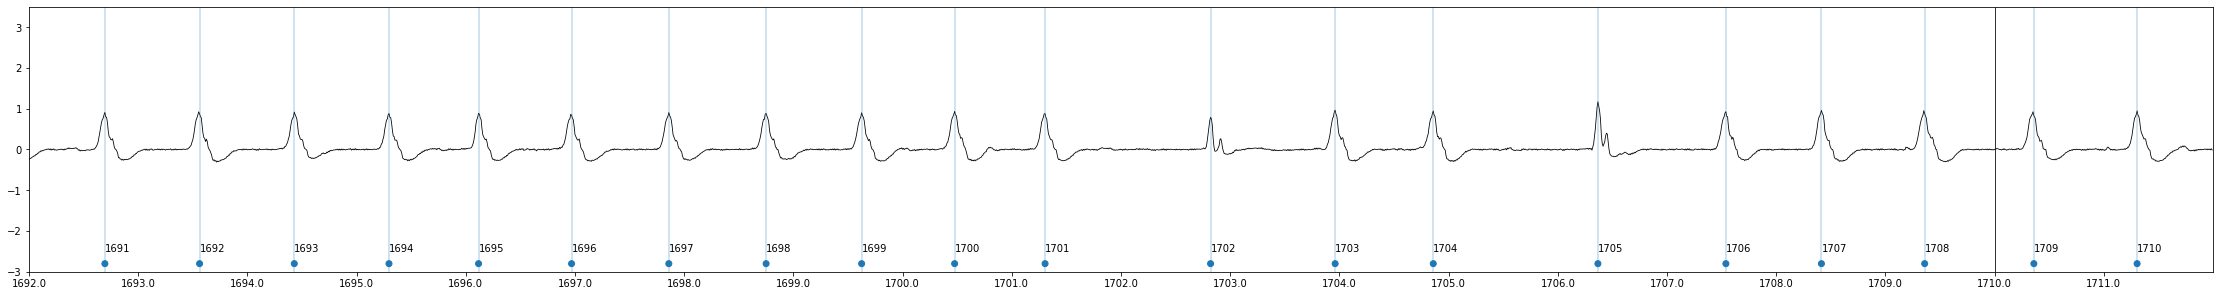

[96] Interval: 1710.0 : 1730.0 = 20.0 sec  Samples:[ 218880 : 221440 ] 	Nos Beats: (20,) [1709 : 1728]


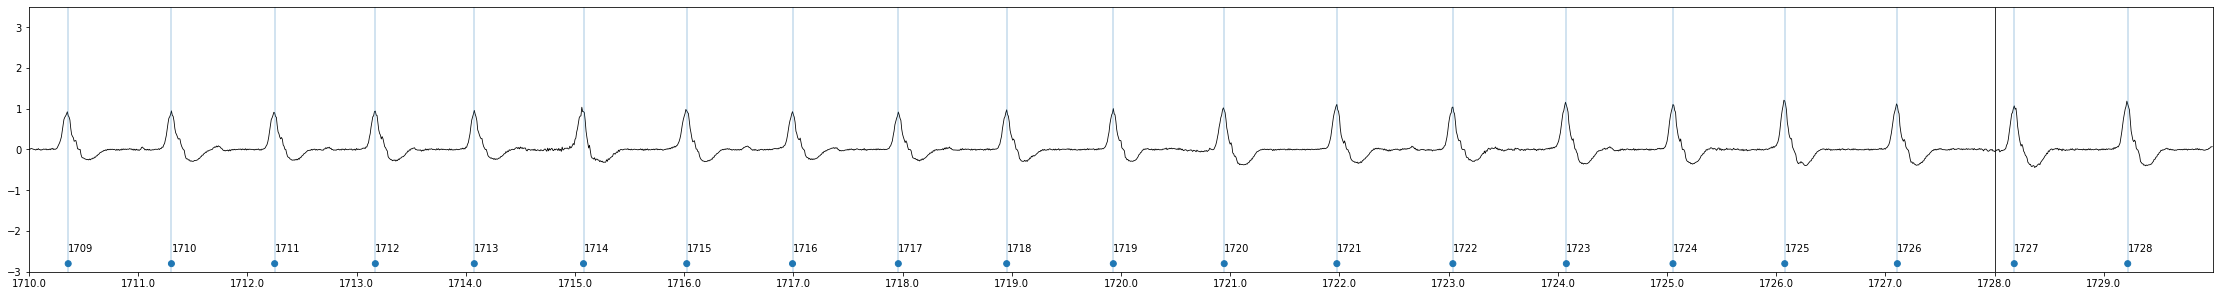

[97] Interval: 1728.0 : 1748.0 = 20.0 sec  Samples:[ 221184 : 223744 ] 	Nos Beats: (21,) [1727 : 1747]


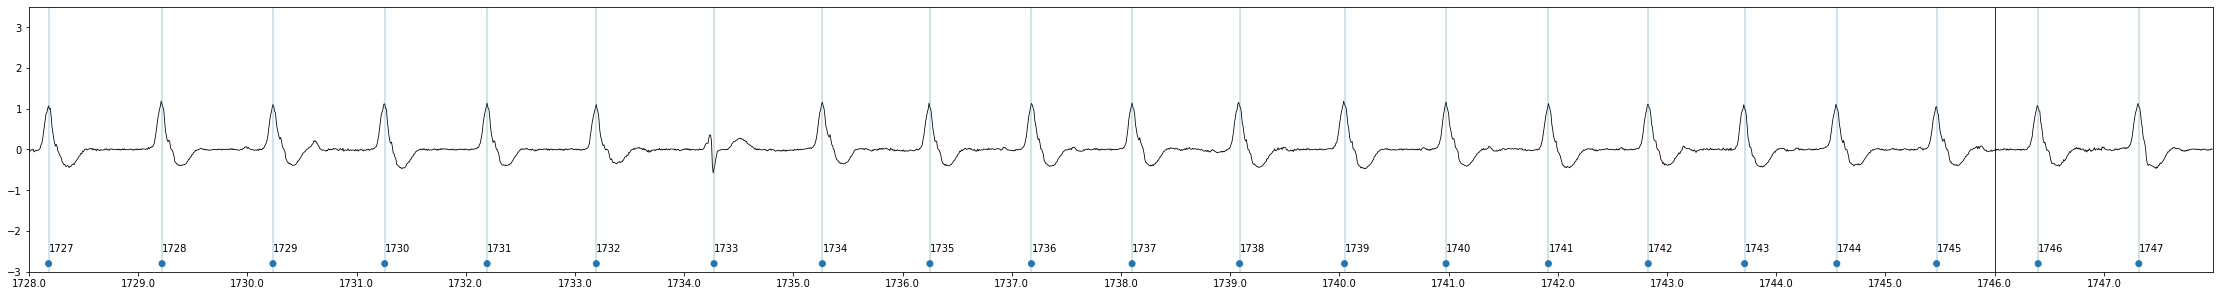

[98] Interval: 1746.0 : 1766.0 = 20.0 sec  Samples:[ 223488 : 226048 ] 	Nos Beats: (35,) [1746 : 1780]


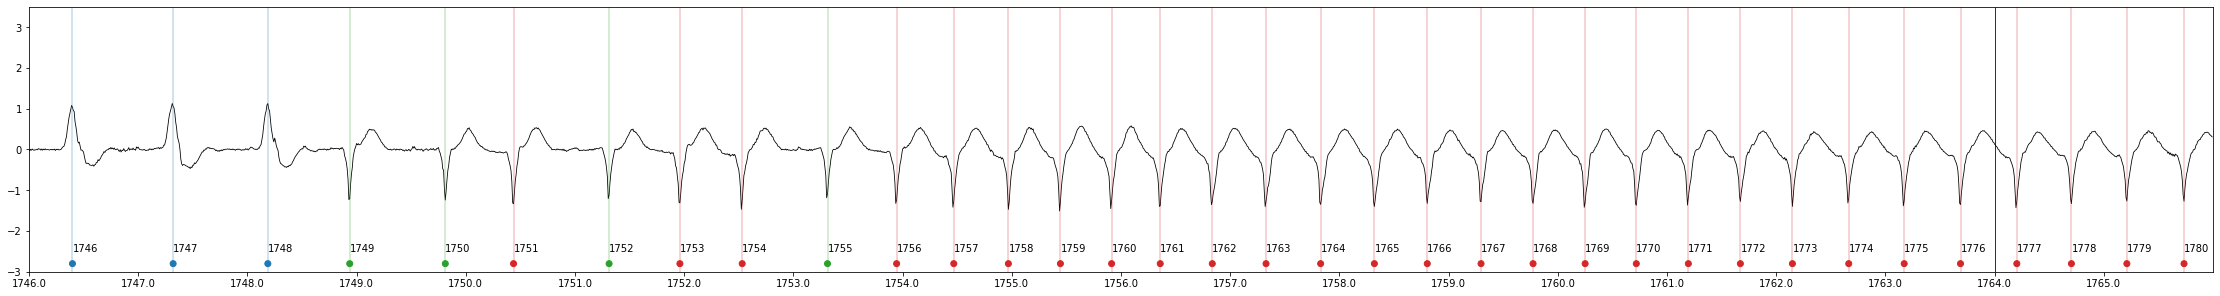

[99] Interval: 1764.0 : 1784.0 = 20.0 sec  Samples:[ 225792 : 228352 ] 	Nos Beats: (40,) [1777 : 1816]


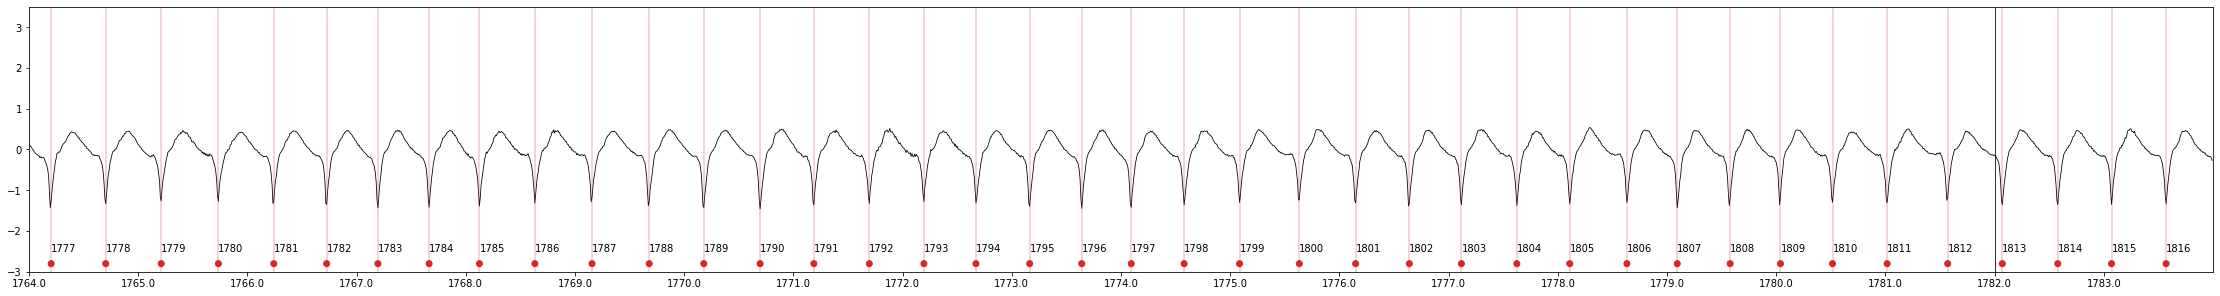

[100] Interval: 1782.0 : 1802.0 = 20.0 sec  Samples:[ 228096 : 230656 ] 	Nos Beats: (40,) [1813 : 1852]


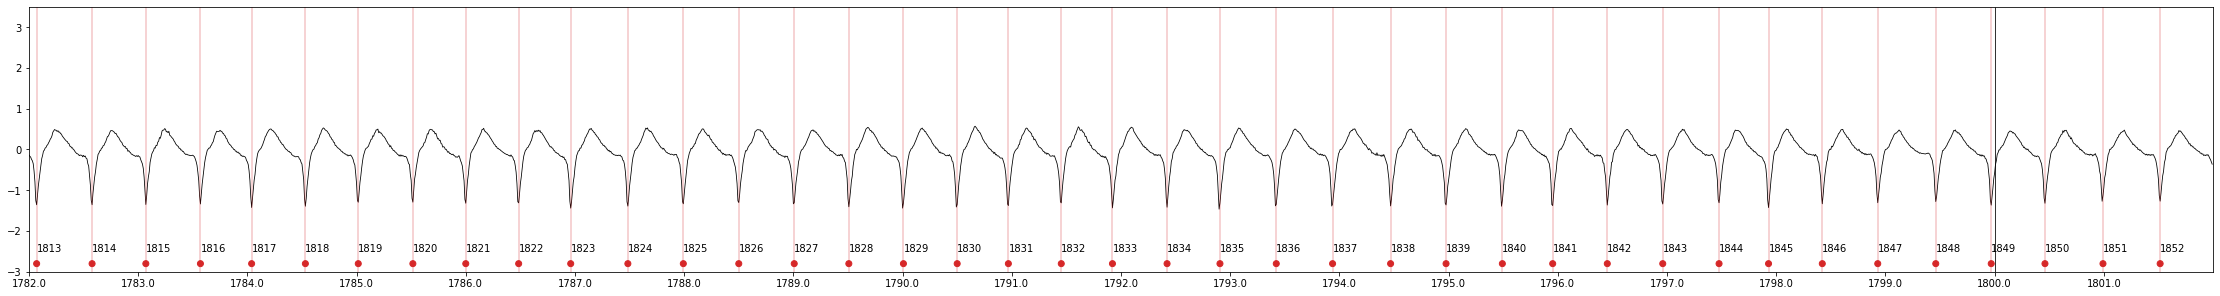

[101] Interval: 1800.0 : 1805.55 = 5.55 sec  Samples:[ 230400 : 231111 ] 	Nos Beats: (10,) [1850 : 1859]


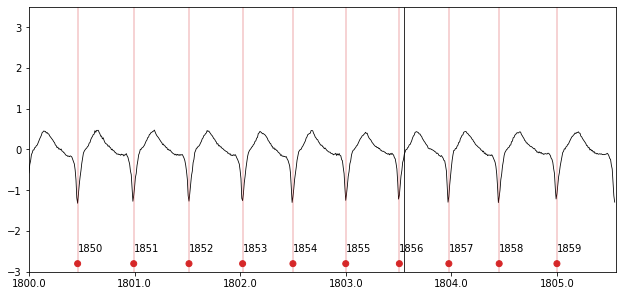

In [10]:
# each record has 1805 sec of ECG = 231111 samples
print('RECORD:', rec.dbname+'/'+rec.name)
sig_len = len(rec.iSignal)
sig_dur = sig_len/BASIC_SRATE
print('Signal Length:',sig_len, 'samples')
print('Signal Duration:',sig_dur, 'sec')
print(gbreak)
print('')
# divide into slices of 20 sec, with overlap of 2 sec
slice_len = 20*BASIC_SRATE
overlap = 2*BASIC_SRATE

count=0
istart = 0
iend = sig_len
while(istart<iend):
    ff,tt = istart, istart+slice_len
    ff, tt = rec.get_true_range(ff,tt)
    this_slice, this_list, this_pf, this_pt = rec.get_signal_slice_fd(ff, tt)
    
    count+=1
    
    if len(this_list)>0:
        temp = '['+str(this_list[0])+' : '+ str(this_list[-1]) + ']'
    else:
        temp = " ~ no beats found in this interval"
        
    print('['+str(count)+']','Interval:',round(ff/BASIC_SRATE,2),':',round(tt/BASIC_SRATE,2),
          '=',round(len(this_slice)/BASIC_SRATE,2),'sec',' Samples:[',this_pf,':', this_pt,']',
          '\tNos Beats:', this_list.shape, temp )


    plot_beat(this_slice, this_list, this_pf, this_pt, this_pt-overlap,
                show_label_ticks=False, show_custom_labels=True, show_custom_vline=True,
                w=0.012, h=4, r=0.5)
    istart+=slice_len-overlap

**Beat Representation**


we consider 2 types for beat representation:

1. Fixed Length - fixed number of samples from either side of the R-peak
2. Variable Length - based on the occurance of previous and next R-peak

***[11.1] Fixed Length Representation***

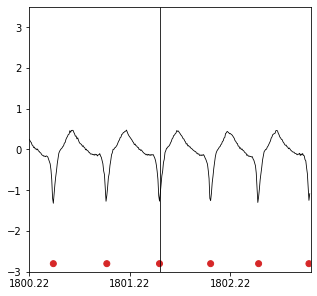

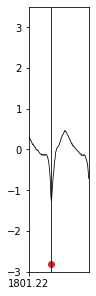

____________________________________________________________________

Beat: mitdb/207/1852 
Mapped-Label: _S 
Standard-Label: A


In [11]:
# Example - Fixed Length

# beat to be represented
bindex = 1852

#<<----------------------------------------------------------------------------------------------
# 1. Longer Representation - 1.3 sec on left and 1.5 sec on right
#<<----------------------------------------------------------------------------------------------
# In fixed length - decide the 'fixed' number of samples to be taken on either side of the R-peak
samp_left, samp_right = int(1.3*BASIC_SRATE),int(1.5*BASIC_SRATE)  

signal_slice, signal_list, pf, pt = rec.get_signal_slice_biF(bindex,samp_left, samp_right)
plot_beat(signal_slice, signal_list, pf, pt, rec.iRpeaks[bindex],
                show_label_ticks=False, show_custom_labels=True, show_custom_vline=False,
                w=0.012, h=4, r=0.5)

#<<----------------------------------------------------------------------------------------------
# 2. Shorter Representation -  0.3 sec on left and 0.5 sec on right
#<<----------------------------------------------------------------------------------------------
# In fixed length - decide the 'fixed' number of samples to be taken on either side of the R-peak
samp_left, samp_right = int(0.3*BASIC_SRATE),int(0.5*BASIC_SRATE) 

signal_slice, signal_list, pf, pt = rec.get_signal_slice_biF(bindex,samp_left, samp_right)
plot_beat(signal_slice, signal_list, pf, pt, rec.iRpeaks[bindex],
                show_label_ticks=False, show_custom_labels=True, show_custom_vline=False,
                w=0.012, h=4, r=0.5)


#<<----------------------------------------------------------------------------------------------
print(gbreak)
print('\nBeat:',rec.dbname+'/'+rec.name+'/'+str(bindex),
     '\nMapped-Label:', rec.mLabels[bindex],
     '\nStandard-Label:', rec.iLabels[bindex]
     )

***[11.2] Variable Length Representation***

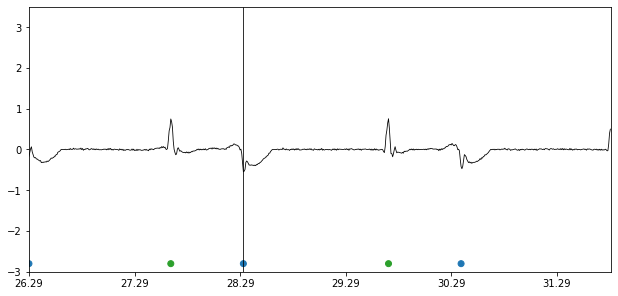

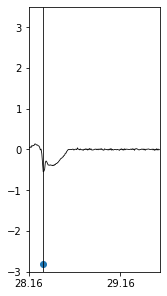

Beat: mitdb/207/27 
Mapped-Label: _V 
Standard-Label: V


In [12]:
# Example - Variable Length

# beat to be represented
bindex = 27

#<<----------------------------------------------------------------------------------------------
# 1. Longer Representation - take signal upto 2 peaks behind and 3 peaks ahead, do not trim
#<<----------------------------------------------------------------------------------------------
prev_i, next_i,trim_left, trim_right = 2,3,0,0

signal_slice, signal_list, pf, pt = rec.get_signal_slice_biV(bindex,prev_i, next_i,trim_left, trim_right)
plot_beat(signal_slice, signal_list, pf, pt, rec.iRpeaks[bindex],
                show_label_ticks=False, show_custom_labels=True, show_custom_vline=False,
                w=0.012, h=4, r=0.5)


#<<----------------------------------------------------------------------------------------------
# 2. Shorter Representation - take signal upto 0 peaks behind and 1 peaks ahead, trim by -20, 12
#<<----------------------------------------------------------------------------------------------
prev_i, next_i,trim_left, trim_right = 0,1,-20,12

signal_slice, signal_list, pf, pt = rec.get_signal_slice_biV(bindex,prev_i, next_i,trim_left, trim_right)
plot_beat(signal_slice, signal_list, pf, pt, rec.iRpeaks[bindex],
                show_label_ticks=False, show_custom_labels=True, show_custom_vline=False,
                w=0.012, h=4, r=0.5)

#<<----------------------------------------------------------------------------------------------
print('Beat:',rec.dbname+'/'+rec.name+'/'+str(bindex),
     '\nMapped-Label:', rec.mLabels[bindex],
     '\nStandard-Label:', rec.iLabels[bindex]
     )

**Concluding Remark**

**The choice of beat representation depends upon the model you are working with.**

Fixed Length - for MLPs, CNNs, Clustering etc

Variable Length - for Time-series or RNN based models. may also be useful for manual feature extraction.